In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
import sys, time

2024-03-24 12:14:49.391423: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 12:14:49.391507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 12:14:49.540829: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-24 12:14:49.973118: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 12:14:55.476146: W tensorflow/compiler/tf2

In [2]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from timeVAE.vae_dense_model import VariationalAutoencoderDense as VAE_Dense
from timeVAE.vae_conv_model import VariationalAutoencoderConv as VAE_Conv
from timeVAE.vae_conv_I_model import VariationalAutoencoderConvInterpretable as TimeVAE
from timeVAE import utils
from sklearn.preprocessing import MinMaxScaler

In [3]:
base_data_train, base_data_test = np.load('../data/sampled/sampled_based_data1yr.npy', allow_pickle=True)
base_data_train, base_data_test = base_data_train[:,:,[1,2]], base_data_test[:,:,[1,2]] # 0,3 = th vs air; 1,2 = el vs sky, 6 = month, 7 = winter/summer
print(base_data_train.shape, base_data_test.shape)

(3255, 730, 2) (335, 730, 2)


In [4]:
base_data_train, base_data_test

(array([[[-1.40000000e+00,  2.33333333e+01],
         [-2.60000000e+00,  1.63333333e+02],
         [-3.00000000e+00,  7.00000000e+02],
         ...,
         [-6.90000000e+00,  6.99999898e+02],
         [-7.90000000e+00,  6.99999898e+02],
         [-8.50000000e+00,  6.99999898e+02]],
 
        [[ 6.00000000e+00,  0.00000000e+00],
         [ 5.80000000e+00,  5.24998961e+02],
         [ 4.60000000e+00,  6.99999996e+02],
         ...,
         [-6.80000000e+00,  6.99999895e+02],
         [-7.70000000e+00,  6.99999895e+02],
         [-8.40000000e+00,  6.99999895e+02]],
 
        [[ 4.50000000e+00,  6.99999993e+02],
         [ 3.20000000e+00,  6.99999993e+02],
         [ 2.00000000e+00,  3.75273893e+00],
         ...,
         [-2.40000000e+00,  6.99999892e+02],
         [-2.60000000e+00,  6.99999891e+02],
         [-1.00000000e+00,  1.21120865e+02]],
 
        ...,
 
        [[-1.40000000e+00,  6.99989073e+02],
         [-2.20000000e+00,  6.99989071e+02],
         [-2.60000000e+00,  6.9998

In [131]:
import tensorflow as tf

# Hide GPU from visible devices
#tf.config.set_visible_devices([], 'GPU')
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<h3> Scale data </h3>

In [5]:
from sklearn.preprocessing import MinMaxScaler

scalers = {var_name: MinMaxScaler(feature_range=(-1,1)) for var_name in ['G.air.T', 'G.E_th_I', 'month']}

temp_var, energy_var = base_data_train[:,:,0], base_data_train[:,:,1]
temp_var_test, energy_var_test = base_data_test[:,:,0], base_data_test[:,:,1]
#indicator_var, indicator_var_test = base_data_train[:,:,2], base_data_test[:,:,2]

temp_var = scalers['G.air.T'].fit_transform(temp_var)
energy_var = scalers['G.E_th_I'].fit_transform(energy_var)
#indicator_var = scalers['month'].fit_transform(indicator_var)

temp_var_test = scalers['G.air.T'].fit_transform(temp_var_test)
energy_var_test = scalers['G.E_th_I'].fit_transform(energy_var_test)
#indicator_var_test = scalers['month'].fit_transform(indicator_var_test)

scaled_data_train, scaled_data_test = np.stack((temp_var, energy_var), axis=-1), np.stack((temp_var_test, energy_var_test), axis=-1)
print(scaled_data_train.shape, scaled_data_test.shape)

(3255, 730, 2) (335, 730, 2)


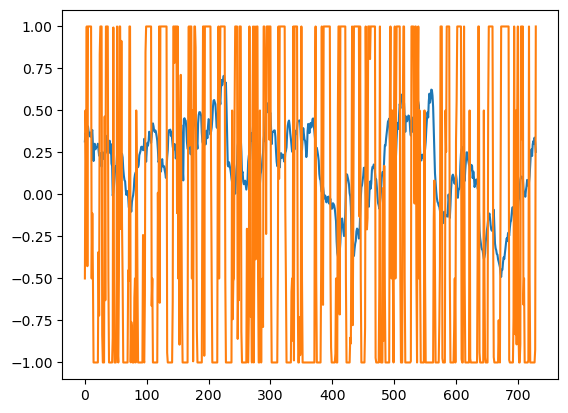

In [6]:
plt.plot(scaled_data_train[1000])

In [43]:
'''scaler = MinMaxScaler()

def scale_cols(data, cols):
    data_copy = np.copy(data)
    data_copy[:, cols] = scaler.fit_transform(data[:, cols])
    return data_copy

cols_to_scale = [0,1]
scaled_data_train, scaled_data_test = scale_cols(base_data_train.reshape(-1, base_data_train.shape[-1]), cols_to_scale), \
    scale_cols(base_data_test.reshape(-1, base_data_test.shape[-1]),cols_to_scale)

scaled_data_train = scaled_data_train.reshape(base_data_train.shape)
scaled_data_test = scaled_data_test.reshape(base_data_test.shape)
print(scaled_data_train.shape, scaled_data_test.shape)'''

'scaler = MinMaxScaler()\n\ndef scale_cols(data, cols):\n    data_copy = np.copy(data)\n    data_copy[:, cols] = scaler.fit_transform(data[:, cols])\n    return data_copy\n\ncols_to_scale = [0,1]\nscaled_data_train, scaled_data_test = scale_cols(base_data_train.reshape(-1, base_data_train.shape[-1]), cols_to_scale),     scale_cols(base_data_test.reshape(-1, base_data_test.shape[-1]),cols_to_scale)\n\nscaled_data_train = scaled_data_train.reshape(base_data_train.shape)\nscaled_data_test = scaled_data_test.reshape(base_data_test.shape)\nprint(scaled_data_train.shape, scaled_data_test.shape)'

<h3> Build VAE </h3>

In [7]:
LATENT_DIM    = 15
LEARNING_RATE = 0.001
EPOCHS        = 100
BATCH_SIZE    = 4

latent_dims = [5, 10, 15, 20, 25]
batch_sizes = [8, 16, 24, 32, 40]
learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]


In [8]:
seq_len = base_data_train.shape[1]
feat_dim = base_data_train.shape[2]

hidden_layer_sizes = [64,128,64]

model = TimeVAE(seq_len=seq_len, 
                feat_dim=feat_dim, 
                latent_dim=LATENT_DIM, 
                hidden_layer_sizes=hidden_layer_sizes,
                use_scaler=False)

2024-03-24 12:15:40.813887: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6662 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:03:00.0, compute capability: 6.1


In [9]:
model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 730, 2)]             0         []                            
                                                                                                  
 enc_conv_0 (Conv1D)         (None, 365, 64)              448       ['encoder_input[0][0]']       
                                                                                                  
 enc_conv_1 (Conv1D)         (None, 183, 128)             24704     ['enc_conv_0[0][0]']          
                                                                                                  
 enc_conv_2 (Conv1D)         (None, 92, 64)               24640     ['enc_conv_1[0][0]']          
                                                                                            

In [10]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE))

<h3> Run VAE </h3>

In [110]:
early_stop = EarlyStopping(monitor='reconstruction_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='reconstruction_loss', factor=0.5, patience=5, verbose=1)

model.fit(scaled_data_train,
        epochs = 500,
        batch_size = BATCH_SIZE,
        shuffle = True,
        callbacks = [early_stop, reduce_lr],
        verbose = 1)

Epoch 1/500
814/814 [==============================] - 10s 13ms/step - loss: 745.6102 - reconstruction_loss: 224.0867 - kl_loss: 79.2424 - lr: 0.0010
Epoch 2/500
814/814 [==============================] - 10s 13ms/step - loss: 745.3935 - reconstruction_loss: 223.3516 - kl_loss: 79.7787 - lr: 0.0010
Epoch 3/500
814/814 [==============================] - 10s 13ms/step - loss: 743.9307 - reconstruction_loss: 222.9763 - kl_loss: 79.8069 - lr: 0.0010
Epoch 4/500
814/814 [==============================] - 10s 13ms/step - loss: 739.1818 - reconstruction_loss: 222.2406 - kl_loss: 80.4197 - lr: 0.0010
Epoch 5/500
814/814 [==============================] - 10s 13ms/step - loss: 735.4937 - reconstruction_loss: 221.5162 - kl_loss: 80.5413 - lr: 0.0010
Epoch 6/500
814/814 [==============================] - 10s 13ms/step - loss: 733.8426 - reconstruction_loss: 220.9544 - kl_loss: 80.1596 - lr: 0.0010
Epoch 7/500
814/814 [==============================] - 11s 13ms/step - loss: 737.6819 - reconstructi

814/814 [==============================] - 10s 12ms/step - loss: 676.6498 - reconstruction_loss: 196.1626 - kl_loss: 90.4473 - lr: 0.0010
Epoch 56/500
814/814 [==============================] - 10s 12ms/step - loss: 670.0119 - reconstruction_loss: 195.3448 - kl_loss: 91.0165 - lr: 0.0010
Epoch 57/500
814/814 [==============================] - 10s 12ms/step - loss: 670.5970 - reconstruction_loss: 194.9156 - kl_loss: 90.7193 - lr: 0.0010
Epoch 58/500
814/814 [==============================] - 10s 12ms/step - loss: 664.6325 - reconstruction_loss: 194.6392 - kl_loss: 90.7155 - lr: 0.0010
Epoch 59/500
814/814 [==============================] - 10s 12ms/step - loss: 662.0519 - reconstruction_loss: 194.0789 - kl_loss: 91.3366 - lr: 0.0010
Epoch 60/500
814/814 [==============================] - 10s 13ms/step - loss: 662.8380 - reconstruction_loss: 193.3062 - kl_loss: 90.8772 - lr: 0.0010
Epoch 61/500
814/814 [==============================] - 10s 13ms/step - loss: 662.6451 - reconstruction_los

814/814 [==============================] - 10s 12ms/step - loss: 600.3532 - reconstruction_loss: 168.3147 - kl_loss: 99.7876 - lr: 0.0010
Epoch 110/500
814/814 [==============================] - 10s 13ms/step - loss: 599.2031 - reconstruction_loss: 167.7652 - kl_loss: 102.0151 - lr: 0.0010
Epoch 111/500
814/814 [==============================] - 10s 13ms/step - loss: 598.8831 - reconstruction_loss: 167.2921 - kl_loss: 99.0530 - lr: 0.0010
Epoch 112/500
814/814 [==============================] - 10s 13ms/step - loss: 589.6344 - reconstruction_loss: 165.9674 - kl_loss: 100.3007 - lr: 0.0010
Epoch 113/500
814/814 [==============================] - 10s 12ms/step - loss: 589.6797 - reconstruction_loss: 166.8710 - kl_loss: 100.2104 - lr: 0.0010
Epoch 114/500
814/814 [==============================] - 10s 13ms/step - loss: 592.8838 - reconstruction_loss: 165.9615 - kl_loss: 99.4452 - lr: 0.0010
Epoch 115/500
814/814 [==============================] - 10s 13ms/step - loss: 594.6642 - reconstru

814/814 [==============================] - 11s 13ms/step - loss: 528.1141 - reconstruction_loss: 143.1565 - kl_loss: 102.1072 - lr: 5.0000e-04
Epoch 161/500
814/814 [==============================] - 11s 13ms/step - loss: 528.4366 - reconstruction_loss: 142.9336 - kl_loss: 102.8526 - lr: 5.0000e-04
Epoch 162/500
814/814 [==============================] - 11s 13ms/step - loss: 530.1676 - reconstruction_loss: 143.1373 - kl_loss: 101.9031 - lr: 5.0000e-04
Epoch 163/500
814/814 [==============================] - 10s 13ms/step - loss: 525.8568 - reconstruction_loss: 143.2553 - kl_loss: 102.3577 - lr: 5.0000e-04
Epoch 164/500
814/814 [==============================] - 11s 13ms/step - loss: 524.3951 - reconstruction_loss: 142.7994 - kl_loss: 102.7032 - lr: 5.0000e-04
Epoch 165/500
814/814 [==============================] - 11s 13ms/step - loss: 529.4791 - reconstruction_loss: 142.7302 - kl_loss: 101.9292 - lr: 5.0000e-04
Epoch 166/500
814/814 [==============================] - 11s 13ms/step -

814/814 [==============================] - 10s 13ms/step - loss: 519.9053 - reconstruction_loss: 137.9034 - kl_loss: 104.7831 - lr: 5.0000e-04
Epoch 213/500
814/814 [==============================] - 10s 13ms/step - loss: 512.4045 - reconstruction_loss: 137.9833 - kl_loss: 104.9994 - lr: 5.0000e-04
Epoch 214/500
814/814 [==============================] - 11s 13ms/step - loss: 513.1138 - reconstruction_loss: 137.5187 - kl_loss: 104.7712 - lr: 5.0000e-04
Epoch 215/500
814/814 [==============================] - 10s 13ms/step - loss: 516.0310 - reconstruction_loss: 137.5783 - kl_loss: 104.3713 - lr: 5.0000e-04
Epoch 216/500
814/814 [==============================] - 10s 13ms/step - loss: 510.2548 - reconstruction_loss: 137.2472 - kl_loss: 104.0816 - lr: 5.0000e-04
Epoch 217/500
814/814 [==============================] - 10s 13ms/step - loss: 511.2039 - reconstruction_loss: 137.5029 - kl_loss: 104.5304 - lr: 5.0000e-04
Epoch 218/500
814/814 [==============================] - 10s 13ms/step -

814/814 [==============================] - 10s 12ms/step - loss: 499.4394 - reconstruction_loss: 133.7696 - kl_loss: 106.4553 - lr: 5.0000e-04
Epoch 265/500
814/814 [==============================] - 10s 13ms/step - loss: 505.1907 - reconstruction_loss: 134.2078 - kl_loss: 105.8168 - lr: 5.0000e-04
Epoch 266/500
814/814 [==============================] - 10s 12ms/step - loss: 504.6966 - reconstruction_loss: 134.3198 - kl_loss: 106.1171 - lr: 5.0000e-04
Epoch 267/500
814/814 [==============================] - 10s 12ms/step - loss: 503.3692 - reconstruction_loss: 134.1594 - kl_loss: 106.1080 - lr: 5.0000e-04
Epoch 268/500
814/814 [==============================] - 10s 13ms/step - loss: 507.8822 - reconstruction_loss: 134.1978 - kl_loss: 106.5754 - lr: 5.0000e-04
Epoch 269/500
812/814 [============================>.] - ETA: 0s - loss: 512.4329 - reconstruction_loss: 134.3809 - kl_loss: 106.2939
Epoch 269: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
814/814 [========

814/814 [==============================] - 10s 12ms/step - loss: 484.7512 - reconstruction_loss: 127.2281 - kl_loss: 105.2798 - lr: 2.5000e-04
Epoch 316/500
814/814 [==============================] - ETA: 0s - loss: 491.7036 - reconstruction_loss: 127.1809 - kl_loss: 105.5582
Epoch 316: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
814/814 [==============================] - 10s 12ms/step - loss: 491.6980 - reconstruction_loss: 127.1809 - kl_loss: 105.5582 - lr: 2.5000e-04
Epoch 317/500
814/814 [==============================] - 10s 13ms/step - loss: 484.7731 - reconstruction_loss: 125.8078 - kl_loss: 105.9211 - lr: 1.2500e-04
Epoch 318/500
814/814 [==============================] - 11s 13ms/step - loss: 484.2261 - reconstruction_loss: 125.2741 - kl_loss: 106.0254 - lr: 1.2500e-04
Epoch 319/500
814/814 [==============================] - 10s 13ms/step - loss: 480.3520 - reconstruction_loss: 125.2609 - kl_loss: 105.4145 - lr: 1.2500e-04
Epoch 320/500
814/814 [========

814/814 [==============================] - 10s 13ms/step - loss: 472.1676 - reconstruction_loss: 123.1346 - kl_loss: 105.6978 - lr: 6.2500e-05
Epoch 365/500
814/814 [==============================] - ETA: 0s - loss: 475.1910 - reconstruction_loss: 123.1993 - kl_loss: 105.9815
Epoch 365: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
814/814 [==============================] - 10s 13ms/step - loss: 475.1915 - reconstruction_loss: 123.1993 - kl_loss: 105.9815 - lr: 6.2500e-05
Epoch 366/500
814/814 [==============================] - 10s 13ms/step - loss: 478.1574 - reconstruction_loss: 122.8224 - kl_loss: 105.9529 - lr: 3.1250e-05
Epoch 367/500
814/814 [==============================] - 10s 13ms/step - loss: 474.9273 - reconstruction_loss: 122.9297 - kl_loss: 105.7677 - lr: 3.1250e-05
Epoch 368/500
814/814 [==============================] - 10s 13ms/step - loss: 470.2726 - reconstruction_loss: 122.8961 - kl_loss: 105.9273 - lr: 3.1250e-05
Epoch 369/500
814/814 [========

812/814 [============================>.] - ETA: 0s - loss: 476.5811 - reconstruction_loss: 122.2976 - kl_loss: 105.6737Restoring model weights from the end of the best epoch: 398.

Epoch 408: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
814/814 [==============================] - 10s 13ms/step - loss: 476.5661 - reconstruction_loss: 122.2707 - kl_loss: 105.6381 - lr: 9.7656e-07
Epoch 408: early stopping


[]

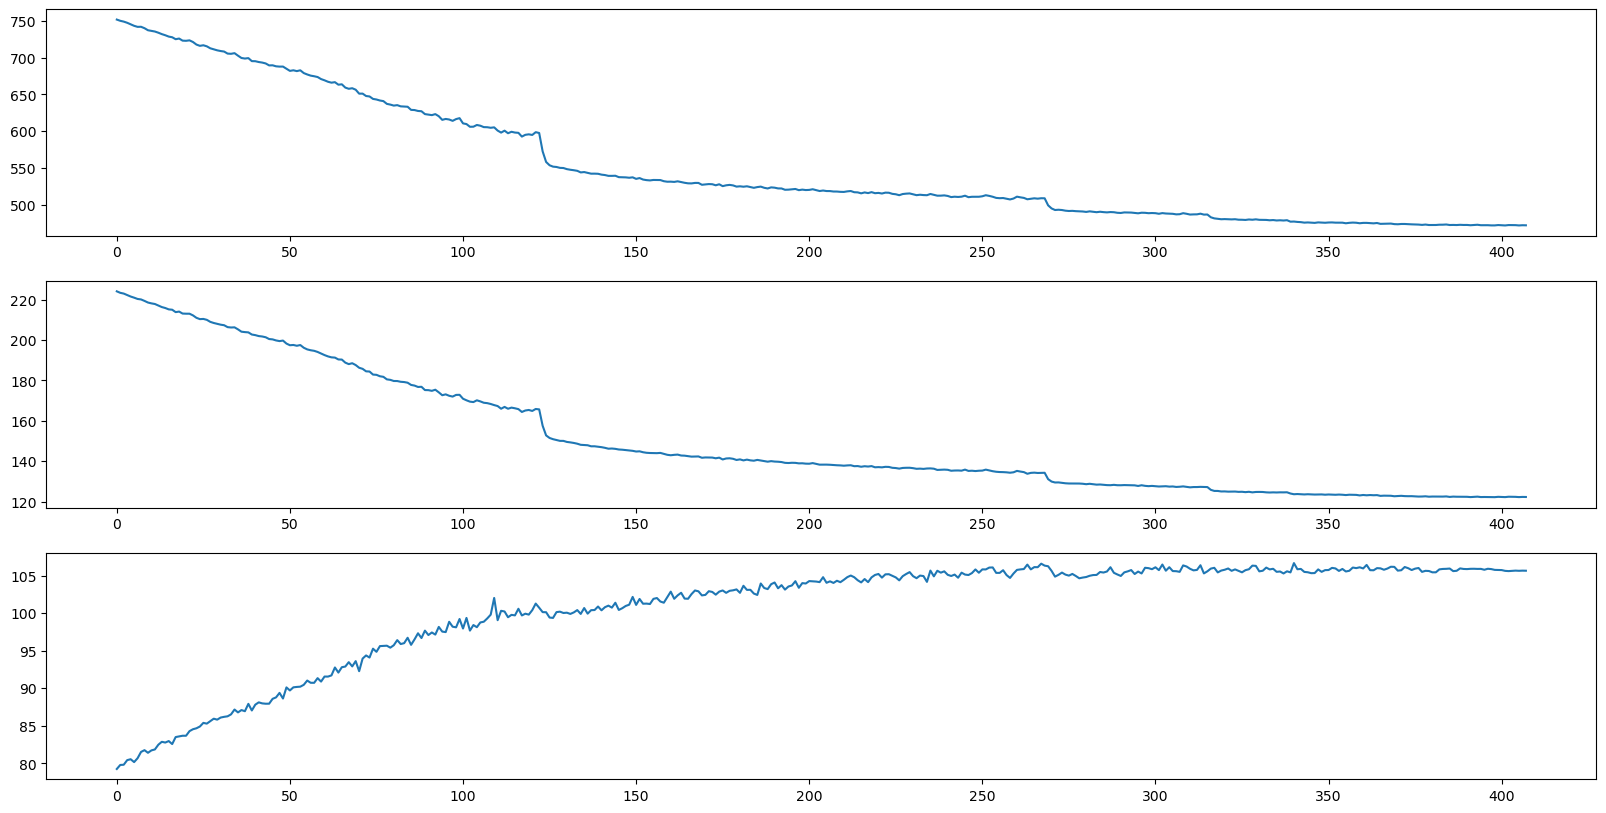

In [111]:
fig, ax = plt.subplots(3,1,figsize=(20,10))
ax[0].plot(model.history.history['loss'])
ax[1].plot(model.history.history['reconstruction_loss'])
ax[2].plot(model.history.history['kl_loss'])
plt.plot()

<h3> Generate synthetic samples </h3>

In [112]:
num_samples = 5_000
samples = model.get_prior_samples(num_samples=num_samples)
print(samples.shape)

157/157 [==============================] - 0s 2ms/step
(5000, 730, 2)


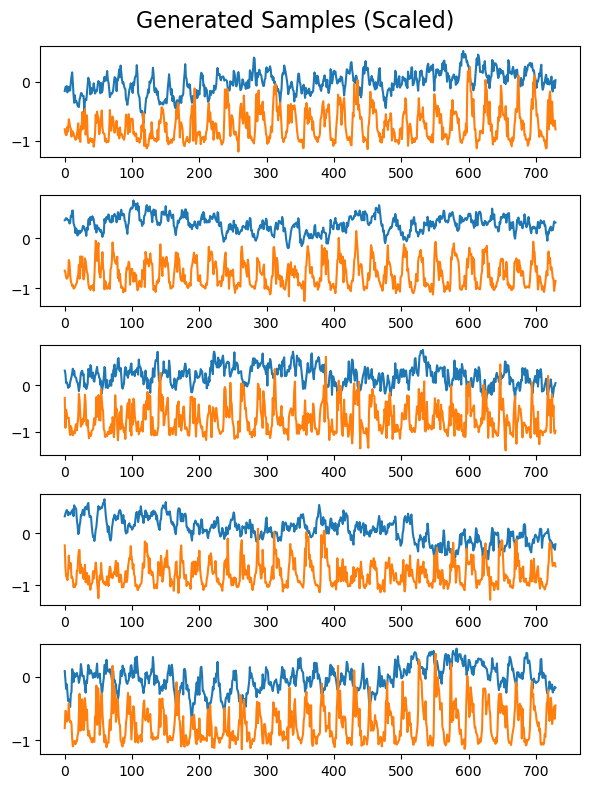

In [113]:
utils.plot_samples(samples,n=5)

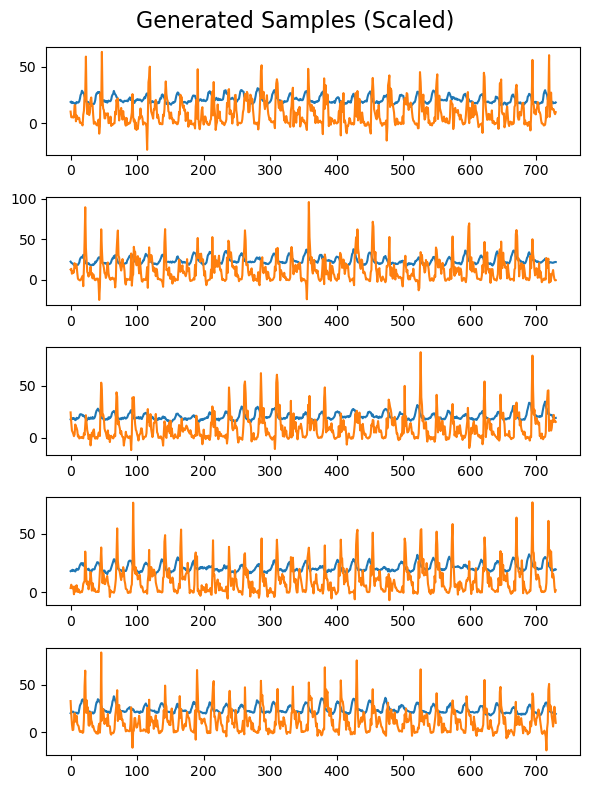

In [114]:
samples_temp_var, samples_energy_var = samples[:,:,0], samples[:,:,1]
samples_temp_var, samples_energy_var = scalers['G.air.T'].inverse_transform(samples_temp_var), \
    scalers['G.E_th_I'].inverse_transform(samples_energy_var)
scaled_samples = np.stack((samples_temp_var, samples_energy_var), axis=-1)
utils.plot_samples(scaled_samples,n=5)

In [115]:
np.save('../data/tuning/th_v_air_samples.npy', samples)
np.save('../data/tuning/th_v_air_scaled_samples.npy', scaled_samples)

In [116]:
loss = pd.DataFrame(vae.history.history)
loss.to_csv(f'../data/tuning/th_v_air_loss.csv')


In [118]:
model.save('../model/', 'th_v_air_VAE')

Text(0.5, 1.0, 'Synthetic samples')

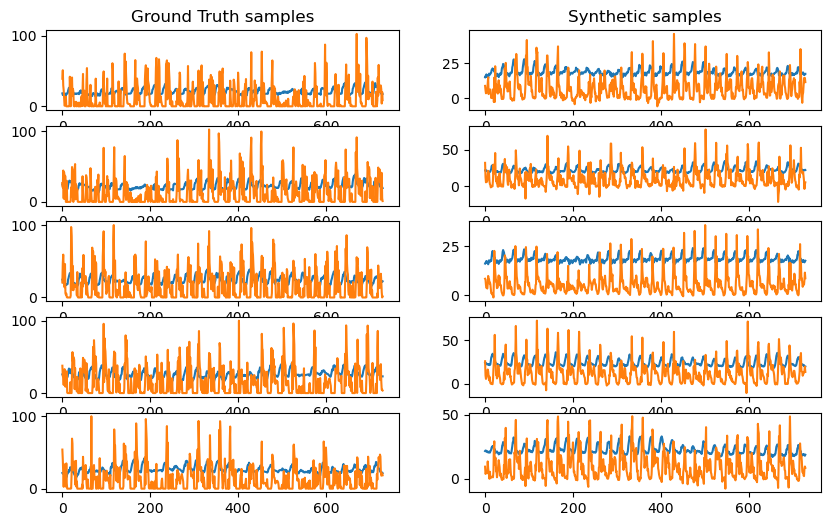

In [128]:
fig, axs = plt.subplots(5,2,figsize=(10,6))
for i in range(5):
    axs[i,0].plot(base_data_train[(i*14)+100,:])
    axs[i,1].plot(scaled_samples[i+150,:])
    
axs[0,0].set_title('Ground Truth samples')
axs[0,1].set_title('Synthetic samples')
    

<h3> Hyperparameter tuning </h3>

In [15]:
latent_dims = [25, 30, 50]
batch_sizes = [4, 8, 16, 24, 32]
learning_rates = [0.001]

losses = []
sample_list = []

seq_len = base_data_train.shape[1]
feat_dim = base_data_train.shape[2]

hidden_layer_sizes = [64,128,64]

for lr in learning_rates:
    for l_dim in latent_dims:
        for b_size in batch_sizes:
            vae = TimeVAE(seq_len=seq_len, 
                    feat_dim=feat_dim, 
                    latent_dim=l_dim, 
                    hidden_layer_sizes=hidden_layer_sizes,
                    use_scaler=False)

            vae.compile(optimizer=Adam(learning_rate=lr))

            early_stop = EarlyStopping(monitor='reconstruction_loss', patience=10, verbose=1, restore_best_weights=True)
            reduce_lr  = ReduceLROnPlateau(monitor='reconstruction_loss', factor=0.5, patience=5, verbose=1)

            print(f'Latent dimension: {l_dim}, Batch size: {b_size}')
            vae.fit(scaled_data_train,
                    epochs = 500,
                    batch_size = b_size,
                    shuffle = True,
                    callbacks = [early_stop, reduce_lr],
                    verbose = 1)

            loss = pd.DataFrame(vae.history.history)
            loss.to_csv(f'../data/tuning/el_v_sky/lr{lr}l{l_dim}b{b_size}_hist.csv')
            losses.append(loss)

            samples = model.get_prior_samples(num_samples=1000)
            np.save(f'../data/tuning/el_v_sky/lr{lr}l{l_dim}b{b_size}_samples.npy', samples)
            sample_list.append(samples)

            samples_temp_var, samples_energy_var = samples[:,:,0], samples[:,:,1]
            samples_temp_var, samples_energy_var = scalers['G.air.T'].inverse_transform(samples_temp_var), \
                scalers['G.E_th_I'].inverse_transform(samples_energy_var)
            #samples_indic_var = scalers['month'].inverse_transform(samples[:,:,2])
            
            scaled_samples = np.stack((samples_temp_var, samples_energy_var), axis=-1)
            np.save(f'../data/tuning/el_v_sky/lr{lr}l{l_dim}b{b_size}_scaled_samples.npy', scaled_samples)

Latent dimension: 25, Batch size: 4
Epoch 1/500


2024-03-24 12:17:48.947579: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-24 12:18:04.019182: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa12ce7eb40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-24 12:18:04.019234: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-03-24 12:18:04.142754: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1711282684.581820  273315 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


814/814 [==============================] - 39s 13ms/step - loss: 6822.2561 - reconstruction_loss: 1981.0115 - kl_loss: 90.8290 - lr: 0.0010
Epoch 2/500
814/814 [==============================] - 11s 13ms/step - loss: 5684.3224 - reconstruction_loss: 1876.2847 - kl_loss: 63.0483 - lr: 0.0010
Epoch 3/500
814/814 [==============================] - 11s 13ms/step - loss: 5637.8645 - reconstruction_loss: 1869.2346 - kl_loss: 73.0133 - lr: 0.0010
Epoch 4/500
814/814 [==============================] - 10s 13ms/step - loss: 5594.1369 - reconstruction_loss: 1838.0811 - kl_loss: 67.8007 - lr: 0.0010
Epoch 5/500
814/814 [==============================] - 11s 13ms/step - loss: 5461.0520 - reconstruction_loss: 1802.0123 - kl_loss: 74.0969 - lr: 0.0010
Epoch 6/500
814/814 [==============================] - 11s 13ms/step - loss: 5418.7902 - reconstruction_loss: 1775.2047 - kl_loss: 66.2566 - lr: 0.0010
Epoch 7/500
814/814 [==============================] - 11s 13ms/step - loss: 5340.3809 - reconstruct

814/814 [==============================] - 11s 13ms/step - loss: 1929.5971 - reconstruction_loss: 573.1049 - kl_loss: 285.6344 - lr: 0.0010
Epoch 55/500
814/814 [==============================] - 11s 13ms/step - loss: 1922.1376 - reconstruction_loss: 568.4655 - kl_loss: 285.6465 - lr: 0.0010
Epoch 56/500
814/814 [==============================] - 11s 13ms/step - loss: 1903.6779 - reconstruction_loss: 564.1597 - kl_loss: 284.8997 - lr: 0.0010
Epoch 57/500
814/814 [==============================] - 11s 13ms/step - loss: 1890.6039 - reconstruction_loss: 558.8929 - kl_loss: 285.8864 - lr: 0.0010
Epoch 58/500
814/814 [==============================] - 11s 13ms/step - loss: 1879.1961 - reconstruction_loss: 555.9349 - kl_loss: 286.8646 - lr: 0.0010
Epoch 59/500
814/814 [==============================] - 11s 13ms/step - loss: 1869.6819 - reconstruction_loss: 552.5558 - kl_loss: 286.3078 - lr: 0.0010
Epoch 60/500
814/814 [==============================] - 11s 13ms/step - loss: 1852.3971 - recon

814/814 [==============================] - 11s 13ms/step - loss: 1600.0591 - reconstruction_loss: 451.7372 - kl_loss: 300.5110 - lr: 0.0010
Epoch 108/500
814/814 [==============================] - 11s 13ms/step - loss: 1596.7453 - reconstruction_loss: 450.5110 - kl_loss: 300.7819 - lr: 0.0010
Epoch 109/500
814/814 [==============================] - 10s 13ms/step - loss: 1595.5869 - reconstruction_loss: 450.6982 - kl_loss: 301.1639 - lr: 0.0010
Epoch 110/500
814/814 [==============================] - 11s 13ms/step - loss: 1590.8803 - reconstruction_loss: 448.7044 - kl_loss: 302.4064 - lr: 0.0010
Epoch 111/500
814/814 [==============================] - 11s 13ms/step - loss: 1591.6321 - reconstruction_loss: 447.0699 - kl_loss: 301.1968 - lr: 0.0010
Epoch 112/500
814/814 [==============================] - 11s 13ms/step - loss: 1595.7156 - reconstruction_loss: 448.3542 - kl_loss: 301.8977 - lr: 0.0010
Epoch 113/500
814/814 [==============================] - 11s 13ms/step - loss: 1588.5169 -

814/814 [==============================] - 11s 13ms/step - loss: 1479.8064 - reconstruction_loss: 407.3314 - kl_loss: 307.5245 - lr: 0.0010
Epoch 161/500
814/814 [==============================] - 11s 13ms/step - loss: 1487.0747 - reconstruction_loss: 407.9604 - kl_loss: 307.7874 - lr: 0.0010
Epoch 162/500
814/814 [==============================] - 10s 12ms/step - loss: 1483.8471 - reconstruction_loss: 408.0734 - kl_loss: 308.2722 - lr: 0.0010
Epoch 163/500
814/814 [==============================] - 11s 13ms/step - loss: 1479.3215 - reconstruction_loss: 407.0382 - kl_loss: 308.5775 - lr: 0.0010
Epoch 164/500
814/814 [==============================] - 11s 13ms/step - loss: 1483.3039 - reconstruction_loss: 405.2196 - kl_loss: 307.9038 - lr: 0.0010
Epoch 165/500
814/814 [==============================] - 11s 13ms/step - loss: 1475.3579 - reconstruction_loss: 404.7118 - kl_loss: 308.6473 - lr: 0.0010
Epoch 166/500
814/814 [==============================] - 11s 13ms/step - loss: 1475.7854 -

814/814 [==============================] - 11s 13ms/step - loss: 1423.1607 - reconstruction_loss: 384.5366 - kl_loss: 312.2187 - lr: 0.0010
Epoch 214/500
814/814 [==============================] - 11s 13ms/step - loss: 1420.9564 - reconstruction_loss: 383.6453 - kl_loss: 311.9499 - lr: 0.0010
Epoch 215/500
814/814 [==============================] - 11s 13ms/step - loss: 1419.1640 - reconstruction_loss: 382.4585 - kl_loss: 311.9377 - lr: 0.0010
Epoch 216/500
814/814 [==============================] - 11s 13ms/step - loss: 1412.8717 - reconstruction_loss: 381.5271 - kl_loss: 311.9700 - lr: 0.0010
Epoch 217/500
814/814 [==============================] - 11s 13ms/step - loss: 1417.2623 - reconstruction_loss: 383.2429 - kl_loss: 312.5410 - lr: 0.0010
Epoch 218/500
814/814 [==============================] - 11s 13ms/step - loss: 1410.3144 - reconstruction_loss: 382.9331 - kl_loss: 312.2727 - lr: 0.0010
Epoch 219/500
814/814 [==============================] - 11s 13ms/step - loss: 1414.2509 -

814/814 [==============================] - 11s 13ms/step - loss: 1195.3627 - reconstruction_loss: 300.4605 - kl_loss: 321.7946 - lr: 5.0000e-04
Epoch 265/500
814/814 [==============================] - 11s 13ms/step - loss: 1195.9714 - reconstruction_loss: 299.5549 - kl_loss: 322.7146 - lr: 5.0000e-04
Epoch 266/500
814/814 [==============================] - 11s 13ms/step - loss: 1199.1211 - reconstruction_loss: 299.7346 - kl_loss: 322.1913 - lr: 5.0000e-04
Epoch 267/500
814/814 [==============================] - 11s 13ms/step - loss: 1201.3801 - reconstruction_loss: 299.5460 - kl_loss: 322.3525 - lr: 5.0000e-04
Epoch 268/500
814/814 [==============================] - 11s 13ms/step - loss: 1195.3582 - reconstruction_loss: 299.6494 - kl_loss: 322.6159 - lr: 5.0000e-04
Epoch 269/500
814/814 [==============================] - 11s 13ms/step - loss: 1198.8650 - reconstruction_loss: 298.9140 - kl_loss: 323.0104 - lr: 5.0000e-04
Epoch 270/500
814/814 [==============================] - 11s 13ms/

Epoch 316/500
814/814 [==============================] - 11s 13ms/step - loss: 1173.4434 - reconstruction_loss: 291.4495 - kl_loss: 325.6728 - lr: 5.0000e-04
Epoch 317/500
814/814 [==============================] - 10s 13ms/step - loss: 1176.5518 - reconstruction_loss: 290.6188 - kl_loss: 325.3234 - lr: 5.0000e-04
Epoch 318/500
814/814 [==============================] - 11s 13ms/step - loss: 1175.8210 - reconstruction_loss: 291.1393 - kl_loss: 325.9439 - lr: 5.0000e-04
Epoch 319/500
814/814 [==============================] - 11s 13ms/step - loss: 1181.1231 - reconstruction_loss: 290.9870 - kl_loss: 326.1389 - lr: 5.0000e-04
Epoch 320/500
814/814 [==============================] - 10s 12ms/step - loss: 1172.6880 - reconstruction_loss: 290.1402 - kl_loss: 325.5980 - lr: 5.0000e-04
Epoch 321/500
814/814 [==============================] - 11s 13ms/step - loss: 1169.9832 - reconstruction_loss: 290.4624 - kl_loss: 326.1974 - lr: 5.0000e-04
Epoch 322/500
814/814 [=============================

814/814 [==============================] - 11s 13ms/step - loss: 1090.3238 - reconstruction_loss: 257.0420 - kl_loss: 331.0901 - lr: 2.5000e-04
Epoch 367/500
814/814 [==============================] - 11s 13ms/step - loss: 1087.1931 - reconstruction_loss: 256.8159 - kl_loss: 331.0160 - lr: 2.5000e-04
Epoch 368/500
814/814 [==============================] - 11s 13ms/step - loss: 1086.9519 - reconstruction_loss: 256.7334 - kl_loss: 330.9411 - lr: 2.5000e-04
Epoch 369/500
814/814 [==============================] - 11s 13ms/step - loss: 1088.2769 - reconstruction_loss: 256.6082 - kl_loss: 331.1268 - lr: 2.5000e-04
Epoch 370/500
814/814 [==============================] - 11s 13ms/step - loss: 1089.4181 - reconstruction_loss: 256.3445 - kl_loss: 330.9384 - lr: 2.5000e-04
Epoch 371/500
814/814 [==============================] - 11s 13ms/step - loss: 1088.0437 - reconstruction_loss: 256.3481 - kl_loss: 331.1709 - lr: 2.5000e-04
Epoch 372/500
814/814 [==============================] - 11s 13ms/

Epoch 418/500
814/814 [==============================] - 11s 13ms/step - loss: 1079.3258 - reconstruction_loss: 251.9768 - kl_loss: 333.9296 - lr: 2.5000e-04
Epoch 419/500
814/814 [==============================] - 11s 13ms/step - loss: 1076.4180 - reconstruction_loss: 252.1055 - kl_loss: 333.4907 - lr: 2.5000e-04
Epoch 420/500
814/814 [==============================] - 11s 13ms/step - loss: 1082.8407 - reconstruction_loss: 252.1946 - kl_loss: 333.6469 - lr: 2.5000e-04
Epoch 421/500
814/814 [==============================] - 11s 13ms/step - loss: 1075.7224 - reconstruction_loss: 252.1750 - kl_loss: 333.5485 - lr: 2.5000e-04
Epoch 422/500
814/814 [==============================] - 10s 13ms/step - loss: 1076.7532 - reconstruction_loss: 251.7863 - kl_loss: 334.1244 - lr: 2.5000e-04
Epoch 423/500
814/814 [==============================] - 11s 13ms/step - loss: 1079.8075 - reconstruction_loss: 252.0466 - kl_loss: 334.0277 - lr: 2.5000e-04
Epoch 424/500
814/814 [=============================

814/814 [==============================] - 11s 13ms/step - loss: 1073.1636 - reconstruction_loss: 248.9869 - kl_loss: 335.5126 - lr: 2.5000e-04
Epoch 470/500
814/814 [==============================] - 11s 13ms/step - loss: 1074.8290 - reconstruction_loss: 248.6807 - kl_loss: 336.1288 - lr: 2.5000e-04
Epoch 471/500
814/814 [==============================] - 11s 13ms/step - loss: 1068.3939 - reconstruction_loss: 248.7878 - kl_loss: 335.3195 - lr: 2.5000e-04
Epoch 472/500
814/814 [==============================] - 11s 13ms/step - loss: 1071.4366 - reconstruction_loss: 248.6927 - kl_loss: 335.8484 - lr: 2.5000e-04
Epoch 473/500
814/814 [==============================] - 11s 13ms/step - loss: 1069.7128 - reconstruction_loss: 248.5564 - kl_loss: 335.7473 - lr: 2.5000e-04
Epoch 474/500
814/814 [==============================] - 11s 13ms/step - loss: 1067.6356 - reconstruction_loss: 248.6351 - kl_loss: 335.8618 - lr: 2.5000e-04
Epoch 475/500
814/814 [==============================] - 11s 13ms/

407/407 [==============================] - 5s 13ms/step - loss: 5720.5447 - reconstruction_loss: 1800.1517 - kl_loss: 490.8472 - lr: 0.0010
Epoch 22/500
407/407 [==============================] - 6s 14ms/step - loss: 5491.3961 - reconstruction_loss: 1733.9250 - kl_loss: 497.4865 - lr: 0.0010
Epoch 23/500
407/407 [==============================] - 6s 14ms/step - loss: 5373.2470 - reconstruction_loss: 1671.4562 - kl_loss: 505.1841 - lr: 0.0010
Epoch 24/500
407/407 [==============================] - 5s 13ms/step - loss: 5197.1292 - reconstruction_loss: 1618.0791 - kl_loss: 511.9413 - lr: 0.0010
Epoch 25/500
407/407 [==============================] - 5s 13ms/step - loss: 5042.1172 - reconstruction_loss: 1571.3258 - kl_loss: 516.5220 - lr: 0.0010
Epoch 26/500
407/407 [==============================] - 5s 13ms/step - loss: 4922.2513 - reconstruction_loss: 1524.0615 - kl_loss: 520.3792 - lr: 0.0010
Epoch 27/500
407/407 [==============================] - 5s 13ms/step - loss: 4772.1630 - recons

407/407 [==============================] - 5s 13ms/step - loss: 3259.8251 - reconstruction_loss: 928.7776 - kl_loss: 595.4872 - lr: 0.0010
Epoch 75/500
407/407 [==============================] - 5s 13ms/step - loss: 3253.2352 - reconstruction_loss: 924.4017 - kl_loss: 596.2941 - lr: 0.0010
Epoch 76/500
407/407 [==============================] - 5s 13ms/step - loss: 3226.1395 - reconstruction_loss: 916.4657 - kl_loss: 598.6515 - lr: 0.0010
Epoch 77/500
407/407 [==============================] - 5s 13ms/step - loss: 3241.0969 - reconstruction_loss: 916.8657 - kl_loss: 600.3903 - lr: 0.0010
Epoch 78/500
407/407 [==============================] - 5s 13ms/step - loss: 3228.6550 - reconstruction_loss: 911.7656 - kl_loss: 599.2174 - lr: 0.0010
Epoch 79/500
407/407 [==============================] - 5s 13ms/step - loss: 3208.3979 - reconstruction_loss: 906.6545 - kl_loss: 598.3005 - lr: 0.0010
Epoch 80/500
407/407 [==============================] - 5s 13ms/step - loss: 3181.5156 - reconstructi

407/407 [==============================] - 5s 13ms/step - loss: 2881.4412 - reconstruction_loss: 783.8668 - kl_loss: 617.8517 - lr: 0.0010
Epoch 128/500
407/407 [==============================] - 5s 13ms/step - loss: 2875.4238 - reconstruction_loss: 786.0339 - kl_loss: 616.9212 - lr: 0.0010
Epoch 129/500
407/407 [==============================] - 5s 13ms/step - loss: 2876.7924 - reconstruction_loss: 784.6354 - kl_loss: 618.2996 - lr: 0.0010
Epoch 130/500
407/407 [==============================] - 5s 13ms/step - loss: 2869.3695 - reconstruction_loss: 779.6475 - kl_loss: 620.1244 - lr: 0.0010
Epoch 131/500
407/407 [==============================] - 5s 13ms/step - loss: 2853.2699 - reconstruction_loss: 776.9248 - kl_loss: 618.3813 - lr: 0.0010
Epoch 132/500
407/407 [==============================] - 5s 13ms/step - loss: 2852.1241 - reconstruction_loss: 775.2121 - kl_loss: 619.2722 - lr: 0.0010
Epoch 133/500
407/407 [==============================] - 5s 13ms/step - loss: 2846.2822 - recons

407/407 [==============================] - 5s 13ms/step - loss: 2711.0787 - reconstruction_loss: 717.9238 - kl_loss: 629.7607 - lr: 0.0010
Epoch 181/500
407/407 [==============================] - 5s 13ms/step - loss: 2685.1859 - reconstruction_loss: 712.8043 - kl_loss: 629.3989 - lr: 0.0010
Epoch 182/500
407/407 [==============================] - 5s 13ms/step - loss: 2676.7663 - reconstruction_loss: 712.0488 - kl_loss: 628.9204 - lr: 0.0010
Epoch 183/500
407/407 [==============================] - 5s 13ms/step - loss: 2685.2420 - reconstruction_loss: 713.3622 - kl_loss: 630.1749 - lr: 0.0010
Epoch 184/500
407/407 [==============================] - 5s 13ms/step - loss: 2679.4086 - reconstruction_loss: 712.5455 - kl_loss: 629.7759 - lr: 0.0010
Epoch 185/500
407/407 [==============================] - 5s 13ms/step - loss: 2680.6694 - reconstruction_loss: 710.7493 - kl_loss: 629.6499 - lr: 0.0010
Epoch 186/500
407/407 [==============================] - 5s 13ms/step - loss: 2676.2208 - recons

407/407 [==============================] - 5s 13ms/step - loss: 2281.2069 - reconstruction_loss: 563.0546 - kl_loss: 648.2860 - lr: 5.0000e-04
Epoch 232/500
407/407 [==============================] - 5s 13ms/step - loss: 2298.4667 - reconstruction_loss: 563.2999 - kl_loss: 649.4274 - lr: 5.0000e-04
Epoch 233/500
407/407 [==============================] - 5s 13ms/step - loss: 2293.7618 - reconstruction_loss: 562.8036 - kl_loss: 649.4489 - lr: 5.0000e-04
Epoch 234/500
407/407 [==============================] - 5s 13ms/step - loss: 2292.4731 - reconstruction_loss: 562.0328 - kl_loss: 650.3125 - lr: 5.0000e-04
Epoch 235/500
407/407 [==============================] - 5s 13ms/step - loss: 2287.1117 - reconstruction_loss: 563.2034 - kl_loss: 650.2130 - lr: 5.0000e-04
Epoch 236/500
407/407 [==============================] - 5s 13ms/step - loss: 2293.8844 - reconstruction_loss: 561.4315 - kl_loss: 650.1268 - lr: 5.0000e-04
Epoch 237/500
407/407 [==============================] - 5s 13ms/step - 

407/407 [==============================] - 5s 13ms/step - loss: 2242.4550 - reconstruction_loss: 544.1163 - kl_loss: 657.2806 - lr: 5.0000e-04
Epoch 284/500
407/407 [==============================] - 5s 13ms/step - loss: 2244.9979 - reconstruction_loss: 544.9990 - kl_loss: 658.0209 - lr: 5.0000e-04
Epoch 285/500
407/407 [==============================] - 5s 13ms/step - loss: 2244.4858 - reconstruction_loss: 544.4791 - kl_loss: 656.7601 - lr: 5.0000e-04
Epoch 286/500
407/407 [==============================] - 5s 13ms/step - loss: 2246.1006 - reconstruction_loss: 543.6663 - kl_loss: 658.3395 - lr: 5.0000e-04
Epoch 287/500
407/407 [==============================] - 5s 13ms/step - loss: 2237.8607 - reconstruction_loss: 544.1451 - kl_loss: 657.1599 - lr: 5.0000e-04
Epoch 288/500
407/407 [==============================] - 5s 13ms/step - loss: 2240.7733 - reconstruction_loss: 543.1890 - kl_loss: 657.7620 - lr: 5.0000e-04
Epoch 289/500
407/407 [==============================] - 5s 13ms/step - 

407/407 [==============================] - 5s 13ms/step - loss: 2212.5687 - reconstruction_loss: 532.0458 - kl_loss: 662.2946 - lr: 5.0000e-04
Epoch 336/500
407/407 [==============================] - 5s 13ms/step - loss: 2208.8890 - reconstruction_loss: 531.9508 - kl_loss: 660.5943 - lr: 5.0000e-04
Epoch 337/500
407/407 [==============================] - 5s 13ms/step - loss: 2208.8503 - reconstruction_loss: 531.4995 - kl_loss: 662.3277 - lr: 5.0000e-04
Epoch 338/500
407/407 [==============================] - 5s 13ms/step - loss: 2212.4675 - reconstruction_loss: 531.5477 - kl_loss: 662.5438 - lr: 5.0000e-04
Epoch 339/500
407/407 [==============================] - 5s 13ms/step - loss: 2208.8140 - reconstruction_loss: 531.3190 - kl_loss: 661.4568 - lr: 5.0000e-04
Epoch 340/500
407/407 [==============================] - 5s 13ms/step - loss: 2219.3921 - reconstruction_loss: 531.5958 - kl_loss: 663.3446 - lr: 5.0000e-04
Epoch 341/500
407/407 [==============================] - 5s 13ms/step - 

407/407 [==============================] - 5s 13ms/step - loss: 2058.7430 - reconstruction_loss: 471.9642 - kl_loss: 671.6925 - lr: 2.5000e-04
Epoch 387/500
407/407 [==============================] - 5s 13ms/step - loss: 2061.3504 - reconstruction_loss: 472.3060 - kl_loss: 671.5438 - lr: 2.5000e-04
Epoch 388/500
407/407 [==============================] - 5s 13ms/step - loss: 2062.2102 - reconstruction_loss: 472.2019 - kl_loss: 671.8028 - lr: 2.5000e-04
Epoch 389/500
407/407 [==============================] - 5s 13ms/step - loss: 2064.5223 - reconstruction_loss: 471.8537 - kl_loss: 671.2000 - lr: 2.5000e-04
Epoch 390/500
407/407 [==============================] - 5s 13ms/step - loss: 2059.6858 - reconstruction_loss: 471.6096 - kl_loss: 672.1451 - lr: 2.5000e-04
Epoch 391/500
407/407 [==============================] - 5s 13ms/step - loss: 2055.9036 - reconstruction_loss: 471.1826 - kl_loss: 671.1895 - lr: 2.5000e-04
Epoch 392/500
407/407 [==============================] - 5s 13ms/step - 

407/407 [==============================] - 5s 13ms/step - loss: 2041.9397 - reconstruction_loss: 465.7426 - kl_loss: 674.5596 - lr: 2.5000e-04
Epoch 439/500
407/407 [==============================] - 5s 13ms/step - loss: 2043.6556 - reconstruction_loss: 465.2615 - kl_loss: 675.0413 - lr: 2.5000e-04
Epoch 440/500
407/407 [==============================] - 5s 13ms/step - loss: 2044.9964 - reconstruction_loss: 465.0765 - kl_loss: 675.3761 - lr: 2.5000e-04
Epoch 441/500
407/407 [==============================] - 5s 13ms/step - loss: 2048.1145 - reconstruction_loss: 465.0555 - kl_loss: 675.4354 - lr: 2.5000e-04
Epoch 442/500
407/407 [==============================] - 5s 13ms/step - loss: 2041.6116 - reconstruction_loss: 465.0678 - kl_loss: 675.7864 - lr: 2.5000e-04
Epoch 443/500
407/407 [==============================] - 5s 13ms/step - loss: 2043.6649 - reconstruction_loss: 465.0699 - kl_loss: 675.9973 - lr: 2.5000e-04
Epoch 444/500
407/407 [==============================] - 5s 13ms/step - 

407/407 [==============================] - 5s 13ms/step - loss: 2029.1588 - reconstruction_loss: 460.4590 - kl_loss: 677.6642 - lr: 2.5000e-04
Epoch 491/500
407/407 [==============================] - 5s 13ms/step - loss: 2032.2625 - reconstruction_loss: 460.1476 - kl_loss: 679.0908 - lr: 2.5000e-04
Epoch 492/500
407/407 [==============================] - 5s 13ms/step - loss: 2029.9520 - reconstruction_loss: 459.7409 - kl_loss: 677.5765 - lr: 2.5000e-04
Epoch 493/500
407/407 [==============================] - 5s 13ms/step - loss: 2038.1774 - reconstruction_loss: 459.5532 - kl_loss: 678.4387 - lr: 2.5000e-04
Epoch 494/500
407/407 [==============================] - 5s 13ms/step - loss: 2032.6431 - reconstruction_loss: 459.9132 - kl_loss: 678.0395 - lr: 2.5000e-04
Epoch 495/500
407/407 [==============================] - 5s 13ms/step - loss: 2029.2942 - reconstruction_loss: 459.6786 - kl_loss: 678.8342 - lr: 2.5000e-04
Epoch 496/500
407/407 [==============================] - 5s 13ms/step - 

204/204 [==============================] - 3s 13ms/step - loss: 9711.6715 - reconstruction_loss: 2976.0930 - kl_loss: 1058.0038 - lr: 0.0010
Epoch 43/500
204/204 [==============================] - 3s 13ms/step - loss: 9547.5008 - reconstruction_loss: 2902.5732 - kl_loss: 1066.3722 - lr: 0.0010
Epoch 44/500
204/204 [==============================] - 3s 13ms/step - loss: 9356.8223 - reconstruction_loss: 2844.5483 - kl_loss: 1072.3268 - lr: 0.0010
Epoch 45/500
204/204 [==============================] - 3s 13ms/step - loss: 9183.3109 - reconstruction_loss: 2789.4875 - kl_loss: 1079.6528 - lr: 0.0010
Epoch 46/500
204/204 [==============================] - 3s 13ms/step - loss: 9052.9082 - reconstruction_loss: 2744.8325 - kl_loss: 1085.2119 - lr: 0.0010
Epoch 47/500
204/204 [==============================] - 3s 13ms/step - loss: 8878.5290 - reconstruction_loss: 2677.1318 - kl_loss: 1091.1246 - lr: 0.0010
Epoch 48/500
204/204 [==============================] - 3s 13ms/step - loss: 8754.3833 - 

204/204 [==============================] - 3s 13ms/step - loss: 6495.6152 - reconstruction_loss: 1830.8893 - kl_loss: 1208.8466 - lr: 0.0010
Epoch 96/500
204/204 [==============================] - 3s 13ms/step - loss: 6490.6182 - reconstruction_loss: 1821.3348 - kl_loss: 1212.5203 - lr: 0.0010
Epoch 97/500
204/204 [==============================] - 3s 13ms/step - loss: 6427.6881 - reconstruction_loss: 1801.6949 - kl_loss: 1216.0601 - lr: 0.0010
Epoch 98/500
204/204 [==============================] - 3s 13ms/step - loss: 6429.0819 - reconstruction_loss: 1793.8125 - kl_loss: 1218.0153 - lr: 0.0010
Epoch 99/500
204/204 [==============================] - 3s 13ms/step - loss: 6415.1923 - reconstruction_loss: 1795.0385 - kl_loss: 1216.8715 - lr: 0.0010
Epoch 100/500
204/204 [==============================] - 3s 13ms/step - loss: 6382.2873 - reconstruction_loss: 1790.1630 - kl_loss: 1217.0079 - lr: 0.0010
Epoch 101/500
204/204 [==============================] - 3s 13ms/step - loss: 6375.7082 

Epoch 148/500
204/204 [==============================] - 3s 13ms/step - loss: 5776.7697 - reconstruction_loss: 1569.2664 - kl_loss: 1248.2212 - lr: 0.0010
Epoch 149/500
204/204 [==============================] - 3s 13ms/step - loss: 5799.4182 - reconstruction_loss: 1569.0415 - kl_loss: 1250.8412 - lr: 0.0010
Epoch 150/500
204/204 [==============================] - 3s 13ms/step - loss: 5789.1079 - reconstruction_loss: 1562.1031 - kl_loss: 1250.9469 - lr: 0.0010
Epoch 151/500
204/204 [==============================] - 3s 13ms/step - loss: 5774.1716 - reconstruction_loss: 1555.7540 - kl_loss: 1250.6702 - lr: 0.0010
Epoch 152/500
204/204 [==============================] - 3s 13ms/step - loss: 5745.4375 - reconstruction_loss: 1558.2313 - kl_loss: 1256.5757 - lr: 0.0010
Epoch 153/500
204/204 [==============================] - 3s 13ms/step - loss: 5805.0633 - reconstruction_loss: 1565.5206 - kl_loss: 1252.9519 - lr: 0.0010
Epoch 154/500
204/204 [==============================] - 3s 13ms/step 

204/204 [==============================] - 3s 13ms/step - loss: 5447.1420 - reconstruction_loss: 1439.6605 - kl_loss: 1270.0820 - lr: 0.0010
Epoch 201/500
204/204 [==============================] - 3s 14ms/step - loss: 5441.8325 - reconstruction_loss: 1437.0439 - kl_loss: 1272.9899 - lr: 0.0010
Epoch 202/500
204/204 [==============================] - 3s 14ms/step - loss: 5420.6785 - reconstruction_loss: 1431.7690 - kl_loss: 1272.4536 - lr: 0.0010
Epoch 203/500
204/204 [==============================] - 3s 13ms/step - loss: 5437.7413 - reconstruction_loss: 1437.5984 - kl_loss: 1274.3813 - lr: 0.0010
Epoch 204/500
204/204 [==============================] - 3s 13ms/step - loss: 5428.6414 - reconstruction_loss: 1434.0770 - kl_loss: 1271.9495 - lr: 0.0010
Epoch 205/500
204/204 [==============================] - 3s 13ms/step - loss: 5421.2573 - reconstruction_loss: 1433.4646 - kl_loss: 1271.9915 - lr: 0.0010
Epoch 206/500
204/204 [==============================] - 3s 13ms/step - loss: 5409.1

204/204 [==============================] - 3s 14ms/step - loss: 4496.4318 - reconstruction_loss: 1071.0828 - kl_loss: 1316.5934 - lr: 2.5000e-04
Epoch 250/500
204/204 [==============================] - 3s 14ms/step - loss: 4477.2966 - reconstruction_loss: 1071.1378 - kl_loss: 1316.0894 - lr: 2.5000e-04
Epoch 251/500
204/204 [==============================] - 3s 13ms/step - loss: 4474.1781 - reconstruction_loss: 1069.4225 - kl_loss: 1317.6644 - lr: 2.5000e-04
Epoch 252/500
204/204 [==============================] - 3s 14ms/step - loss: 4514.7806 - reconstruction_loss: 1070.0952 - kl_loss: 1318.7991 - lr: 2.5000e-04
Epoch 253/500
204/204 [==============================] - 3s 14ms/step - loss: 4468.2905 - reconstruction_loss: 1068.6841 - kl_loss: 1318.3202 - lr: 2.5000e-04
Epoch 254/500
204/204 [==============================] - 3s 14ms/step - loss: 4481.3099 - reconstruction_loss: 1068.1661 - kl_loss: 1319.0293 - lr: 2.5000e-04
Epoch 255/500
204/204 [==============================] - 3s 

204/204 [==============================] - 3s 14ms/step - loss: 4399.5896 - reconstruction_loss: 1040.9822 - kl_loss: 1327.7301 - lr: 2.5000e-04
Epoch 301/500
204/204 [==============================] - 3s 14ms/step - loss: 4416.2607 - reconstruction_loss: 1039.4705 - kl_loss: 1329.1520 - lr: 2.5000e-04
Epoch 302/500
204/204 [==============================] - 3s 14ms/step - loss: 4381.8005 - reconstruction_loss: 1037.6260 - kl_loss: 1329.4025 - lr: 2.5000e-04
Epoch 303/500
204/204 [==============================] - 3s 13ms/step - loss: 4401.1456 - reconstruction_loss: 1038.9399 - kl_loss: 1331.3173 - lr: 2.5000e-04
Epoch 304/500
204/204 [==============================] - 3s 14ms/step - loss: 4366.3435 - reconstruction_loss: 1038.2281 - kl_loss: 1331.0094 - lr: 2.5000e-04
Epoch 305/500
204/204 [==============================] - 3s 14ms/step - loss: 4396.0869 - reconstruction_loss: 1038.5548 - kl_loss: 1328.8313 - lr: 2.5000e-04
Epoch 306/500
204/204 [==============================] - 3s 

204/204 [==============================] - 3s 14ms/step - loss: 4342.3389 - reconstruction_loss: 1018.3748 - kl_loss: 1339.0199 - lr: 2.5000e-04
Epoch 352/500
204/204 [==============================] - 3s 14ms/step - loss: 4342.9195 - reconstruction_loss: 1017.2881 - kl_loss: 1340.2433 - lr: 2.5000e-04
Epoch 353/500
204/204 [==============================] - 3s 14ms/step - loss: 4329.4702 - reconstruction_loss: 1017.7674 - kl_loss: 1337.5525 - lr: 2.5000e-04
Epoch 354/500
204/204 [==============================] - 3s 13ms/step - loss: 4337.3340 - reconstruction_loss: 1017.1730 - kl_loss: 1339.1345 - lr: 2.5000e-04
Epoch 355/500
204/204 [==============================] - 3s 13ms/step - loss: 4346.8560 - reconstruction_loss: 1017.5999 - kl_loss: 1338.1979 - lr: 2.5000e-04
Epoch 356/500
204/204 [==============================] - 3s 14ms/step - loss: 4351.1754 - reconstruction_loss: 1017.2778 - kl_loss: 1337.6104 - lr: 2.5000e-04
Epoch 357/500
204/204 [==============================] - 3s 

204/204 [==============================] - 3s 13ms/step - loss: 4196.2681 - reconstruction_loss: 958.5069 - kl_loss: 1347.5415 - lr: 1.2500e-04
Epoch 402/500
204/204 [==============================] - 3s 14ms/step - loss: 4210.7432 - reconstruction_loss: 957.7203 - kl_loss: 1348.6216 - lr: 1.2500e-04
Epoch 403/500
204/204 [==============================] - 3s 14ms/step - loss: 4212.8148 - reconstruction_loss: 957.5841 - kl_loss: 1349.0848 - lr: 1.2500e-04
Epoch 404/500
204/204 [==============================] - 3s 14ms/step - loss: 4208.0935 - reconstruction_loss: 957.2681 - kl_loss: 1347.8760 - lr: 1.2500e-04
Epoch 405/500
204/204 [==============================] - 3s 14ms/step - loss: 4174.2048 - reconstruction_loss: 957.0586 - kl_loss: 1347.1219 - lr: 1.2500e-04
Epoch 406/500
204/204 [==============================] - 3s 14ms/step - loss: 4214.5352 - reconstruction_loss: 956.8119 - kl_loss: 1349.4670 - lr: 1.2500e-04
Epoch 407/500
204/204 [==============================] - 3s 13ms/s

204/204 [==============================] - 3s 13ms/step - loss: 4108.6729 - reconstruction_loss: 918.4828 - kl_loss: 1354.5122 - lr: 3.1250e-05
Epoch 451/500
204/204 [==============================] - 3s 13ms/step - loss: 4115.1818 - reconstruction_loss: 918.6544 - kl_loss: 1353.8030 - lr: 3.1250e-05
Epoch 452/500
204/204 [==============================] - 3s 13ms/step - loss: 4126.6517 - reconstruction_loss: 918.5281 - kl_loss: 1354.6414 - lr: 3.1250e-05
Epoch 453/500
204/204 [==============================] - 3s 13ms/step - loss: 4102.5800 - reconstruction_loss: 918.4868 - kl_loss: 1354.3986 - lr: 3.1250e-05
Epoch 454/500
204/204 [==============================] - 3s 13ms/step - loss: 4096.1186 - reconstruction_loss: 918.2815 - kl_loss: 1354.0085 - lr: 3.1250e-05
Epoch 455/500
204/204 [==============================] - 3s 13ms/step - loss: 4126.0628 - reconstruction_loss: 918.4039 - kl_loss: 1354.4896 - lr: 3.1250e-05
Epoch 456/500
204/204 [==============================] - 3s 13ms/s

32/32 [==============================] - 0s 2ms/step
Latent dimension: 25, Batch size: 24
Epoch 1/500
136/136 [==============================] - 5s 16ms/step - loss: 56409.8079 - reconstruction_loss: 13473.2275 - kl_loss: 1061.1865 - lr: 0.0010
Epoch 2/500
136/136 [==============================] - 2s 14ms/step - loss: 34550.7877 - reconstruction_loss: 11342.7275 - kl_loss: 580.7251 - lr: 0.0010
Epoch 3/500
136/136 [==============================] - 2s 14ms/step - loss: 34357.4038 - reconstruction_loss: 11237.3193 - kl_loss: 543.3000 - lr: 0.0010
Epoch 4/500
136/136 [==============================] - 2s 14ms/step - loss: 33720.6551 - reconstruction_loss: 11159.6338 - kl_loss: 424.8421 - lr: 0.0010
Epoch 5/500
136/136 [==============================] - 2s 14ms/step - loss: 33684.9648 - reconstruction_loss: 11121.2480 - kl_loss: 337.4439 - lr: 0.0010
Epoch 6/500
136/136 [==============================] - 2s 14ms/step - loss: 33600.9954 - reconstruction_loss: 11020.5576 - kl_loss: 374.399

136/136 [==============================] - 2s 13ms/step - loss: 13043.3798 - reconstruction_loss: 3924.6926 - kl_loss: 1642.8203 - lr: 0.0010
Epoch 53/500
136/136 [==============================] - 2s 14ms/step - loss: 12854.8662 - reconstruction_loss: 3862.2949 - kl_loss: 1653.3508 - lr: 0.0010
Epoch 54/500
136/136 [==============================] - 2s 14ms/step - loss: 12768.0971 - reconstruction_loss: 3804.9890 - kl_loss: 1659.3004 - lr: 0.0010
Epoch 55/500
136/136 [==============================] - 2s 13ms/step - loss: 12565.5202 - reconstruction_loss: 3737.2266 - kl_loss: 1669.4042 - lr: 0.0010
Epoch 56/500
136/136 [==============================] - 2s 14ms/step - loss: 12327.6734 - reconstruction_loss: 3674.3389 - kl_loss: 1669.2445 - lr: 0.0010
Epoch 57/500
136/136 [==============================] - 2s 14ms/step - loss: 12205.1015 - reconstruction_loss: 3615.3486 - kl_loss: 1681.0231 - lr: 0.0010
Epoch 58/500
136/136 [==============================] - 2s 14ms/step - loss: 12084.

136/136 [==============================] - 2s 13ms/step - loss: 9325.6808 - reconstruction_loss: 2586.7913 - kl_loss: 1831.5793 - lr: 0.0010
Epoch 106/500
136/136 [==============================] - 2s 14ms/step - loss: 9312.7748 - reconstruction_loss: 2583.1196 - kl_loss: 1833.9554 - lr: 0.0010
Epoch 107/500
136/136 [==============================] - 2s 14ms/step - loss: 9243.4570 - reconstruction_loss: 2569.6785 - kl_loss: 1833.6422 - lr: 0.0010
Epoch 108/500
136/136 [==============================] - 2s 14ms/step - loss: 9228.3380 - reconstruction_loss: 2568.1421 - kl_loss: 1832.7925 - lr: 0.0010
Epoch 109/500
136/136 [==============================] - 2s 13ms/step - loss: 9224.4356 - reconstruction_loss: 2554.2808 - kl_loss: 1836.7556 - lr: 0.0010
Epoch 110/500
136/136 [==============================] - 2s 13ms/step - loss: 9148.2714 - reconstruction_loss: 2535.5493 - kl_loss: 1840.1626 - lr: 0.0010
Epoch 111/500
136/136 [==============================] - 2s 14ms/step - loss: 9105.9

Epoch 158/500
136/136 [==============================] - 2s 13ms/step - loss: 8417.3997 - reconstruction_loss: 2249.0405 - kl_loss: 1886.3831 - lr: 0.0010
Epoch 159/500
136/136 [==============================] - 2s 13ms/step - loss: 8365.4369 - reconstruction_loss: 2239.1274 - kl_loss: 1884.1833 - lr: 0.0010
Epoch 160/500
136/136 [==============================] - 2s 14ms/step - loss: 8336.4216 - reconstruction_loss: 2231.5662 - kl_loss: 1889.9354 - lr: 0.0010
Epoch 161/500
136/136 [==============================] - 2s 13ms/step - loss: 8345.8551 - reconstruction_loss: 2231.3860 - kl_loss: 1888.4019 - lr: 0.0010
Epoch 162/500
136/136 [==============================] - 2s 13ms/step - loss: 8346.7108 - reconstruction_loss: 2230.4690 - kl_loss: 1888.2080 - lr: 0.0010
Epoch 163/500
136/136 [==============================] - 2s 14ms/step - loss: 8301.2172 - reconstruction_loss: 2215.3796 - kl_loss: 1886.3469 - lr: 0.0010
Epoch 164/500
136/136 [==============================] - 2s 14ms/step 

Epoch 210/500
136/136 [==============================] - 2s 14ms/step - loss: 7557.8834 - reconstruction_loss: 1870.0884 - kl_loss: 1921.7173 - lr: 5.0000e-04
Epoch 211/500
136/136 [==============================] - 2s 14ms/step - loss: 7112.5122 - reconstruction_loss: 1765.8652 - kl_loss: 1928.5581 - lr: 5.0000e-04
Epoch 212/500
136/136 [==============================] - 2s 14ms/step - loss: 7051.0252 - reconstruction_loss: 1744.9249 - kl_loss: 1937.7390 - lr: 5.0000e-04
Epoch 213/500
136/136 [==============================] - 2s 13ms/step - loss: 7017.1872 - reconstruction_loss: 1738.7701 - kl_loss: 1934.5305 - lr: 5.0000e-04
Epoch 214/500
136/136 [==============================] - 2s 14ms/step - loss: 7014.5776 - reconstruction_loss: 1734.3164 - kl_loss: 1938.9463 - lr: 5.0000e-04
Epoch 215/500
136/136 [==============================] - 2s 13ms/step - loss: 7028.2614 - reconstruction_loss: 1735.9817 - kl_loss: 1941.5190 - lr: 5.0000e-04
Epoch 216/500
136/136 [=======================

136/136 [==============================] - 2s 14ms/step - loss: 6617.5847 - reconstruction_loss: 1565.9812 - kl_loss: 1980.2109 - lr: 2.5000e-04
Epoch 261/500
136/136 [==============================] - 2s 12ms/step - loss: 6633.8570 - reconstruction_loss: 1566.5245 - kl_loss: 1986.2065 - lr: 2.5000e-04
Epoch 262/500
136/136 [==============================] - 2s 14ms/step - loss: 6600.2958 - reconstruction_loss: 1563.6417 - kl_loss: 1980.7080 - lr: 2.5000e-04
Epoch 263/500
136/136 [==============================] - 2s 14ms/step - loss: 6624.0009 - reconstruction_loss: 1564.1134 - kl_loss: 1986.1537 - lr: 2.5000e-04
Epoch 264/500
136/136 [==============================] - 2s 14ms/step - loss: 6578.6947 - reconstruction_loss: 1563.0581 - kl_loss: 1983.0007 - lr: 2.5000e-04
Epoch 265/500
136/136 [==============================] - 2s 14ms/step - loss: 6612.5619 - reconstruction_loss: 1562.7103 - kl_loss: 1985.4230 - lr: 2.5000e-04
Epoch 266/500
136/136 [==============================] - 2s 

136/136 [==============================] - 2s 14ms/step - loss: 6498.1725 - reconstruction_loss: 1525.8679 - kl_loss: 1997.6305 - lr: 2.5000e-04
Epoch 312/500
136/136 [==============================] - 2s 14ms/step - loss: 6514.7700 - reconstruction_loss: 1525.8654 - kl_loss: 1995.5889 - lr: 2.5000e-04
Epoch 313/500
136/136 [==============================] - 2s 12ms/step - loss: 6517.9591 - reconstruction_loss: 1525.0142 - kl_loss: 2001.2822 - lr: 2.5000e-04
Epoch 314/500
136/136 [==============================] - 2s 13ms/step - loss: 6508.4074 - reconstruction_loss: 1524.6814 - kl_loss: 2002.5995 - lr: 2.5000e-04
Epoch 315/500
136/136 [==============================] - 2s 14ms/step - loss: 6503.5238 - reconstruction_loss: 1522.7729 - kl_loss: 2001.6356 - lr: 2.5000e-04
Epoch 316/500
136/136 [==============================] - 2s 14ms/step - loss: 6500.1912 - reconstruction_loss: 1520.9003 - kl_loss: 2000.1969 - lr: 2.5000e-04
Epoch 317/500
136/136 [==============================] - 2s 

136/136 [==============================] - 2s 13ms/step - loss: 6443.6115 - reconstruction_loss: 1494.9592 - kl_loss: 2012.9539 - lr: 2.5000e-04
Epoch 363/500
136/136 [==============================] - 2s 14ms/step - loss: 6414.8449 - reconstruction_loss: 1492.8365 - kl_loss: 2011.8099 - lr: 2.5000e-04
Epoch 364/500
136/136 [==============================] - 2s 14ms/step - loss: 6434.5910 - reconstruction_loss: 1492.1775 - kl_loss: 2010.8789 - lr: 2.5000e-04
Epoch 365/500
136/136 [==============================] - 2s 13ms/step - loss: 6418.1312 - reconstruction_loss: 1492.6293 - kl_loss: 2011.1318 - lr: 2.5000e-04
Epoch 366/500
136/136 [==============================] - 2s 12ms/step - loss: 6434.9003 - reconstruction_loss: 1492.8459 - kl_loss: 2013.3359 - lr: 2.5000e-04
Epoch 367/500
136/136 [==============================] - 2s 13ms/step - loss: 6419.8827 - reconstruction_loss: 1492.7582 - kl_loss: 2012.5023 - lr: 2.5000e-04
Epoch 368/500
136/136 [==============================] - 2s 

136/136 [==============================] - 2s 14ms/step - loss: 6345.2125 - reconstruction_loss: 1469.8207 - kl_loss: 2017.2700 - lr: 2.5000e-04
Epoch 414/500
136/136 [==============================] - 2s 13ms/step - loss: 6368.6793 - reconstruction_loss: 1469.6096 - kl_loss: 2016.9550 - lr: 2.5000e-04
Epoch 415/500
136/136 [==============================] - 2s 13ms/step - loss: 6384.3861 - reconstruction_loss: 1469.0533 - kl_loss: 2020.3878 - lr: 2.5000e-04
Epoch 416/500
136/136 [==============================] - 2s 13ms/step - loss: 6383.9382 - reconstruction_loss: 1469.5389 - kl_loss: 2020.8800 - lr: 2.5000e-04
Epoch 417/500
136/136 [==============================] - 2s 13ms/step - loss: 6365.7342 - reconstruction_loss: 1469.5122 - kl_loss: 2021.3610 - lr: 2.5000e-04
Epoch 418/500
136/136 [==============================] - 2s 13ms/step - loss: 6338.8789 - reconstruction_loss: 1467.6376 - kl_loss: 2021.3190 - lr: 2.5000e-04
Epoch 419/500
136/136 [==============================] - 2s 

136/136 [==============================] - 2s 13ms/step - loss: 6323.0071 - reconstruction_loss: 1448.6707 - kl_loss: 2027.3953 - lr: 2.5000e-04
Epoch 465/500
136/136 [==============================] - 2s 13ms/step - loss: 6320.9594 - reconstruction_loss: 1449.1871 - kl_loss: 2026.4855 - lr: 2.5000e-04
Epoch 466/500
136/136 [==============================] - 2s 14ms/step - loss: 6314.9612 - reconstruction_loss: 1447.1462 - kl_loss: 2027.5604 - lr: 2.5000e-04
Epoch 467/500
136/136 [==============================] - 2s 14ms/step - loss: 6268.6624 - reconstruction_loss: 1447.4846 - kl_loss: 2027.8274 - lr: 2.5000e-04
Epoch 468/500
136/136 [==============================] - 2s 13ms/step - loss: 6294.6612 - reconstruction_loss: 1446.3109 - kl_loss: 2027.5927 - lr: 2.5000e-04
Epoch 469/500
136/136 [==============================] - 2s 14ms/step - loss: 6299.5162 - reconstruction_loss: 1447.1244 - kl_loss: 2026.5039 - lr: 2.5000e-04
Epoch 470/500
136/136 [==============================] - 2s 

102/102 [==============================] - 1s 14ms/step - loss: 38657.0110 - reconstruction_loss: 12464.5439 - kl_loss: 1069.5057 - lr: 0.0010
Epoch 15/500
102/102 [==============================] - 1s 14ms/step - loss: 37557.1005 - reconstruction_loss: 12071.6875 - kl_loss: 1181.2991 - lr: 0.0010
Epoch 16/500
102/102 [==============================] - 1s 14ms/step - loss: 36117.8128 - reconstruction_loss: 11694.3574 - kl_loss: 1285.7856 - lr: 0.0010
Epoch 17/500
102/102 [==============================] - 1s 12ms/step - loss: 35541.6686 - reconstruction_loss: 11352.0879 - kl_loss: 1332.6304 - lr: 0.0010
Epoch 18/500
102/102 [==============================] - 1s 14ms/step - loss: 34539.8942 - reconstruction_loss: 10998.3164 - kl_loss: 1429.8770 - lr: 0.0010
Epoch 19/500
102/102 [==============================] - 1s 14ms/step - loss: 32853.4684 - reconstruction_loss: 10571.3975 - kl_loss: 1475.5314 - lr: 0.0010
Epoch 20/500
102/102 [==============================] - 1s 13ms/step - loss: 

Epoch 67/500
102/102 [==============================] - 1s 14ms/step - loss: 13914.1555 - reconstruction_loss: 3974.8118 - kl_loss: 2357.7795 - lr: 0.0010
Epoch 68/500
102/102 [==============================] - 1s 14ms/step - loss: 13741.7742 - reconstruction_loss: 3936.2439 - kl_loss: 2354.7668 - lr: 0.0010
Epoch 69/500
102/102 [==============================] - 1s 14ms/step - loss: 13688.0281 - reconstruction_loss: 3923.1638 - kl_loss: 2359.1934 - lr: 0.0010
Epoch 70/500
102/102 [==============================] - 1s 14ms/step - loss: 13586.1654 - reconstruction_loss: 3880.8594 - kl_loss: 2364.6394 - lr: 0.0010
Epoch 71/500
102/102 [==============================] - 1s 14ms/step - loss: 13570.1580 - reconstruction_loss: 3864.1240 - kl_loss: 2366.5576 - lr: 0.0010
Epoch 72/500
102/102 [==============================] - 1s 14ms/step - loss: 13488.4133 - reconstruction_loss: 3846.7791 - kl_loss: 2373.1804 - lr: 0.0010
Epoch 73/500
102/102 [==============================] - 1s 13ms/step -

102/102 [==============================] - 1s 13ms/step - loss: 11610.7302 - reconstruction_loss: 3146.6335 - kl_loss: 2480.0959 - lr: 0.0010
Epoch 120/500
102/102 [==============================] - 1s 14ms/step - loss: 11539.2485 - reconstruction_loss: 3133.3845 - kl_loss: 2486.4263 - lr: 0.0010
Epoch 121/500
102/102 [==============================] - 1s 14ms/step - loss: 11562.3527 - reconstruction_loss: 3134.2173 - kl_loss: 2487.0281 - lr: 0.0010
Epoch 122/500
102/102 [==============================] - 1s 13ms/step - loss: 11523.3315 - reconstruction_loss: 3143.1394 - kl_loss: 2477.1541 - lr: 0.0010
Epoch 123/500
102/102 [==============================] - 1s 14ms/step - loss: 11540.7363 - reconstruction_loss: 3117.5591 - kl_loss: 2488.4441 - lr: 0.0010
Epoch 124/500
102/102 [==============================] - 1s 14ms/step - loss: 11505.3161 - reconstruction_loss: 3106.5483 - kl_loss: 2486.5442 - lr: 0.0010
Epoch 125/500
102/102 [==============================] - 1s 14ms/step - loss: 

102/102 [==============================] - 1s 14ms/step - loss: 10658.2838 - reconstruction_loss: 2820.7625 - kl_loss: 2526.7664 - lr: 0.0010
Epoch 172/500
102/102 [==============================] - 1s 14ms/step - loss: 10701.3676 - reconstruction_loss: 2826.4497 - kl_loss: 2527.9766 - lr: 0.0010
Epoch 173/500
102/102 [==============================] - 1s 14ms/step - loss: 10649.9075 - reconstruction_loss: 2799.5261 - kl_loss: 2535.2598 - lr: 0.0010
Epoch 174/500
102/102 [==============================] - 1s 14ms/step - loss: 10635.5088 - reconstruction_loss: 2793.6826 - kl_loss: 2533.4080 - lr: 0.0010
Epoch 175/500
102/102 [==============================] - 1s 14ms/step - loss: 10623.2046 - reconstruction_loss: 2789.5286 - kl_loss: 2536.5664 - lr: 0.0010
Epoch 176/500
102/102 [==============================] - 1s 13ms/step - loss: 10660.8962 - reconstruction_loss: 2793.8230 - kl_loss: 2534.5100 - lr: 0.0010
Epoch 177/500
102/102 [==============================] - 1s 14ms/step - loss: 

102/102 [==============================] - 1s 14ms/step - loss: 10215.8419 - reconstruction_loss: 2618.2090 - kl_loss: 2565.1670 - lr: 0.0010
Epoch 224/500
102/102 [==============================] - 1s 13ms/step - loss: 10175.9701 - reconstruction_loss: 2622.4368 - kl_loss: 2556.0620 - lr: 0.0010
Epoch 225/500
102/102 [==============================] - 1s 14ms/step - loss: 10175.7774 - reconstruction_loss: 2619.7820 - kl_loss: 2566.7517 - lr: 0.0010
Epoch 226/500
102/102 [==============================] - 1s 13ms/step - loss: 10147.4509 - reconstruction_loss: 2612.1995 - kl_loss: 2564.7527 - lr: 0.0010
Epoch 227/500
102/102 [==============================] - 1s 13ms/step - loss: 10133.4784 - reconstruction_loss: 2613.9900 - kl_loss: 2561.0205 - lr: 0.0010
Epoch 228/500
102/102 [==============================] - 1s 14ms/step - loss: 10114.4798 - reconstruction_loss: 2597.1023 - kl_loss: 2564.6960 - lr: 0.0010
Epoch 229/500
102/102 [==============================] - 1s 14ms/step - loss: 

Epoch 273/500
102/102 [==============================] - 1s 14ms/step - loss: 8568.4467 - reconstruction_loss: 2011.7174 - kl_loss: 2621.2300 - lr: 2.5000e-04
Epoch 274/500
102/102 [==============================] - 1s 14ms/step - loss: 8561.0198 - reconstruction_loss: 2007.0856 - kl_loss: 2625.0803 - lr: 2.5000e-04
Epoch 275/500
102/102 [==============================] - 1s 14ms/step - loss: 8579.7928 - reconstruction_loss: 2005.5896 - kl_loss: 2629.9443 - lr: 2.5000e-04
Epoch 276/500
102/102 [==============================] - 1s 14ms/step - loss: 8513.3468 - reconstruction_loss: 2003.5341 - kl_loss: 2626.5195 - lr: 2.5000e-04
Epoch 277/500
102/102 [==============================] - 1s 14ms/step - loss: 8552.1016 - reconstruction_loss: 2003.7777 - kl_loss: 2627.7742 - lr: 2.5000e-04
Epoch 278/500
102/102 [==============================] - 1s 14ms/step - loss: 8563.6086 - reconstruction_loss: 2002.0337 - kl_loss: 2627.5061 - lr: 2.5000e-04
Epoch 279/500
102/102 [=======================

102/102 [==============================] - 1s 12ms/step - loss: 8466.2389 - reconstruction_loss: 1962.6625 - kl_loss: 2658.4016 - lr: 2.5000e-04
Epoch 325/500
102/102 [==============================] - 1s 13ms/step - loss: 8456.3505 - reconstruction_loss: 1964.5692 - kl_loss: 2658.0681 - lr: 2.5000e-04
Epoch 326/500
102/102 [==============================] - 1s 14ms/step - loss: 8468.5175 - reconstruction_loss: 1961.0698 - kl_loss: 2657.6143 - lr: 2.5000e-04
Epoch 327/500
102/102 [==============================] - 1s 14ms/step - loss: 8438.5036 - reconstruction_loss: 1959.6167 - kl_loss: 2660.2766 - lr: 2.5000e-04
Epoch 328/500
102/102 [==============================] - 1s 14ms/step - loss: 8504.3367 - reconstruction_loss: 1960.8497 - kl_loss: 2661.4626 - lr: 2.5000e-04
Epoch 329/500
102/102 [==============================] - 1s 14ms/step - loss: 8457.6968 - reconstruction_loss: 1958.8589 - kl_loss: 2661.2827 - lr: 2.5000e-04
Epoch 330/500
102/102 [==============================] - 1s 

102/102 [==============================] - 1s 14ms/step - loss: 8375.9018 - reconstruction_loss: 1925.8882 - kl_loss: 2676.3557 - lr: 2.5000e-04
Epoch 376/500
102/102 [==============================] - 1s 14ms/step - loss: 8397.8335 - reconstruction_loss: 1926.3844 - kl_loss: 2672.6682 - lr: 2.5000e-04
Epoch 377/500
102/102 [==============================] - 1s 14ms/step - loss: 8391.2810 - reconstruction_loss: 1927.2240 - kl_loss: 2672.7681 - lr: 2.5000e-04
Epoch 378/500
102/102 [==============================] - 1s 14ms/step - loss: 8368.6865 - reconstruction_loss: 1924.2150 - kl_loss: 2675.6431 - lr: 2.5000e-04
Epoch 379/500
102/102 [==============================] - 1s 14ms/step - loss: 8352.3496 - reconstruction_loss: 1923.9128 - kl_loss: 2675.5842 - lr: 2.5000e-04
Epoch 380/500
102/102 [==============================] - 1s 14ms/step - loss: 8404.8469 - reconstruction_loss: 1924.6038 - kl_loss: 2672.9619 - lr: 2.5000e-04
Epoch 381/500
102/102 [==============================] - 1s 

102/102 [==============================] - 1s 13ms/step - loss: 8319.9984 - reconstruction_loss: 1900.2397 - kl_loss: 2683.6248 - lr: 2.5000e-04
Epoch 427/500
102/102 [==============================] - 1s 12ms/step - loss: 8322.3803 - reconstruction_loss: 1896.4984 - kl_loss: 2691.7322 - lr: 2.5000e-04
Epoch 428/500
102/102 [==============================] - 1s 13ms/step - loss: 8275.0777 - reconstruction_loss: 1897.1586 - kl_loss: 2687.2163 - lr: 2.5000e-04
Epoch 429/500
102/102 [==============================] - 1s 14ms/step - loss: 8265.9230 - reconstruction_loss: 1895.1918 - kl_loss: 2685.8955 - lr: 2.5000e-04
Epoch 430/500
102/102 [==============================] - 1s 14ms/step - loss: 8283.2974 - reconstruction_loss: 1895.1296 - kl_loss: 2690.5828 - lr: 2.5000e-04
Epoch 431/500
102/102 [==============================] - 1s 14ms/step - loss: 8284.8649 - reconstruction_loss: 1893.8616 - kl_loss: 2687.7019 - lr: 2.5000e-04
Epoch 432/500
102/102 [==============================] - 1s 

102/102 [==============================] - 1s 14ms/step - loss: 8102.8060 - reconstruction_loss: 1807.3734 - kl_loss: 2703.1550 - lr: 1.2500e-04
Epoch 477/500
102/102 [==============================] - 1s 14ms/step - loss: 8073.4330 - reconstruction_loss: 1805.7439 - kl_loss: 2705.5256 - lr: 1.2500e-04
Epoch 478/500
102/102 [==============================] - 1s 13ms/step - loss: 8065.3740 - reconstruction_loss: 1807.1803 - kl_loss: 2702.1257 - lr: 1.2500e-04
Epoch 479/500
102/102 [==============================] - 1s 14ms/step - loss: 8068.1264 - reconstruction_loss: 1807.3835 - kl_loss: 2702.2886 - lr: 1.2500e-04
Epoch 480/500
102/102 [==============================] - 1s 14ms/step - loss: 8076.3766 - reconstruction_loss: 1805.8414 - kl_loss: 2706.3538 - lr: 1.2500e-04
Epoch 481/500
102/102 [==============================] - 1s 14ms/step - loss: 8087.1060 - reconstruction_loss: 1806.6104 - kl_loss: 2703.7725 - lr: 1.2500e-04
Epoch 482/500
101/102 [============================>.] - ETA

814/814 [==============================] - 11s 13ms/step - loss: 3504.4363 - reconstruction_loss: 1107.9873 - kl_loss: 234.2595 - lr: 0.0010
Epoch 27/500
814/814 [==============================] - 11s 13ms/step - loss: 3368.1515 - reconstruction_loss: 1065.8033 - kl_loss: 242.6963 - lr: 0.0010
Epoch 28/500
814/814 [==============================] - 11s 13ms/step - loss: 3263.2059 - reconstruction_loss: 1025.6252 - kl_loss: 250.1210 - lr: 0.0010
Epoch 29/500
814/814 [==============================] - 11s 13ms/step - loss: 3134.5870 - reconstruction_loss: 986.9968 - kl_loss: 255.5359 - lr: 0.0010
Epoch 30/500
814/814 [==============================] - 11s 13ms/step - loss: 3054.3236 - reconstruction_loss: 952.3463 - kl_loss: 261.6171 - lr: 0.0010
Epoch 31/500
814/814 [==============================] - 11s 13ms/step - loss: 2960.7217 - reconstruction_loss: 921.3936 - kl_loss: 266.1132 - lr: 0.0010
Epoch 32/500
814/814 [==============================] - 11s 13ms/step - loss: 2854.9862 - re

814/814 [==============================] - 11s 13ms/step - loss: 1797.6701 - reconstruction_loss: 513.5355 - kl_loss: 327.5601 - lr: 0.0010
Epoch 80/500
814/814 [==============================] - 11s 13ms/step - loss: 1801.7529 - reconstruction_loss: 511.1899 - kl_loss: 328.2942 - lr: 0.0010
Epoch 81/500
814/814 [==============================] - 11s 13ms/step - loss: 1791.7334 - reconstruction_loss: 507.7174 - kl_loss: 328.6061 - lr: 0.0010
Epoch 82/500
814/814 [==============================] - 11s 13ms/step - loss: 1791.7414 - reconstruction_loss: 506.2826 - kl_loss: 328.7263 - lr: 0.0010
Epoch 83/500
814/814 [==============================] - 11s 13ms/step - loss: 1791.8682 - reconstruction_loss: 505.0779 - kl_loss: 330.1158 - lr: 0.0010
Epoch 84/500
814/814 [==============================] - 10s 13ms/step - loss: 1781.1479 - reconstruction_loss: 502.3352 - kl_loss: 329.7106 - lr: 0.0010
Epoch 85/500
814/814 [==============================] - 11s 13ms/step - loss: 1779.1758 - recon

814/814 [==============================] - 11s 13ms/step - loss: 1591.3385 - reconstruction_loss: 433.3039 - kl_loss: 342.5753 - lr: 0.0010
Epoch 133/500
814/814 [==============================] - 11s 13ms/step - loss: 1587.8350 - reconstruction_loss: 432.3023 - kl_loss: 342.3441 - lr: 0.0010
Epoch 134/500
814/814 [==============================] - 11s 13ms/step - loss: 1588.7537 - reconstruction_loss: 431.7226 - kl_loss: 342.6497 - lr: 0.0010
Epoch 135/500
814/814 [==============================] - 11s 13ms/step - loss: 1585.7256 - reconstruction_loss: 431.8340 - kl_loss: 343.0276 - lr: 0.0010
Epoch 136/500
814/814 [==============================] - 11s 13ms/step - loss: 1587.5551 - reconstruction_loss: 431.2795 - kl_loss: 342.6829 - lr: 0.0010
Epoch 137/500
814/814 [==============================] - 11s 13ms/step - loss: 1585.3510 - reconstruction_loss: 428.9647 - kl_loss: 342.6215 - lr: 0.0010
Epoch 138/500
814/814 [==============================] - 11s 13ms/step - loss: 1581.4984 -

814/814 [==============================] - 11s 13ms/step - loss: 1497.1788 - reconstruction_loss: 399.3867 - kl_loss: 349.2864 - lr: 0.0010
Epoch 186/500
814/814 [==============================] - 11s 13ms/step - loss: 1510.6942 - reconstruction_loss: 398.9409 - kl_loss: 350.3936 - lr: 0.0010
Epoch 187/500
814/814 [==============================] - 11s 13ms/step - loss: 1500.7453 - reconstruction_loss: 397.3035 - kl_loss: 350.2719 - lr: 0.0010
Epoch 188/500
814/814 [==============================] - 11s 13ms/step - loss: 1499.9759 - reconstruction_loss: 396.7410 - kl_loss: 349.5277 - lr: 0.0010
Epoch 189/500
814/814 [==============================] - 11s 13ms/step - loss: 1500.6230 - reconstruction_loss: 396.5427 - kl_loss: 350.1373 - lr: 0.0010
Epoch 190/500
814/814 [==============================] - 11s 13ms/step - loss: 1491.0364 - reconstruction_loss: 395.9972 - kl_loss: 350.2735 - lr: 0.0010
Epoch 191/500
814/814 [==============================] - 11s 13ms/step - loss: 1491.9915 -

814/814 [==============================] - 11s 13ms/step - loss: 1447.9353 - reconstruction_loss: 377.4500 - kl_loss: 354.5315 - lr: 0.0010
Epoch 239/500
814/814 [==============================] - 11s 13ms/step - loss: 1451.7387 - reconstruction_loss: 377.6230 - kl_loss: 354.8223 - lr: 0.0010
Epoch 240/500
814/814 [==============================] - 11s 13ms/step - loss: 1447.4824 - reconstruction_loss: 377.5447 - kl_loss: 354.6848 - lr: 0.0010
Epoch 241/500
814/814 [==============================] - 11s 13ms/step - loss: 1444.9729 - reconstruction_loss: 376.7025 - kl_loss: 353.6602 - lr: 0.0010
Epoch 242/500
814/814 [==============================] - 11s 13ms/step - loss: 1453.7585 - reconstruction_loss: 377.5205 - kl_loss: 355.2333 - lr: 0.0010
Epoch 243/500
814/814 [==============================] - 11s 13ms/step - loss: 1444.7111 - reconstruction_loss: 376.6310 - kl_loss: 354.8071 - lr: 0.0010
Epoch 244/500
814/814 [==============================] - 11s 13ms/step - loss: 1445.3136 -

814/814 [==============================] - 11s 13ms/step - loss: 1415.9992 - reconstruction_loss: 364.0022 - kl_loss: 357.5947 - lr: 0.0010
Epoch 292/500
814/814 [==============================] - 11s 13ms/step - loss: 1420.5088 - reconstruction_loss: 365.4862 - kl_loss: 358.2309 - lr: 0.0010
Epoch 293/500
814/814 [==============================] - 11s 13ms/step - loss: 1418.1818 - reconstruction_loss: 364.6971 - kl_loss: 357.1984 - lr: 0.0010
Epoch 294/500
814/814 [==============================] - ETA: 0s - loss: 1415.9173 - reconstruction_loss: 364.4947 - kl_loss: 357.9354
Epoch 294: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
814/814 [==============================] - 11s 13ms/step - loss: 1415.9608 - reconstruction_loss: 364.4947 - kl_loss: 357.9354 - lr: 0.0010
Epoch 295/500
814/814 [==============================] - 11s 13ms/step - loss: 1329.7491 - reconstruction_loss: 324.3531 - kl_loss: 357.6904 - lr: 5.0000e-04
Epoch 296/500
814/814 [==================

814/814 [==============================] - 11s 13ms/step - loss: 1221.6502 - reconstruction_loss: 292.1279 - kl_loss: 367.0444 - lr: 5.0000e-04
Epoch 342/500
814/814 [==============================] - 11s 13ms/step - loss: 1226.1240 - reconstruction_loss: 291.6097 - kl_loss: 367.3393 - lr: 5.0000e-04
Epoch 343/500
814/814 [==============================] - 11s 13ms/step - loss: 1225.4919 - reconstruction_loss: 291.5533 - kl_loss: 368.2028 - lr: 5.0000e-04
Epoch 344/500
814/814 [==============================] - 11s 13ms/step - loss: 1222.8905 - reconstruction_loss: 291.3745 - kl_loss: 367.6752 - lr: 5.0000e-04
Epoch 345/500
814/814 [==============================] - 11s 13ms/step - loss: 1220.5951 - reconstruction_loss: 290.4011 - kl_loss: 367.5980 - lr: 5.0000e-04
Epoch 346/500
814/814 [==============================] - 11s 13ms/step - loss: 1220.9585 - reconstruction_loss: 291.2758 - kl_loss: 368.1964 - lr: 5.0000e-04
Epoch 347/500
814/814 [==============================] - 11s 13ms/

Epoch 393/500
814/814 [==============================] - 11s 13ms/step - loss: 1206.2260 - reconstruction_loss: 285.5767 - kl_loss: 370.9441 - lr: 5.0000e-04
Epoch 394/500
814/814 [==============================] - 11s 13ms/step - loss: 1209.6159 - reconstruction_loss: 285.1234 - kl_loss: 370.8615 - lr: 5.0000e-04
Epoch 395/500
814/814 [==============================] - 10s 13ms/step - loss: 1209.1738 - reconstruction_loss: 285.1173 - kl_loss: 370.8228 - lr: 5.0000e-04
Epoch 396/500
814/814 [==============================] - 11s 13ms/step - loss: 1205.5654 - reconstruction_loss: 284.6765 - kl_loss: 370.7364 - lr: 5.0000e-04
Epoch 397/500
814/814 [==============================] - 11s 13ms/step - loss: 1198.6113 - reconstruction_loss: 284.6386 - kl_loss: 370.5686 - lr: 5.0000e-04
Epoch 398/500
814/814 [==============================] - 11s 13ms/step - loss: 1210.7090 - reconstruction_loss: 284.9393 - kl_loss: 371.1382 - lr: 5.0000e-04
Epoch 399/500
814/814 [=============================

814/814 [==============================] - 11s 13ms/step - loss: 1126.6394 - reconstruction_loss: 254.5304 - kl_loss: 375.5524 - lr: 2.5000e-04
Epoch 444/500
814/814 [==============================] - 11s 13ms/step - loss: 1124.8375 - reconstruction_loss: 254.4110 - kl_loss: 375.3593 - lr: 2.5000e-04
Epoch 445/500
814/814 [==============================] - 11s 13ms/step - loss: 1131.0499 - reconstruction_loss: 254.3637 - kl_loss: 376.0037 - lr: 2.5000e-04
Epoch 446/500
814/814 [==============================] - 11s 13ms/step - loss: 1134.0947 - reconstruction_loss: 254.4130 - kl_loss: 375.7965 - lr: 2.5000e-04
Epoch 447/500
814/814 [==============================] - 11s 13ms/step - loss: 1128.4822 - reconstruction_loss: 253.9530 - kl_loss: 375.8576 - lr: 2.5000e-04
Epoch 448/500
814/814 [==============================] - 11s 13ms/step - loss: 1125.2451 - reconstruction_loss: 254.2998 - kl_loss: 376.4851 - lr: 2.5000e-04
Epoch 449/500
814/814 [==============================] - 11s 13ms/

Epoch 495/500
814/814 [==============================] - 11s 13ms/step - loss: 1117.1165 - reconstruction_loss: 250.8307 - kl_loss: 378.9562 - lr: 2.5000e-04
Epoch 496/500
814/814 [==============================] - 11s 13ms/step - loss: 1117.5540 - reconstruction_loss: 250.5031 - kl_loss: 379.0306 - lr: 2.5000e-04
Epoch 497/500
814/814 [==============================] - 11s 13ms/step - loss: 1121.3273 - reconstruction_loss: 250.7780 - kl_loss: 378.9249 - lr: 2.5000e-04
Epoch 498/500
814/814 [==============================] - 11s 13ms/step - loss: 1124.4464 - reconstruction_loss: 250.6097 - kl_loss: 379.0952 - lr: 2.5000e-04
Epoch 499/500
814/814 [==============================] - 11s 13ms/step - loss: 1115.3237 - reconstruction_loss: 250.3073 - kl_loss: 378.6636 - lr: 2.5000e-04
Epoch 500/500
32/32 [==============================] - 0s 2ms/step
Latent dimension: 30, Batch size: 8
Epoch 1/500
407/407 [==============================] - 8s 13ms/step - loss: 14978.2991 - reconstruction_los

407/407 [==============================] - 5s 13ms/step - loss: 4150.2543 - reconstruction_loss: 1228.7312 - kl_loss: 614.7040 - lr: 0.0010
Epoch 48/500
407/407 [==============================] - 5s 13ms/step - loss: 4115.4110 - reconstruction_loss: 1214.7479 - kl_loss: 619.6316 - lr: 0.0010
Epoch 49/500
407/407 [==============================] - 5s 13ms/step - loss: 4093.2903 - reconstruction_loss: 1202.6826 - kl_loss: 619.8983 - lr: 0.0010
Epoch 50/500
407/407 [==============================] - 5s 13ms/step - loss: 4038.4347 - reconstruction_loss: 1184.5859 - kl_loss: 621.9161 - lr: 0.0010
Epoch 51/500
407/407 [==============================] - 5s 13ms/step - loss: 3994.1468 - reconstruction_loss: 1168.3533 - kl_loss: 622.8986 - lr: 0.0010
Epoch 52/500
407/407 [==============================] - 5s 13ms/step - loss: 3964.1425 - reconstruction_loss: 1157.3177 - kl_loss: 626.3499 - lr: 0.0010
Epoch 53/500
407/407 [==============================] - 5s 13ms/step - loss: 3924.9532 - recons

407/407 [==============================] - 5s 13ms/step - loss: 3180.8660 - reconstruction_loss: 872.3809 - kl_loss: 673.8390 - lr: 0.0010
Epoch 101/500
407/407 [==============================] - 5s 13ms/step - loss: 3193.9892 - reconstruction_loss: 873.9335 - kl_loss: 672.8831 - lr: 0.0010
Epoch 102/500
407/407 [==============================] - 5s 13ms/step - loss: 3164.7785 - reconstruction_loss: 865.7267 - kl_loss: 673.9116 - lr: 0.0010
Epoch 103/500
407/407 [==============================] - 5s 13ms/step - loss: 3164.1847 - reconstruction_loss: 861.9189 - kl_loss: 674.8596 - lr: 0.0010
Epoch 104/500
407/407 [==============================] - 5s 13ms/step - loss: 3166.2642 - reconstruction_loss: 862.1562 - kl_loss: 676.2619 - lr: 0.0010
Epoch 105/500
407/407 [==============================] - 5s 13ms/step - loss: 3155.1236 - reconstruction_loss: 858.5441 - kl_loss: 675.5143 - lr: 0.0010
Epoch 106/500
407/407 [==============================] - 5s 13ms/step - loss: 3112.4777 - recons

407/407 [==============================] - 5s 13ms/step - loss: 2898.9705 - reconstruction_loss: 762.9910 - kl_loss: 693.3548 - lr: 0.0010
Epoch 154/500
407/407 [==============================] - 5s 13ms/step - loss: 2880.5107 - reconstruction_loss: 759.8928 - kl_loss: 693.0413 - lr: 0.0010
Epoch 155/500
407/407 [==============================] - 5s 13ms/step - loss: 2892.5547 - reconstruction_loss: 758.3674 - kl_loss: 694.4606 - lr: 0.0010
Epoch 156/500
407/407 [==============================] - 5s 13ms/step - loss: 2882.2142 - reconstruction_loss: 755.0793 - kl_loss: 694.0543 - lr: 0.0010
Epoch 157/500
407/407 [==============================] - 5s 13ms/step - loss: 2861.9291 - reconstruction_loss: 753.1105 - kl_loss: 693.3713 - lr: 0.0010
Epoch 158/500
407/407 [==============================] - 5s 13ms/step - loss: 2861.8785 - reconstruction_loss: 752.6528 - kl_loss: 695.3398 - lr: 0.0010
Epoch 159/500
407/407 [==============================] - 5s 13ms/step - loss: 2859.1044 - recons

407/407 [==============================] - 5s 13ms/step - loss: 2726.3782 - reconstruction_loss: 701.6476 - kl_loss: 704.1602 - lr: 0.0010
Epoch 207/500
407/407 [==============================] - 5s 13ms/step - loss: 2740.7779 - reconstruction_loss: 701.2378 - kl_loss: 705.8967 - lr: 0.0010
Epoch 208/500
407/407 [==============================] - 5s 13ms/step - loss: 2732.2084 - reconstruction_loss: 699.2800 - kl_loss: 704.3408 - lr: 0.0010
Epoch 209/500
407/407 [==============================] - 5s 13ms/step - loss: 2723.5607 - reconstruction_loss: 699.9792 - kl_loss: 705.4954 - lr: 0.0010
Epoch 210/500
407/407 [==============================] - 5s 13ms/step - loss: 2724.3407 - reconstruction_loss: 697.8777 - kl_loss: 704.3252 - lr: 0.0010
Epoch 211/500
407/407 [==============================] - 5s 11ms/step - loss: 2732.8378 - reconstruction_loss: 698.6009 - kl_loss: 705.5721 - lr: 0.0010
Epoch 212/500
407/407 [==============================] - 5s 13ms/step - loss: 2732.0139 - recons

407/407 [==============================] - 5s 13ms/step - loss: 2645.8445 - reconstruction_loss: 665.6003 - kl_loss: 710.9661 - lr: 0.0010
Epoch 260/500
407/407 [==============================] - 5s 13ms/step - loss: 2640.2235 - reconstruction_loss: 667.4524 - kl_loss: 711.2377 - lr: 0.0010
Epoch 261/500
407/407 [==============================] - 5s 13ms/step - loss: 2643.2524 - reconstruction_loss: 663.5175 - kl_loss: 711.1661 - lr: 0.0010
Epoch 262/500
407/407 [==============================] - 5s 13ms/step - loss: 2626.3741 - reconstruction_loss: 660.5598 - kl_loss: 711.2410 - lr: 0.0010
Epoch 263/500
407/407 [==============================] - 5s 13ms/step - loss: 2620.9145 - reconstruction_loss: 660.4702 - kl_loss: 711.1353 - lr: 0.0010
Epoch 264/500
407/407 [==============================] - 5s 13ms/step - loss: 2633.1263 - reconstruction_loss: 661.3080 - kl_loss: 711.3898 - lr: 0.0010
Epoch 265/500
407/407 [==============================] - 5s 13ms/step - loss: 2638.3025 - recons

Epoch 311/500
407/407 [==============================] - 5s 13ms/step - loss: 2295.1698 - reconstruction_loss: 537.2891 - kl_loss: 726.5931 - lr: 5.0000e-04
Epoch 312/500
407/407 [==============================] - 5s 13ms/step - loss: 2295.9127 - reconstruction_loss: 536.1731 - kl_loss: 727.3788 - lr: 5.0000e-04
Epoch 313/500
407/407 [==============================] - 5s 13ms/step - loss: 2295.1502 - reconstruction_loss: 535.6023 - kl_loss: 726.9924 - lr: 5.0000e-04
Epoch 314/500
407/407 [==============================] - 5s 13ms/step - loss: 2290.5128 - reconstruction_loss: 535.0702 - kl_loss: 727.4669 - lr: 5.0000e-04
Epoch 315/500
407/407 [==============================] - 5s 13ms/step - loss: 2298.0167 - reconstruction_loss: 534.6630 - kl_loss: 729.4488 - lr: 5.0000e-04
Epoch 316/500
407/407 [==============================] - 5s 13ms/step - loss: 2288.4394 - reconstruction_loss: 532.7358 - kl_loss: 729.0745 - lr: 5.0000e-04
Epoch 317/500
407/407 [==============================] - 5

407/407 [==============================] - 5s 13ms/step - loss: 2247.6516 - reconstruction_loss: 517.6517 - kl_loss: 735.7280 - lr: 5.0000e-04
Epoch 364/500
407/407 [==============================] - 5s 13ms/step - loss: 2247.2644 - reconstruction_loss: 517.6667 - kl_loss: 736.3472 - lr: 5.0000e-04
Epoch 365/500
407/407 [==============================] - 5s 13ms/step - loss: 2252.0360 - reconstruction_loss: 518.4731 - kl_loss: 737.0364 - lr: 5.0000e-04
Epoch 366/500
407/407 [==============================] - 5s 13ms/step - loss: 2248.3515 - reconstruction_loss: 517.3365 - kl_loss: 737.3369 - lr: 5.0000e-04
Epoch 367/500
407/407 [==============================] - 5s 13ms/step - loss: 2259.1019 - reconstruction_loss: 517.2358 - kl_loss: 736.0325 - lr: 5.0000e-04
Epoch 368/500
407/407 [==============================] - 5s 13ms/step - loss: 2251.5555 - reconstruction_loss: 518.2936 - kl_loss: 735.5837 - lr: 5.0000e-04
Epoch 369/500
407/407 [==============================] - 5s 13ms/step - 

407/407 [==============================] - 5s 12ms/step - loss: 2120.4589 - reconstruction_loss: 464.9387 - kl_loss: 744.3428 - lr: 2.5000e-04
Epoch 415/500
407/407 [==============================] - 5s 12ms/step - loss: 2114.2172 - reconstruction_loss: 464.8215 - kl_loss: 744.6408 - lr: 2.5000e-04
Epoch 416/500
407/407 [==============================] - 5s 13ms/step - loss: 2116.6050 - reconstruction_loss: 464.4552 - kl_loss: 745.6429 - lr: 2.5000e-04
Epoch 417/500
407/407 [==============================] - 5s 13ms/step - loss: 2114.8700 - reconstruction_loss: 463.8383 - kl_loss: 744.4402 - lr: 2.5000e-04
Epoch 418/500
407/407 [==============================] - 5s 13ms/step - loss: 2117.1176 - reconstruction_loss: 463.5978 - kl_loss: 746.1038 - lr: 2.5000e-04
Epoch 419/500
407/407 [==============================] - 5s 13ms/step - loss: 2105.5384 - reconstruction_loss: 463.6078 - kl_loss: 745.9407 - lr: 2.5000e-04
Epoch 420/500
407/407 [==============================] - 5s 13ms/step - 

407/407 [==============================] - 5s 13ms/step - loss: 2102.0562 - reconstruction_loss: 456.3941 - kl_loss: 751.3066 - lr: 2.5000e-04
Epoch 467/500
407/407 [==============================] - 5s 13ms/step - loss: 2096.5169 - reconstruction_loss: 456.5705 - kl_loss: 750.8622 - lr: 2.5000e-04
Epoch 468/500
407/407 [==============================] - 5s 13ms/step - loss: 2105.9071 - reconstruction_loss: 456.2341 - kl_loss: 751.4303 - lr: 2.5000e-04
Epoch 469/500
407/407 [==============================] - 5s 13ms/step - loss: 2100.6143 - reconstruction_loss: 455.9868 - kl_loss: 751.7097 - lr: 2.5000e-04
Epoch 470/500
407/407 [==============================] - 5s 13ms/step - loss: 2099.5950 - reconstruction_loss: 455.9861 - kl_loss: 749.8253 - lr: 2.5000e-04
Epoch 471/500
407/407 [==============================] - 5s 13ms/step - loss: 2092.7170 - reconstruction_loss: 455.8788 - kl_loss: 750.9578 - lr: 2.5000e-04
Epoch 472/500
407/407 [==============================] - 5s 12ms/step - 

204/204 [==============================] - 3s 14ms/step - loss: 18500.5033 - reconstruction_loss: 5924.8486 - kl_loss: 594.5930 - lr: 0.0010
Epoch 19/500
204/204 [==============================] - 3s 14ms/step - loss: 18195.5385 - reconstruction_loss: 5798.0537 - kl_loss: 650.7990 - lr: 0.0010
Epoch 20/500
204/204 [==============================] - 3s 13ms/step - loss: 17456.2413 - reconstruction_loss: 5623.1943 - kl_loss: 681.7834 - lr: 0.0010
Epoch 21/500
204/204 [==============================] - 3s 13ms/step - loss: 16829.5460 - reconstruction_loss: 5438.2622 - kl_loss: 701.1722 - lr: 0.0010
Epoch 22/500
204/204 [==============================] - 3s 13ms/step - loss: 16345.0341 - reconstruction_loss: 5246.0981 - kl_loss: 728.5369 - lr: 0.0010
Epoch 23/500
204/204 [==============================] - 3s 13ms/step - loss: 15879.0981 - reconstruction_loss: 5069.6665 - kl_loss: 768.0713 - lr: 0.0010
Epoch 24/500
204/204 [==============================] - 3s 14ms/step - loss: 15296.5326 -

204/204 [==============================] - 3s 13ms/step - loss: 6844.3344 - reconstruction_loss: 1927.2817 - kl_loss: 1310.9139 - lr: 0.0010
Epoch 72/500
204/204 [==============================] - 3s 13ms/step - loss: 6829.0414 - reconstruction_loss: 1914.0720 - kl_loss: 1308.9921 - lr: 0.0010
Epoch 73/500
204/204 [==============================] - 3s 13ms/step - loss: 6807.2985 - reconstruction_loss: 1900.3685 - kl_loss: 1314.1732 - lr: 0.0010
Epoch 74/500
204/204 [==============================] - 3s 13ms/step - loss: 6769.2849 - reconstruction_loss: 1898.2670 - kl_loss: 1316.9364 - lr: 0.0010
Epoch 75/500
204/204 [==============================] - 3s 13ms/step - loss: 6761.7692 - reconstruction_loss: 1884.2778 - kl_loss: 1318.0725 - lr: 0.0010
Epoch 76/500
204/204 [==============================] - 3s 14ms/step - loss: 6713.4061 - reconstruction_loss: 1868.5909 - kl_loss: 1320.8556 - lr: 0.0010
Epoch 77/500
204/204 [==============================] - 3s 14ms/step - loss: 6662.9462 - 

204/204 [==============================] - 3s 14ms/step - loss: 5810.2579 - reconstruction_loss: 1540.0156 - kl_loss: 1376.9735 - lr: 0.0010
Epoch 125/500
204/204 [==============================] - 3s 14ms/step - loss: 5834.9627 - reconstruction_loss: 1538.9750 - kl_loss: 1378.6907 - lr: 0.0010
Epoch 126/500
204/204 [==============================] - 3s 13ms/step - loss: 5848.5964 - reconstruction_loss: 1540.7784 - kl_loss: 1378.6432 - lr: 0.0010
Epoch 127/500
204/204 [==============================] - 3s 14ms/step - loss: 5794.3185 - reconstruction_loss: 1529.6489 - kl_loss: 1383.8834 - lr: 0.0010
Epoch 128/500
204/204 [==============================] - 3s 14ms/step - loss: 5796.7847 - reconstruction_loss: 1526.5474 - kl_loss: 1384.3544 - lr: 0.0010
Epoch 129/500
204/204 [==============================] - 3s 14ms/step - loss: 5779.9499 - reconstruction_loss: 1523.8643 - kl_loss: 1384.0593 - lr: 0.0010
Epoch 130/500
204/204 [==============================] - 3s 14ms/step - loss: 5778.7

Epoch 177/500
204/204 [==============================] - 3s 14ms/step - loss: 5411.2854 - reconstruction_loss: 1374.6981 - kl_loss: 1409.7347 - lr: 0.0010
Epoch 178/500
204/204 [==============================] - 3s 13ms/step - loss: 5398.4600 - reconstruction_loss: 1377.1204 - kl_loss: 1409.7416 - lr: 0.0010
Epoch 179/500
204/204 [==============================] - 3s 14ms/step - loss: 5386.3546 - reconstruction_loss: 1372.8091 - kl_loss: 1410.7860 - lr: 0.0010
Epoch 180/500
204/204 [==============================] - 3s 14ms/step - loss: 5383.7269 - reconstruction_loss: 1372.0155 - kl_loss: 1409.0251 - lr: 0.0010
Epoch 181/500
204/204 [==============================] - 3s 14ms/step - loss: 5368.6656 - reconstruction_loss: 1367.9091 - kl_loss: 1411.0844 - lr: 0.0010
Epoch 182/500
204/204 [==============================] - 3s 13ms/step - loss: 5383.6216 - reconstruction_loss: 1371.4153 - kl_loss: 1411.3118 - lr: 0.0010
Epoch 183/500
204/204 [==============================] - 3s 13ms/step 

204/204 [==============================] - 3s 14ms/step - loss: 5149.9487 - reconstruction_loss: 1282.7542 - kl_loss: 1424.3782 - lr: 0.0010
Epoch 230/500
204/204 [==============================] - 3s 13ms/step - loss: 5157.8113 - reconstruction_loss: 1283.8385 - kl_loss: 1427.1588 - lr: 0.0010
Epoch 231/500
204/204 [==============================] - 3s 14ms/step - loss: 5140.9639 - reconstruction_loss: 1281.6620 - kl_loss: 1424.1578 - lr: 0.0010
Epoch 232/500
204/204 [==============================] - 3s 14ms/step - loss: 5146.2512 - reconstruction_loss: 1282.3003 - kl_loss: 1426.3792 - lr: 0.0010
Epoch 233/500
204/204 [==============================] - 3s 13ms/step - loss: 5135.8870 - reconstruction_loss: 1276.6531 - kl_loss: 1426.3949 - lr: 0.0010
Epoch 234/500
204/204 [==============================] - 3s 14ms/step - loss: 5123.3535 - reconstruction_loss: 1272.8500 - kl_loss: 1428.2045 - lr: 0.0010
Epoch 235/500
204/204 [==============================] - 3s 14ms/step - loss: 5124.3

Epoch 282/500
204/204 [==============================] - 3s 13ms/step - loss: 4979.6422 - reconstruction_loss: 1218.2562 - kl_loss: 1437.9144 - lr: 0.0010
Epoch 283/500
204/204 [==============================] - 3s 13ms/step - loss: 4972.6571 - reconstruction_loss: 1220.0447 - kl_loss: 1437.5999 - lr: 0.0010
Epoch 284/500
204/204 [==============================] - 3s 14ms/step - loss: 4978.7793 - reconstruction_loss: 1212.1123 - kl_loss: 1439.4237 - lr: 0.0010
Epoch 285/500
204/204 [==============================] - 3s 14ms/step - loss: 4957.5172 - reconstruction_loss: 1212.9347 - kl_loss: 1437.6266 - lr: 0.0010
Epoch 286/500
204/204 [==============================] - 3s 14ms/step - loss: 4947.9619 - reconstruction_loss: 1210.5365 - kl_loss: 1439.4164 - lr: 0.0010
Epoch 287/500
204/204 [==============================] - 3s 14ms/step - loss: 4981.5861 - reconstruction_loss: 1212.0956 - kl_loss: 1441.8185 - lr: 0.0010
Epoch 288/500
204/204 [==============================] - 3s 13ms/step 

204/204 [==============================] - 3s 13ms/step - loss: 4387.9464 - reconstruction_loss: 996.9017 - kl_loss: 1472.5697 - lr: 5.0000e-04
Epoch 333/500
204/204 [==============================] - 3s 14ms/step - loss: 4385.3858 - reconstruction_loss: 996.2047 - kl_loss: 1473.8690 - lr: 5.0000e-04
Epoch 334/500
204/204 [==============================] - 3s 14ms/step - loss: 4384.5835 - reconstruction_loss: 994.9709 - kl_loss: 1473.5251 - lr: 5.0000e-04
Epoch 335/500
204/204 [==============================] - 3s 13ms/step - loss: 4412.0396 - reconstruction_loss: 993.9969 - kl_loss: 1472.2546 - lr: 5.0000e-04
Epoch 336/500
204/204 [==============================] - 3s 14ms/step - loss: 4387.6260 - reconstruction_loss: 996.0199 - kl_loss: 1472.7601 - lr: 5.0000e-04
Epoch 337/500
204/204 [==============================] - 3s 14ms/step - loss: 4393.1545 - reconstruction_loss: 994.7989 - kl_loss: 1475.5618 - lr: 5.0000e-04
Epoch 338/500
204/204 [==============================] - 3s 14ms/s

Epoch 384/500
204/204 [==============================] - 3s 13ms/step - loss: 4336.5261 - reconstruction_loss: 970.1742 - kl_loss: 1484.7255 - lr: 5.0000e-04
Epoch 385/500
204/204 [==============================] - 3s 14ms/step - loss: 4333.7854 - reconstruction_loss: 971.9507 - kl_loss: 1485.7684 - lr: 5.0000e-04
Epoch 386/500
204/204 [==============================] - 3s 13ms/step - loss: 4340.3944 - reconstruction_loss: 971.2208 - kl_loss: 1482.6504 - lr: 5.0000e-04
Epoch 387/500
204/204 [==============================] - 3s 13ms/step - loss: 4344.1052 - reconstruction_loss: 970.5266 - kl_loss: 1484.9706 - lr: 5.0000e-04
Epoch 388/500
202/204 [============================>.] - ETA: 0s - loss: 4338.3201 - reconstruction_loss: 973.2891 - kl_loss: 1488.9490
Epoch 388: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
204/204 [==============================] - 3s 14ms/step - loss: 4339.2381 - reconstruction_loss: 970.6916 - kl_loss: 1485.0244 - lr: 5.0000e-04
Epoch 389/

204/204 [==============================] - 3s 13ms/step - loss: 4101.0608 - reconstruction_loss: 877.0544 - kl_loss: 1500.9604 - lr: 2.5000e-04
Epoch 435/500
204/204 [==============================] - 3s 14ms/step - loss: 4115.5555 - reconstruction_loss: 877.3079 - kl_loss: 1501.8303 - lr: 2.5000e-04
Epoch 436/500
204/204 [==============================] - 3s 14ms/step - loss: 4089.1840 - reconstruction_loss: 875.9451 - kl_loss: 1501.8954 - lr: 2.5000e-04
Epoch 437/500
204/204 [==============================] - 3s 13ms/step - loss: 4094.0008 - reconstruction_loss: 876.4922 - kl_loss: 1501.4229 - lr: 2.5000e-04
Epoch 438/500
204/204 [==============================] - 3s 14ms/step - loss: 4084.0773 - reconstruction_loss: 875.6716 - kl_loss: 1503.0836 - lr: 2.5000e-04
Epoch 439/500
204/204 [==============================] - 3s 13ms/step - loss: 4089.4513 - reconstruction_loss: 876.0781 - kl_loss: 1500.9103 - lr: 2.5000e-04
Epoch 440/500
204/204 [==============================] - 3s 14ms/s

Epoch 486/500
204/204 [==============================] - 3s 13ms/step - loss: 4078.7438 - reconstruction_loss: 865.5515 - kl_loss: 1508.6444 - lr: 2.5000e-04
Epoch 487/500
204/204 [==============================] - 3s 14ms/step - loss: 4062.3846 - reconstruction_loss: 864.5200 - kl_loss: 1506.0172 - lr: 2.5000e-04
Epoch 488/500
204/204 [==============================] - 3s 13ms/step - loss: 4060.8691 - reconstruction_loss: 865.0815 - kl_loss: 1508.3105 - lr: 2.5000e-04
Epoch 489/500
204/204 [==============================] - 3s 13ms/step - loss: 4067.3651 - reconstruction_loss: 865.0125 - kl_loss: 1508.2721 - lr: 2.5000e-04
Epoch 490/500
204/204 [==============================] - 3s 14ms/step - loss: 4064.3364 - reconstruction_loss: 865.0085 - kl_loss: 1510.9283 - lr: 2.5000e-04
Epoch 491/500
204/204 [==============================] - 3s 13ms/step - loss: 4062.5701 - reconstruction_loss: 864.8768 - kl_loss: 1506.2552 - lr: 2.5000e-04
Epoch 492/500
204/204 [=============================

136/136 [==============================] - 2s 14ms/step - loss: 12755.0252 - reconstruction_loss: 3762.5005 - kl_loss: 1834.4873 - lr: 0.0010
Epoch 39/500
136/136 [==============================] - 2s 14ms/step - loss: 12586.1394 - reconstruction_loss: 3681.2676 - kl_loss: 1848.9769 - lr: 0.0010
Epoch 40/500
136/136 [==============================] - 2s 14ms/step - loss: 12309.0373 - reconstruction_loss: 3616.3110 - kl_loss: 1857.6670 - lr: 0.0010
Epoch 41/500
136/136 [==============================] - 2s 14ms/step - loss: 12134.7987 - reconstruction_loss: 3553.5879 - kl_loss: 1868.8038 - lr: 0.0010
Epoch 42/500
136/136 [==============================] - 2s 14ms/step - loss: 11961.0913 - reconstruction_loss: 3489.9868 - kl_loss: 1874.1034 - lr: 0.0010
Epoch 43/500
136/136 [==============================] - 2s 14ms/step - loss: 11810.1375 - reconstruction_loss: 3432.0659 - kl_loss: 1881.7451 - lr: 0.0010
Epoch 44/500
136/136 [==============================] - 2s 14ms/step - loss: 11723.

136/136 [==============================] - 2s 14ms/step - loss: 8874.2352 - reconstruction_loss: 2368.0991 - kl_loss: 2059.9553 - lr: 0.0010
Epoch 92/500
136/136 [==============================] - 2s 14ms/step - loss: 8890.9947 - reconstruction_loss: 2359.0364 - kl_loss: 2063.4639 - lr: 0.0010
Epoch 93/500
136/136 [==============================] - 2s 14ms/step - loss: 8835.2814 - reconstruction_loss: 2349.4961 - kl_loss: 2065.7693 - lr: 0.0010
Epoch 94/500
136/136 [==============================] - 2s 14ms/step - loss: 8820.3689 - reconstruction_loss: 2343.5840 - kl_loss: 2064.9509 - lr: 0.0010
Epoch 95/500
136/136 [==============================] - 2s 14ms/step - loss: 8783.7723 - reconstruction_loss: 2337.6023 - kl_loss: 2065.9231 - lr: 0.0010
Epoch 96/500
136/136 [==============================] - 2s 13ms/step - loss: 8790.6292 - reconstruction_loss: 2323.2703 - kl_loss: 2073.2488 - lr: 0.0010
Epoch 97/500
136/136 [==============================] - 2s 14ms/step - loss: 8791.4173 - 

Epoch 144/500
136/136 [==============================] - 2s 14ms/step - loss: 7973.8406 - reconstruction_loss: 2027.6886 - kl_loss: 2124.1697 - lr: 0.0010
Epoch 145/500
136/136 [==============================] - 2s 14ms/step - loss: 7982.6937 - reconstruction_loss: 2032.7997 - kl_loss: 2122.3970 - lr: 0.0010
Epoch 146/500
136/136 [==============================] - 2s 14ms/step - loss: 8005.3203 - reconstruction_loss: 2033.7828 - kl_loss: 2123.1648 - lr: 0.0010
Epoch 147/500
136/136 [==============================] - 2s 13ms/step - loss: 7999.7487 - reconstruction_loss: 2030.2794 - kl_loss: 2125.0371 - lr: 0.0010
Epoch 148/500
136/136 [==============================] - 2s 14ms/step - loss: 7975.4658 - reconstruction_loss: 2019.9833 - kl_loss: 2126.6404 - lr: 0.0010
Epoch 149/500
136/136 [==============================] - 2s 14ms/step - loss: 7901.8556 - reconstruction_loss: 2003.3311 - kl_loss: 2131.3201 - lr: 0.0010
Epoch 150/500
136/136 [==============================] - 2s 13ms/step 

136/136 [==============================] - 2s 14ms/step - loss: 7556.6384 - reconstruction_loss: 1861.3121 - kl_loss: 2156.7583 - lr: 0.0010
Epoch 197/500
136/136 [==============================] - 2s 14ms/step - loss: 7544.1183 - reconstruction_loss: 1859.3107 - kl_loss: 2154.4077 - lr: 0.0010
Epoch 198/500
136/136 [==============================] - 2s 13ms/step - loss: 7547.5562 - reconstruction_loss: 1856.9589 - kl_loss: 2156.5564 - lr: 0.0010
Epoch 199/500
136/136 [==============================] - 2s 14ms/step - loss: 7528.9226 - reconstruction_loss: 1856.4053 - kl_loss: 2157.5234 - lr: 0.0010
Epoch 200/500
136/136 [==============================] - 2s 14ms/step - loss: 7503.1871 - reconstruction_loss: 1854.1661 - kl_loss: 2154.2463 - lr: 0.0010
Epoch 201/500
136/136 [==============================] - 2s 14ms/step - loss: 7507.3966 - reconstruction_loss: 1849.6796 - kl_loss: 2158.9258 - lr: 0.0010
Epoch 202/500
136/136 [==============================] - 2s 14ms/step - loss: 7508.1

Epoch 249/500
136/136 [==============================] - 2s 13ms/step - loss: 7219.2458 - reconstruction_loss: 1749.2567 - kl_loss: 2175.1482 - lr: 0.0010
Epoch 250/500
136/136 [==============================] - 2s 14ms/step - loss: 7249.1079 - reconstruction_loss: 1744.8951 - kl_loss: 2178.6191 - lr: 0.0010
Epoch 251/500
136/136 [==============================] - 2s 14ms/step - loss: 7283.8011 - reconstruction_loss: 1751.0543 - kl_loss: 2180.8657 - lr: 0.0010
Epoch 252/500
136/136 [==============================] - 2s 14ms/step - loss: 7251.4669 - reconstruction_loss: 1746.9657 - kl_loss: 2176.5500 - lr: 0.0010
Epoch 253/500
136/136 [==============================] - 2s 14ms/step - loss: 7219.3871 - reconstruction_loss: 1735.1689 - kl_loss: 2177.4453 - lr: 0.0010
Epoch 254/500
136/136 [==============================] - 2s 14ms/step - loss: 7199.7745 - reconstruction_loss: 1735.1776 - kl_loss: 2180.9812 - lr: 0.0010
Epoch 255/500
136/136 [==============================] - 2s 13ms/step 

136/136 [==============================] - 2s 14ms/step - loss: 6201.7315 - reconstruction_loss: 1336.1833 - kl_loss: 2239.6421 - lr: 2.5000e-04
Epoch 299/500
136/136 [==============================] - 2s 14ms/step - loss: 6182.3922 - reconstruction_loss: 1335.2255 - kl_loss: 2238.0623 - lr: 2.5000e-04
Epoch 300/500
136/136 [==============================] - 2s 13ms/step - loss: 6194.1995 - reconstruction_loss: 1336.2158 - kl_loss: 2237.1299 - lr: 2.5000e-04
Epoch 301/500
136/136 [==============================] - 2s 14ms/step - loss: 6191.1686 - reconstruction_loss: 1334.3572 - kl_loss: 2240.1963 - lr: 2.5000e-04
Epoch 302/500
136/136 [==============================] - 2s 14ms/step - loss: 6209.4009 - reconstruction_loss: 1334.1890 - kl_loss: 2241.7676 - lr: 2.5000e-04
Epoch 303/500
136/136 [==============================] - 2s 14ms/step - loss: 6190.8574 - reconstruction_loss: 1332.9968 - kl_loss: 2239.3567 - lr: 2.5000e-04
Epoch 304/500
136/136 [==============================] - 2s 

136/136 [==============================] - 2s 14ms/step - loss: 6143.7525 - reconstruction_loss: 1306.6146 - kl_loss: 2257.6887 - lr: 2.5000e-04
Epoch 350/500
136/136 [==============================] - 2s 14ms/step - loss: 6132.1442 - reconstruction_loss: 1306.2415 - kl_loss: 2255.6802 - lr: 2.5000e-04
Epoch 351/500
136/136 [==============================] - 2s 14ms/step - loss: 6120.1659 - reconstruction_loss: 1305.0795 - kl_loss: 2257.2073 - lr: 2.5000e-04
Epoch 352/500
136/136 [==============================] - 2s 13ms/step - loss: 6101.7383 - reconstruction_loss: 1305.3000 - kl_loss: 2257.2012 - lr: 2.5000e-04
Epoch 353/500
136/136 [==============================] - 2s 14ms/step - loss: 6125.7041 - reconstruction_loss: 1304.5974 - kl_loss: 2258.6401 - lr: 2.5000e-04
Epoch 354/500
136/136 [==============================] - 2s 14ms/step - loss: 6102.9231 - reconstruction_loss: 1304.2831 - kl_loss: 2257.2996 - lr: 2.5000e-04
Epoch 355/500
136/136 [==============================] - 2s 

136/136 [==============================] - 2s 14ms/step - loss: 6072.8076 - reconstruction_loss: 1283.3651 - kl_loss: 2271.3806 - lr: 2.5000e-04
Epoch 401/500
136/136 [==============================] - 2s 14ms/step - loss: 6066.1885 - reconstruction_loss: 1283.6904 - kl_loss: 2267.2935 - lr: 2.5000e-04
Epoch 402/500
136/136 [==============================] - 2s 13ms/step - loss: 6076.6084 - reconstruction_loss: 1283.6378 - kl_loss: 2270.0642 - lr: 2.5000e-04
Epoch 403/500
136/136 [==============================] - 2s 14ms/step - loss: 6045.1121 - reconstruction_loss: 1281.8486 - kl_loss: 2267.7019 - lr: 2.5000e-04
Epoch 404/500
136/136 [==============================] - 2s 14ms/step - loss: 6033.8673 - reconstruction_loss: 1281.4597 - kl_loss: 2267.7661 - lr: 2.5000e-04
Epoch 405/500
136/136 [==============================] - 2s 14ms/step - loss: 6077.5685 - reconstruction_loss: 1283.9436 - kl_loss: 2274.4146 - lr: 2.5000e-04
Epoch 406/500
136/136 [==============================] - 2s 

136/136 [==============================] - 2s 14ms/step - loss: 5890.6068 - reconstruction_loss: 1213.6857 - kl_loss: 2281.6938 - lr: 1.2500e-04
Epoch 451/500
136/136 [==============================] - 2s 14ms/step - loss: 5919.2843 - reconstruction_loss: 1213.8564 - kl_loss: 2283.4834 - lr: 1.2500e-04
Epoch 452/500
136/136 [==============================] - 2s 14ms/step - loss: 5912.8321 - reconstruction_loss: 1214.6555 - kl_loss: 2281.1985 - lr: 1.2500e-04
Epoch 453/500
136/136 [==============================] - 2s 13ms/step - loss: 5893.3786 - reconstruction_loss: 1214.7299 - kl_loss: 2281.9709 - lr: 1.2500e-04
Epoch 454/500
136/136 [==============================] - 2s 13ms/step - loss: 5922.6715 - reconstruction_loss: 1213.8591 - kl_loss: 2285.4197 - lr: 1.2500e-04
Epoch 455/500
136/136 [==============================] - 2s 14ms/step - loss: 5897.0300 - reconstruction_loss: 1213.0646 - kl_loss: 2283.9824 - lr: 1.2500e-04
Epoch 456/500
136/136 [==============================] - 2s 

102/102 [==============================] - 4s 14ms/step - loss: 65253.9768 - reconstruction_loss: 17606.1504 - kl_loss: 1082.1031 - lr: 0.0010
Epoch 2/500
102/102 [==============================] - 1s 14ms/step - loss: 46186.5530 - reconstruction_loss: 15047.4180 - kl_loss: 738.3783 - lr: 0.0010
Epoch 3/500
102/102 [==============================] - 1s 14ms/step - loss: 45689.4278 - reconstruction_loss: 14920.5967 - kl_loss: 569.4972 - lr: 0.0010
Epoch 4/500
102/102 [==============================] - 1s 12ms/step - loss: 45287.0462 - reconstruction_loss: 14857.3994 - kl_loss: 518.2562 - lr: 0.0010
Epoch 5/500
102/102 [==============================] - 1s 14ms/step - loss: 45046.4556 - reconstruction_loss: 14747.1533 - kl_loss: 456.8454 - lr: 0.0010
Epoch 6/500
102/102 [==============================] - 1s 14ms/step - loss: 44781.7599 - reconstruction_loss: 14613.4668 - kl_loss: 598.2322 - lr: 0.0010
Epoch 7/500
102/102 [==============================] - 1s 14ms/step - loss: 43862.7631 

Epoch 54/500
102/102 [==============================] - 1s 14ms/step - loss: 14940.1074 - reconstruction_loss: 4274.3394 - kl_loss: 2576.8982 - lr: 0.0010
Epoch 55/500
102/102 [==============================] - 1s 14ms/step - loss: 14892.9874 - reconstruction_loss: 4237.9058 - kl_loss: 2577.0044 - lr: 0.0010
Epoch 56/500
102/102 [==============================] - 1s 14ms/step - loss: 14696.7147 - reconstruction_loss: 4168.6592 - kl_loss: 2589.4810 - lr: 0.0010
Epoch 57/500
102/102 [==============================] - 1s 14ms/step - loss: 14456.1293 - reconstruction_loss: 4100.5742 - kl_loss: 2592.2378 - lr: 0.0010
Epoch 58/500
102/102 [==============================] - 1s 14ms/step - loss: 14423.7730 - reconstruction_loss: 4075.8394 - kl_loss: 2603.7188 - lr: 0.0010
Epoch 59/500
102/102 [==============================] - 1s 14ms/step - loss: 14301.7673 - reconstruction_loss: 4039.4978 - kl_loss: 2612.9570 - lr: 0.0010
Epoch 60/500
102/102 [==============================] - 1s 13ms/step -

102/102 [==============================] - 1s 15ms/step - loss: 11649.9483 - reconstruction_loss: 3075.6477 - kl_loss: 2781.0850 - lr: 0.0010
Epoch 107/500
102/102 [==============================] - 1s 14ms/step - loss: 11627.8348 - reconstruction_loss: 3055.3171 - kl_loss: 2782.2166 - lr: 0.0010
Epoch 108/500
102/102 [==============================] - 1s 14ms/step - loss: 11566.1211 - reconstruction_loss: 3054.8667 - kl_loss: 2787.4939 - lr: 0.0010
Epoch 109/500
102/102 [==============================] - 1s 14ms/step - loss: 11608.2096 - reconstruction_loss: 3040.1333 - kl_loss: 2786.9988 - lr: 0.0010
Epoch 110/500
102/102 [==============================] - 1s 14ms/step - loss: 11514.7840 - reconstruction_loss: 3021.1919 - kl_loss: 2794.0071 - lr: 0.0010
Epoch 111/500
102/102 [==============================] - 1s 14ms/step - loss: 11454.4189 - reconstruction_loss: 3017.0940 - kl_loss: 2787.7126 - lr: 0.0010
Epoch 112/500
102/102 [==============================] - 1s 14ms/step - loss: 

102/102 [==============================] - 1s 14ms/step - loss: 10596.2995 - reconstruction_loss: 2679.3613 - kl_loss: 2855.4016 - lr: 0.0010
Epoch 159/500
102/102 [==============================] - 1s 14ms/step - loss: 10586.9596 - reconstruction_loss: 2667.0320 - kl_loss: 2851.5759 - lr: 0.0010
Epoch 160/500
102/102 [==============================] - 1s 14ms/step - loss: 10539.0240 - reconstruction_loss: 2664.5466 - kl_loss: 2852.2781 - lr: 0.0010
Epoch 161/500
102/102 [==============================] - 1s 13ms/step - loss: 10561.1923 - reconstruction_loss: 2661.0334 - kl_loss: 2858.3752 - lr: 0.0010
Epoch 162/500
102/102 [==============================] - 1s 14ms/step - loss: 10563.9842 - reconstruction_loss: 2660.4382 - kl_loss: 2855.8098 - lr: 0.0010
Epoch 163/500
102/102 [==============================] - 1s 14ms/step - loss: 10563.5465 - reconstruction_loss: 2665.6011 - kl_loss: 2856.8218 - lr: 0.0010
Epoch 164/500
102/102 [==============================] - 1s 14ms/step - loss: 

102/102 [==============================] - 1s 14ms/step - loss: 10032.3924 - reconstruction_loss: 2481.3430 - kl_loss: 2888.2812 - lr: 0.0010
Epoch 211/500
102/102 [==============================] - 1s 14ms/step - loss: 10123.0668 - reconstruction_loss: 2481.7876 - kl_loss: 2890.3225 - lr: 0.0010
Epoch 212/500
102/102 [==============================] - 1s 14ms/step - loss: 10026.1650 - reconstruction_loss: 2465.8008 - kl_loss: 2892.8469 - lr: 0.0010
Epoch 213/500
102/102 [==============================] - 1s 14ms/step - loss: 10012.8378 - reconstruction_loss: 2458.5825 - kl_loss: 2890.3357 - lr: 0.0010
Epoch 214/500
102/102 [==============================] - 1s 14ms/step - loss: 10037.0918 - reconstruction_loss: 2462.7095 - kl_loss: 2896.9829 - lr: 0.0010
Epoch 215/500
102/102 [==============================] - 1s 14ms/step - loss: 10048.9154 - reconstruction_loss: 2470.1868 - kl_loss: 2896.2380 - lr: 0.0010
Epoch 216/500
102/102 [==============================] - 1s 14ms/step - loss: 

102/102 [==============================] - 1s 14ms/step - loss: 8777.2394 - reconstruction_loss: 1989.5649 - kl_loss: 2949.3174 - lr: 5.0000e-04
Epoch 262/500
102/102 [==============================] - 1s 14ms/step - loss: 8772.5627 - reconstruction_loss: 1994.1000 - kl_loss: 2951.0552 - lr: 5.0000e-04
Epoch 263/500
102/102 [==============================] - 1s 13ms/step - loss: 8770.1822 - reconstruction_loss: 1991.3323 - kl_loss: 2961.5759 - lr: 5.0000e-04
Epoch 264/500
102/102 [==============================] - 1s 14ms/step - loss: 8784.7746 - reconstruction_loss: 1992.3005 - kl_loss: 2954.4031 - lr: 5.0000e-04
Epoch 265/500
102/102 [==============================] - 1s 14ms/step - loss: 8804.1780 - reconstruction_loss: 1991.5438 - kl_loss: 2952.5891 - lr: 5.0000e-04
Epoch 266/500
102/102 [==============================] - 1s 14ms/step - loss: 8788.7143 - reconstruction_loss: 1989.1071 - kl_loss: 2955.6919 - lr: 5.0000e-04
Epoch 267/500
102/102 [==============================] - 1s 

102/102 [==============================] - 1s 14ms/step - loss: 8355.8868 - reconstruction_loss: 1806.1384 - kl_loss: 3000.7476 - lr: 2.5000e-04
Epoch 312/500
102/102 [==============================] - 1s 14ms/step - loss: 8314.2130 - reconstruction_loss: 1804.9868 - kl_loss: 2998.9458 - lr: 2.5000e-04
Epoch 313/500
102/102 [==============================] - 1s 14ms/step - loss: 8330.0463 - reconstruction_loss: 1804.6090 - kl_loss: 3001.5791 - lr: 2.5000e-04
Epoch 314/500
102/102 [==============================] - 1s 13ms/step - loss: 8344.8612 - reconstruction_loss: 1802.9489 - kl_loss: 3003.0435 - lr: 2.5000e-04
Epoch 315/500
102/102 [==============================] - 1s 14ms/step - loss: 8340.6997 - reconstruction_loss: 1802.5725 - kl_loss: 3005.9648 - lr: 2.5000e-04
Epoch 316/500
102/102 [==============================] - 1s 14ms/step - loss: 8304.0209 - reconstruction_loss: 1800.4028 - kl_loss: 3007.1262 - lr: 2.5000e-04
Epoch 317/500
102/102 [==============================] - 1s 

102/102 [==============================] - 1s 14ms/step - loss: 8265.3809 - reconstruction_loss: 1771.8776 - kl_loss: 3021.6865 - lr: 2.5000e-04
Epoch 363/500
102/102 [==============================] - 1s 14ms/step - loss: 8259.2358 - reconstruction_loss: 1769.6946 - kl_loss: 3020.2415 - lr: 2.5000e-04
Epoch 364/500
102/102 [==============================] - 1s 13ms/step - loss: 8271.3761 - reconstruction_loss: 1768.7822 - kl_loss: 3022.5332 - lr: 2.5000e-04
Epoch 365/500
102/102 [==============================] - 1s 13ms/step - loss: 8240.7491 - reconstruction_loss: 1768.2711 - kl_loss: 3021.6682 - lr: 2.5000e-04
Epoch 366/500
102/102 [==============================] - 1s 14ms/step - loss: 8230.3788 - reconstruction_loss: 1768.4626 - kl_loss: 3019.4238 - lr: 2.5000e-04
Epoch 367/500
102/102 [==============================] - 1s 14ms/step - loss: 8242.9614 - reconstruction_loss: 1767.1425 - kl_loss: 3023.9185 - lr: 2.5000e-04
Epoch 368/500
102/102 [==============================] - 1s 

101/102 [============================>.] - ETA: 0s - loss: 8185.3049 - reconstruction_loss: 1746.7394 - kl_loss: 3040.1033
Epoch 413: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
102/102 [==============================] - 1s 14ms/step - loss: 8186.7714 - reconstruction_loss: 1743.0869 - kl_loss: 3031.5713 - lr: 2.5000e-04
Epoch 414/500
102/102 [==============================] - 1s 14ms/step - loss: 8101.9013 - reconstruction_loss: 1693.5330 - kl_loss: 3039.3777 - lr: 1.2500e-04
Epoch 415/500
102/102 [==============================] - 1s 14ms/step - loss: 8041.4868 - reconstruction_loss: 1678.3413 - kl_loss: 3040.1355 - lr: 1.2500e-04
Epoch 416/500
102/102 [==============================] - 1s 14ms/step - loss: 8052.3380 - reconstruction_loss: 1673.1106 - kl_loss: 3038.1243 - lr: 1.2500e-04
Epoch 417/500
102/102 [==============================] - 1s 14ms/step - loss: 8005.6192 - reconstruction_loss: 1673.7198 - kl_loss: 3037.5388 - lr: 1.2500e-04
Epoch 418/500
102/

102/102 [==============================] - 1s 14ms/step - loss: 8020.1626 - reconstruction_loss: 1657.3726 - kl_loss: 3054.8796 - lr: 1.2500e-04
Epoch 464/500
102/102 [==============================] - 1s 14ms/step - loss: 7978.5912 - reconstruction_loss: 1656.2102 - kl_loss: 3053.0212 - lr: 1.2500e-04
Epoch 465/500
102/102 [==============================] - 1s 14ms/step - loss: 7988.7575 - reconstruction_loss: 1656.8379 - kl_loss: 3050.8386 - lr: 1.2500e-04
Epoch 466/500
102/102 [==============================] - 1s 13ms/step - loss: 7982.5658 - reconstruction_loss: 1656.3137 - kl_loss: 3051.4019 - lr: 1.2500e-04
Epoch 467/500
102/102 [==============================] - 1s 14ms/step - loss: 7981.4198 - reconstruction_loss: 1656.2484 - kl_loss: 3051.4319 - lr: 1.2500e-04
Epoch 468/500
102/102 [==============================] - 1s 14ms/step - loss: 7989.7807 - reconstruction_loss: 1655.4611 - kl_loss: 3053.3796 - lr: 1.2500e-04
Epoch 469/500
102/102 [==============================] - 1s 

814/814 [==============================] - 11s 13ms/step - loss: 5206.8241 - reconstruction_loss: 1690.2843 - kl_loss: 106.3926 - lr: 0.0010
Epoch 15/500
814/814 [==============================] - 11s 13ms/step - loss: 5079.9125 - reconstruction_loss: 1646.2177 - kl_loss: 116.0043 - lr: 0.0010
Epoch 16/500
814/814 [==============================] - 11s 13ms/step - loss: 4978.9561 - reconstruction_loss: 1610.2007 - kl_loss: 124.7681 - lr: 0.0010
Epoch 17/500
814/814 [==============================] - 11s 13ms/step - loss: 4843.7702 - reconstruction_loss: 1570.1464 - kl_loss: 133.5087 - lr: 0.0010
Epoch 18/500
814/814 [==============================] - 11s 13ms/step - loss: 4739.8469 - reconstruction_loss: 1518.0516 - kl_loss: 158.7058 - lr: 0.0010
Epoch 19/500
814/814 [==============================] - 11s 13ms/step - loss: 4531.8617 - reconstruction_loss: 1463.5452 - kl_loss: 174.0019 - lr: 0.0010
Epoch 20/500
814/814 [==============================] - 11s 13ms/step - loss: 4442.1421 -

814/814 [==============================] - 11s 13ms/step - loss: 1878.3602 - reconstruction_loss: 507.5188 - kl_loss: 419.5292 - lr: 0.0010
Epoch 68/500
814/814 [==============================] - 11s 13ms/step - loss: 1880.1925 - reconstruction_loss: 503.6417 - kl_loss: 420.2733 - lr: 0.0010
Epoch 69/500
814/814 [==============================] - 11s 13ms/step - loss: 1867.7968 - reconstruction_loss: 500.2904 - kl_loss: 421.2056 - lr: 0.0010
Epoch 70/500
814/814 [==============================] - 11s 13ms/step - loss: 1860.0814 - reconstruction_loss: 496.3006 - kl_loss: 422.9508 - lr: 0.0010
Epoch 71/500
814/814 [==============================] - 11s 13ms/step - loss: 1847.1869 - reconstruction_loss: 491.9060 - kl_loss: 422.8994 - lr: 0.0010
Epoch 72/500
814/814 [==============================] - 11s 13ms/step - loss: 1835.8685 - reconstruction_loss: 488.2311 - kl_loss: 424.5274 - lr: 0.0010
Epoch 73/500
814/814 [==============================] - 11s 13ms/step - loss: 1828.1710 - recon

814/814 [==============================] - 11s 13ms/step - loss: 1605.7169 - reconstruction_loss: 397.7966 - kl_loss: 447.5873 - lr: 0.0010
Epoch 121/500
814/814 [==============================] - 11s 13ms/step - loss: 1598.5076 - reconstruction_loss: 396.8089 - kl_loss: 447.6563 - lr: 0.0010
Epoch 122/500
814/814 [==============================] - 11s 13ms/step - loss: 1593.5285 - reconstruction_loss: 396.3362 - kl_loss: 449.4141 - lr: 0.0010
Epoch 123/500
814/814 [==============================] - 11s 13ms/step - loss: 1587.5239 - reconstruction_loss: 395.1603 - kl_loss: 449.2237 - lr: 0.0010
Epoch 124/500
814/814 [==============================] - 11s 14ms/step - loss: 1592.5551 - reconstruction_loss: 392.4656 - kl_loss: 449.3226 - lr: 0.0010
Epoch 125/500
814/814 [==============================] - 11s 13ms/step - loss: 1584.4700 - reconstruction_loss: 392.4372 - kl_loss: 450.2196 - lr: 0.0010
Epoch 126/500
814/814 [==============================] - 11s 13ms/step - loss: 1579.1774 -

814/814 [==============================] - 11s 13ms/step - loss: 1494.0825 - reconstruction_loss: 355.8440 - kl_loss: 460.6463 - lr: 0.0010
Epoch 174/500
814/814 [==============================] - 11s 13ms/step - loss: 1485.6560 - reconstruction_loss: 354.2335 - kl_loss: 460.4238 - lr: 0.0010
Epoch 175/500
814/814 [==============================] - 11s 13ms/step - loss: 1481.3514 - reconstruction_loss: 353.8331 - kl_loss: 458.9854 - lr: 0.0010
Epoch 176/500
814/814 [==============================] - 11s 13ms/step - loss: 1479.6950 - reconstruction_loss: 353.2771 - kl_loss: 461.5781 - lr: 0.0010
Epoch 177/500
814/814 [==============================] - 11s 13ms/step - loss: 1482.3289 - reconstruction_loss: 352.9155 - kl_loss: 460.6646 - lr: 0.0010
Epoch 178/500
814/814 [==============================] - 11s 13ms/step - loss: 1482.7333 - reconstruction_loss: 352.3326 - kl_loss: 459.6610 - lr: 0.0010
Epoch 179/500
814/814 [==============================] - 11s 13ms/step - loss: 1483.0677 -

814/814 [==============================] - 11s 13ms/step - loss: 1427.5574 - reconstruction_loss: 331.4508 - kl_loss: 467.8955 - lr: 0.0010
Epoch 227/500
814/814 [==============================] - 11s 13ms/step - loss: 1434.1773 - reconstruction_loss: 331.3481 - kl_loss: 467.8740 - lr: 0.0010
Epoch 228/500
814/814 [==============================] - 11s 13ms/step - loss: 1428.7023 - reconstruction_loss: 331.1889 - kl_loss: 467.0587 - lr: 0.0010
Epoch 229/500
814/814 [==============================] - 11s 13ms/step - loss: 1423.7500 - reconstruction_loss: 329.4213 - kl_loss: 467.6431 - lr: 0.0010
Epoch 230/500
814/814 [==============================] - 11s 13ms/step - loss: 1424.1711 - reconstruction_loss: 329.2652 - kl_loss: 466.7546 - lr: 0.0010
Epoch 231/500
814/814 [==============================] - 11s 13ms/step - loss: 1425.8818 - reconstruction_loss: 329.5363 - kl_loss: 468.2730 - lr: 0.0010
Epoch 232/500
814/814 [==============================] - 11s 13ms/step - loss: 1431.2180 -

814/814 [==============================] - 11s 13ms/step - loss: 1391.3037 - reconstruction_loss: 315.4285 - kl_loss: 471.4690 - lr: 0.0010
Epoch 280/500
814/814 [==============================] - 11s 13ms/step - loss: 1392.7763 - reconstruction_loss: 315.9189 - kl_loss: 472.0728 - lr: 0.0010
Epoch 281/500
814/814 [==============================] - 11s 13ms/step - loss: 1385.4792 - reconstruction_loss: 315.3717 - kl_loss: 471.9768 - lr: 0.0010
Epoch 282/500
814/814 [==============================] - 11s 13ms/step - loss: 1386.9237 - reconstruction_loss: 314.4794 - kl_loss: 471.7143 - lr: 0.0010
Epoch 283/500
814/814 [==============================] - 11s 13ms/step - loss: 1382.4765 - reconstruction_loss: 314.3353 - kl_loss: 471.0416 - lr: 0.0010
Epoch 284/500
814/814 [==============================] - 11s 13ms/step - loss: 1394.3947 - reconstruction_loss: 315.3496 - kl_loss: 471.4050 - lr: 0.0010
Epoch 285/500
814/814 [==============================] - 11s 13ms/step - loss: 1386.9739 -

814/814 [==============================] - 11s 13ms/step - loss: 1359.2525 - reconstruction_loss: 304.2289 - kl_loss: 474.5006 - lr: 0.0010
Epoch 333/500
814/814 [==============================] - 11s 13ms/step - loss: 1360.0698 - reconstruction_loss: 304.2003 - kl_loss: 475.2173 - lr: 0.0010
Epoch 334/500
814/814 [==============================] - 11s 13ms/step - loss: 1365.3047 - reconstruction_loss: 305.0998 - kl_loss: 475.5888 - lr: 0.0010
Epoch 335/500
814/814 [==============================] - 11s 13ms/step - loss: 1356.7509 - reconstruction_loss: 303.2050 - kl_loss: 475.1744 - lr: 0.0010
Epoch 336/500
814/814 [==============================] - 11s 13ms/step - loss: 1367.6249 - reconstruction_loss: 304.7878 - kl_loss: 474.7801 - lr: 0.0010
Epoch 337/500
814/814 [==============================] - 11s 13ms/step - loss: 1361.0928 - reconstruction_loss: 304.3632 - kl_loss: 475.1692 - lr: 0.0010
Epoch 338/500
814/814 [==============================] - 11s 13ms/step - loss: 1358.8043 -

814/814 [==============================] - 11s 13ms/step - loss: 1346.2272 - reconstruction_loss: 296.6689 - kl_loss: 478.0503 - lr: 0.0010
Epoch 386/500
814/814 [==============================] - 11s 13ms/step - loss: 1339.9982 - reconstruction_loss: 296.3716 - kl_loss: 478.0057 - lr: 0.0010
Epoch 387/500
814/814 [==============================] - 11s 13ms/step - loss: 1336.4453 - reconstruction_loss: 296.1642 - kl_loss: 477.5500 - lr: 0.0010
Epoch 388/500
812/814 [============================>.] - ETA: 0s - loss: 1339.2405 - reconstruction_loss: 296.6259 - kl_loss: 478.5007
Epoch 388: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
814/814 [==============================] - 11s 13ms/step - loss: 1339.3470 - reconstruction_loss: 296.5913 - kl_loss: 478.3385 - lr: 0.0010
Epoch 389/500
814/814 [==============================] - 11s 13ms/step - loss: 1279.5758 - reconstruction_loss: 267.1699 - kl_loss: 477.4525 - lr: 5.0000e-04
Epoch 390/500
814/814 [==================

814/814 [==============================] - 11s 13ms/step - loss: 1191.6477 - reconstruction_loss: 241.0182 - kl_loss: 486.9760 - lr: 5.0000e-04
Epoch 436/500
814/814 [==============================] - 11s 13ms/step - loss: 1192.5910 - reconstruction_loss: 240.9379 - kl_loss: 487.2857 - lr: 5.0000e-04
Epoch 437/500
814/814 [==============================] - 11s 13ms/step - loss: 1195.0904 - reconstruction_loss: 240.5206 - kl_loss: 487.5034 - lr: 5.0000e-04
Epoch 438/500
814/814 [==============================] - 11s 13ms/step - loss: 1189.6582 - reconstruction_loss: 240.4366 - kl_loss: 487.5951 - lr: 5.0000e-04
Epoch 439/500
814/814 [==============================] - 11s 13ms/step - loss: 1194.2830 - reconstruction_loss: 240.5058 - kl_loss: 488.0331 - lr: 5.0000e-04
Epoch 440/500
814/814 [==============================] - 11s 13ms/step - loss: 1190.7713 - reconstruction_loss: 240.2172 - kl_loss: 486.7789 - lr: 5.0000e-04
Epoch 441/500
814/814 [==============================] - 11s 13ms/

Epoch 487/500
814/814 [==============================] - 11s 13ms/step - loss: 1183.0680 - reconstruction_loss: 235.9322 - kl_loss: 490.4864 - lr: 5.0000e-04
Epoch 488/500
814/814 [==============================] - 11s 13ms/step - loss: 1184.2548 - reconstruction_loss: 235.7693 - kl_loss: 490.5515 - lr: 5.0000e-04
Epoch 489/500
814/814 [==============================] - 11s 13ms/step - loss: 1182.1919 - reconstruction_loss: 235.8154 - kl_loss: 490.4303 - lr: 5.0000e-04
Epoch 490/500
814/814 [==============================] - 11s 13ms/step - loss: 1181.0713 - reconstruction_loss: 235.6499 - kl_loss: 490.5217 - lr: 5.0000e-04
Epoch 491/500
814/814 [==============================] - 11s 13ms/step - loss: 1185.5247 - reconstruction_loss: 235.6549 - kl_loss: 491.0155 - lr: 5.0000e-04
Epoch 492/500
814/814 [==============================] - 11s 13ms/step - loss: 1179.5548 - reconstruction_loss: 235.6286 - kl_loss: 490.5413 - lr: 5.0000e-04
Epoch 493/500
814/814 [=============================

407/407 [==============================] - 5s 14ms/step - loss: 6011.5373 - reconstruction_loss: 1837.0417 - kl_loss: 624.9937 - lr: 0.0010
Epoch 40/500
407/407 [==============================] - 5s 13ms/step - loss: 5839.5469 - reconstruction_loss: 1784.9318 - kl_loss: 637.1478 - lr: 0.0010
Epoch 41/500
407/407 [==============================] - 5s 13ms/step - loss: 5725.3247 - reconstruction_loss: 1727.0448 - kl_loss: 645.8702 - lr: 0.0010
Epoch 42/500
407/407 [==============================] - 5s 14ms/step - loss: 5595.5958 - reconstruction_loss: 1685.6727 - kl_loss: 658.7023 - lr: 0.0010
Epoch 43/500
407/407 [==============================] - 5s 14ms/step - loss: 5466.5399 - reconstruction_loss: 1635.7493 - kl_loss: 662.7057 - lr: 0.0010
Epoch 44/500
407/407 [==============================] - 5s 13ms/step - loss: 5390.4321 - reconstruction_loss: 1601.2466 - kl_loss: 671.9631 - lr: 0.0010
Epoch 45/500
407/407 [==============================] - 6s 14ms/step - loss: 5235.7535 - recons

407/407 [==============================] - 5s 13ms/step - loss: 3570.9919 - reconstruction_loss: 942.2574 - kl_loss: 823.0970 - lr: 0.0010
Epoch 93/500
407/407 [==============================] - 5s 13ms/step - loss: 3549.4509 - reconstruction_loss: 937.1800 - kl_loss: 823.8928 - lr: 0.0010
Epoch 94/500
407/407 [==============================] - 5s 13ms/step - loss: 3531.6464 - reconstruction_loss: 933.1949 - kl_loss: 824.0231 - lr: 0.0010
Epoch 95/500
407/407 [==============================] - 6s 14ms/step - loss: 3515.8052 - reconstruction_loss: 927.7346 - kl_loss: 826.7477 - lr: 0.0010
Epoch 96/500
407/407 [==============================] - 5s 13ms/step - loss: 3508.9580 - reconstruction_loss: 924.0129 - kl_loss: 829.9801 - lr: 0.0010
Epoch 97/500
407/407 [==============================] - 5s 13ms/step - loss: 3503.9988 - reconstruction_loss: 914.4879 - kl_loss: 831.1041 - lr: 0.0010
Epoch 98/500
407/407 [==============================] - 6s 14ms/step - loss: 3494.7726 - reconstructi

407/407 [==============================] - 6s 14ms/step - loss: 3128.7050 - reconstruction_loss: 773.5268 - kl_loss: 871.2679 - lr: 0.0010
Epoch 146/500
407/407 [==============================] - 5s 13ms/step - loss: 3107.9552 - reconstruction_loss: 770.8923 - kl_loss: 872.0161 - lr: 0.0010
Epoch 147/500
407/407 [==============================] - 5s 13ms/step - loss: 3098.3360 - reconstruction_loss: 769.1681 - kl_loss: 873.1349 - lr: 0.0010
Epoch 148/500
407/407 [==============================] - 5s 13ms/step - loss: 3104.8907 - reconstruction_loss: 769.2227 - kl_loss: 872.2291 - lr: 0.0010
Epoch 149/500
407/407 [==============================] - 5s 13ms/step - loss: 3111.5474 - reconstruction_loss: 767.0806 - kl_loss: 873.5533 - lr: 0.0010
Epoch 150/500
407/407 [==============================] - 5s 13ms/step - loss: 3108.5748 - reconstruction_loss: 762.7084 - kl_loss: 874.7257 - lr: 0.0010
Epoch 151/500
407/407 [==============================] - 6s 14ms/step - loss: 3106.6596 - recons

407/407 [==============================] - 5s 13ms/step - loss: 2909.7855 - reconstruction_loss: 695.4446 - kl_loss: 894.7712 - lr: 0.0010
Epoch 199/500
407/407 [==============================] - 5s 13ms/step - loss: 2925.3325 - reconstruction_loss: 697.2354 - kl_loss: 895.6709 - lr: 0.0010
Epoch 200/500
407/407 [==============================] - 6s 14ms/step - loss: 2921.3267 - reconstruction_loss: 697.3102 - kl_loss: 894.1801 - lr: 0.0010
Epoch 201/500
407/407 [==============================] - 6s 14ms/step - loss: 2922.0081 - reconstruction_loss: 694.4637 - kl_loss: 896.2047 - lr: 0.0010
Epoch 202/500
407/407 [==============================] - 5s 13ms/step - loss: 2907.9286 - reconstruction_loss: 691.9988 - kl_loss: 895.1268 - lr: 0.0010
Epoch 203/500
407/407 [==============================] - 6s 14ms/step - loss: 2903.6795 - reconstruction_loss: 689.4586 - kl_loss: 895.2745 - lr: 0.0010
Epoch 204/500
407/407 [==============================] - 5s 13ms/step - loss: 2901.0411 - recons

407/407 [==============================] - ETA: 0s - loss: 2833.6180 - reconstruction_loss: 655.2297 - kl_loss: 908.8718
Epoch 251: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
407/407 [==============================] - 5s 13ms/step - loss: 2833.7183 - reconstruction_loss: 655.2297 - kl_loss: 908.8718 - lr: 0.0010
Epoch 252/500
407/407 [==============================] - 5s 13ms/step - loss: 2685.0048 - reconstruction_loss: 597.0151 - kl_loss: 906.0092 - lr: 5.0000e-04
Epoch 253/500
407/407 [==============================] - 5s 13ms/step - loss: 2576.1479 - reconstruction_loss: 566.0660 - kl_loss: 911.2880 - lr: 5.0000e-04
Epoch 254/500
407/407 [==============================] - 5s 13ms/step - loss: 2565.7708 - reconstruction_loss: 559.4622 - kl_loss: 910.8688 - lr: 5.0000e-04
Epoch 255/500
407/407 [==============================] - 5s 13ms/step - loss: 2535.1145 - reconstruction_loss: 556.6652 - kl_loss: 913.7876 - lr: 5.0000e-04
Epoch 256/500
407/407 [===========

407/407 [==============================] - 5s 13ms/step - loss: 2492.1035 - reconstruction_loss: 530.0522 - kl_loss: 933.0109 - lr: 5.0000e-04
Epoch 303/500
407/407 [==============================] - 5s 13ms/step - loss: 2491.0415 - reconstruction_loss: 531.0234 - kl_loss: 931.7217 - lr: 5.0000e-04
Epoch 304/500
407/407 [==============================] - 5s 13ms/step - loss: 2483.4163 - reconstruction_loss: 530.0741 - kl_loss: 933.0605 - lr: 5.0000e-04
Epoch 305/500
407/407 [==============================] - 5s 13ms/step - loss: 2496.3181 - reconstruction_loss: 529.0737 - kl_loss: 933.0635 - lr: 5.0000e-04
Epoch 306/500
407/407 [==============================] - 5s 13ms/step - loss: 2483.9921 - reconstruction_loss: 529.4689 - kl_loss: 931.4342 - lr: 5.0000e-04
Epoch 307/500
407/407 [==============================] - 5s 13ms/step - loss: 2486.4462 - reconstruction_loss: 529.0629 - kl_loss: 933.1045 - lr: 5.0000e-04
Epoch 308/500
407/407 [==============================] - 5s 13ms/step - 

407/407 [==============================] - 6s 14ms/step - loss: 2449.0984 - reconstruction_loss: 514.9208 - kl_loss: 940.7919 - lr: 5.0000e-04
Epoch 355/500
407/407 [==============================] - 5s 13ms/step - loss: 2451.6834 - reconstruction_loss: 514.5021 - kl_loss: 940.3864 - lr: 5.0000e-04
Epoch 356/500
407/407 [==============================] - 5s 13ms/step - loss: 2460.7694 - reconstruction_loss: 514.5111 - kl_loss: 940.4448 - lr: 5.0000e-04
Epoch 357/500
407/407 [==============================] - 5s 13ms/step - loss: 2458.7307 - reconstruction_loss: 513.7360 - kl_loss: 941.1309 - lr: 5.0000e-04
Epoch 358/500
407/407 [==============================] - 5s 13ms/step - loss: 2451.4121 - reconstruction_loss: 513.8292 - kl_loss: 943.0657 - lr: 5.0000e-04
Epoch 359/500
407/407 [==============================] - 5s 13ms/step - loss: 2453.7620 - reconstruction_loss: 513.0297 - kl_loss: 944.0358 - lr: 5.0000e-04
Epoch 360/500
407/407 [==============================] - 5s 13ms/step - 

407/407 [==============================] - 5s 13ms/step - loss: 2344.4577 - reconstruction_loss: 469.2323 - kl_loss: 946.7904 - lr: 2.5000e-04
Epoch 406/500
407/407 [==============================] - 5s 13ms/step - loss: 2340.0050 - reconstruction_loss: 466.3537 - kl_loss: 950.1569 - lr: 2.5000e-04
Epoch 407/500
407/407 [==============================] - 6s 14ms/step - loss: 2328.1138 - reconstruction_loss: 465.1178 - kl_loss: 949.8861 - lr: 2.5000e-04
Epoch 408/500
407/407 [==============================] - 5s 13ms/step - loss: 2320.4614 - reconstruction_loss: 464.0554 - kl_loss: 949.7901 - lr: 2.5000e-04
Epoch 409/500
407/407 [==============================] - 6s 14ms/step - loss: 2331.8962 - reconstruction_loss: 464.2442 - kl_loss: 950.2583 - lr: 2.5000e-04
Epoch 410/500
407/407 [==============================] - 5s 13ms/step - loss: 2332.2165 - reconstruction_loss: 463.0338 - kl_loss: 950.9563 - lr: 2.5000e-04
Epoch 411/500
407/407 [==============================] - 5s 13ms/step - 

407/407 [==============================] - 5s 13ms/step - loss: 2306.3246 - reconstruction_loss: 453.7806 - kl_loss: 957.4313 - lr: 2.5000e-04
Epoch 458/500
407/407 [==============================] - 5s 13ms/step - loss: 2294.6983 - reconstruction_loss: 453.9409 - kl_loss: 960.4305 - lr: 2.5000e-04
Epoch 459/500
407/407 [==============================] - 5s 13ms/step - loss: 2290.7498 - reconstruction_loss: 453.8336 - kl_loss: 958.8862 - lr: 2.5000e-04
Epoch 460/500
407/407 [==============================] - 5s 13ms/step - loss: 2301.2720 - reconstruction_loss: 453.5317 - kl_loss: 959.3586 - lr: 2.5000e-04
Epoch 461/500
407/407 [==============================] - 5s 13ms/step - loss: 2304.7468 - reconstruction_loss: 453.4216 - kl_loss: 959.1166 - lr: 2.5000e-04
Epoch 462/500
407/407 [==============================] - 5s 13ms/step - loss: 2302.8059 - reconstruction_loss: 453.5682 - kl_loss: 960.2226 - lr: 2.5000e-04
Epoch 463/500
407/407 [==============================] - 5s 13ms/step - 

Epoch 9/500
204/204 [==============================] - 3s 14ms/step - loss: 21465.2895 - reconstruction_loss: 7019.9521 - kl_loss: 353.3210 - lr: 0.0010
Epoch 10/500
204/204 [==============================] - 3s 14ms/step - loss: 21189.4531 - reconstruction_loss: 6944.4805 - kl_loss: 358.4208 - lr: 0.0010
Epoch 11/500
204/204 [==============================] - 3s 14ms/step - loss: 20997.2108 - reconstruction_loss: 6858.5352 - kl_loss: 398.7197 - lr: 0.0010
Epoch 12/500
204/204 [==============================] - 3s 14ms/step - loss: 20773.5888 - reconstruction_loss: 6777.5366 - kl_loss: 414.5141 - lr: 0.0010
Epoch 13/500
204/204 [==============================] - 3s 14ms/step - loss: 20497.6639 - reconstruction_loss: 6680.3638 - kl_loss: 441.0495 - lr: 0.0010
Epoch 14/500
204/204 [==============================] - 3s 13ms/step - loss: 20346.1600 - reconstruction_loss: 6564.4497 - kl_loss: 472.3389 - lr: 0.0010
Epoch 15/500
204/204 [==============================] - 3s 14ms/step - loss: 

204/204 [==============================] - 3s 14ms/step - loss: 7185.5276 - reconstruction_loss: 1908.9674 - kl_loss: 1662.0227 - lr: 0.0010
Epoch 63/500
204/204 [==============================] - 3s 14ms/step - loss: 7103.7977 - reconstruction_loss: 1889.1578 - kl_loss: 1660.7405 - lr: 0.0010
Epoch 64/500
204/204 [==============================] - 3s 14ms/step - loss: 7066.9168 - reconstruction_loss: 1864.6952 - kl_loss: 1665.1261 - lr: 0.0010
Epoch 65/500
204/204 [==============================] - 3s 14ms/step - loss: 7059.1625 - reconstruction_loss: 1856.2191 - kl_loss: 1670.5361 - lr: 0.0010
Epoch 66/500
204/204 [==============================] - 3s 13ms/step - loss: 6974.5061 - reconstruction_loss: 1843.8372 - kl_loss: 1672.5620 - lr: 0.0010
Epoch 67/500
204/204 [==============================] - 3s 14ms/step - loss: 6947.3108 - reconstruction_loss: 1826.3311 - kl_loss: 1678.4874 - lr: 0.0010
Epoch 68/500
204/204 [==============================] - 3s 13ms/step - loss: 6906.1198 - 

204/204 [==============================] - 3s 14ms/step - loss: 5877.4290 - reconstruction_loss: 1413.8916 - kl_loss: 1788.9395 - lr: 0.0010
Epoch 116/500
204/204 [==============================] - 3s 14ms/step - loss: 5870.9847 - reconstruction_loss: 1409.0726 - kl_loss: 1795.1356 - lr: 0.0010
Epoch 117/500
204/204 [==============================] - 3s 14ms/step - loss: 5843.2644 - reconstruction_loss: 1403.5837 - kl_loss: 1794.0085 - lr: 0.0010
Epoch 118/500
204/204 [==============================] - 3s 13ms/step - loss: 5831.6982 - reconstruction_loss: 1395.5050 - kl_loss: 1793.8125 - lr: 0.0010
Epoch 119/500
204/204 [==============================] - 3s 13ms/step - loss: 5861.3263 - reconstruction_loss: 1400.6075 - kl_loss: 1795.7131 - lr: 0.0010
Epoch 120/500
204/204 [==============================] - 3s 14ms/step - loss: 5823.9934 - reconstruction_loss: 1390.6122 - kl_loss: 1801.0829 - lr: 0.0010
Epoch 121/500
204/204 [==============================] - 3s 14ms/step - loss: 5806.4

Epoch 168/500
204/204 [==============================] - 3s 14ms/step - loss: 5408.4983 - reconstruction_loss: 1230.4562 - kl_loss: 1846.7998 - lr: 0.0010
Epoch 169/500
204/204 [==============================] - 3s 13ms/step - loss: 5413.1725 - reconstruction_loss: 1229.1021 - kl_loss: 1845.6946 - lr: 0.0010
Epoch 170/500
204/204 [==============================] - 3s 13ms/step - loss: 5400.4035 - reconstruction_loss: 1227.3364 - kl_loss: 1844.0739 - lr: 0.0010
Epoch 171/500
204/204 [==============================] - 3s 14ms/step - loss: 5390.2816 - reconstruction_loss: 1224.2744 - kl_loss: 1843.1064 - lr: 0.0010
Epoch 172/500
204/204 [==============================] - 3s 14ms/step - loss: 5396.8831 - reconstruction_loss: 1218.8955 - kl_loss: 1846.7848 - lr: 0.0010
Epoch 173/500
204/204 [==============================] - 3s 14ms/step - loss: 5398.4750 - reconstruction_loss: 1218.7306 - kl_loss: 1848.4481 - lr: 0.0010
Epoch 174/500
204/204 [==============================] - 3s 14ms/step 

204/204 [==============================] - 3s 14ms/step - loss: 5153.1325 - reconstruction_loss: 1128.0842 - kl_loss: 1876.5416 - lr: 0.0010
Epoch 221/500
204/204 [==============================] - 3s 13ms/step - loss: 5157.7165 - reconstruction_loss: 1128.3727 - kl_loss: 1871.7451 - lr: 0.0010
Epoch 222/500
204/204 [==============================] - 3s 13ms/step - loss: 5159.8415 - reconstruction_loss: 1128.6497 - kl_loss: 1875.8490 - lr: 0.0010
Epoch 223/500
204/204 [==============================] - 3s 14ms/step - loss: 5160.4584 - reconstruction_loss: 1126.4601 - kl_loss: 1877.4921 - lr: 0.0010
Epoch 224/500
204/204 [==============================] - 3s 14ms/step - loss: 5136.0208 - reconstruction_loss: 1120.7607 - kl_loss: 1874.4084 - lr: 0.0010
Epoch 225/500
204/204 [==============================] - 3s 14ms/step - loss: 5139.0329 - reconstruction_loss: 1121.5072 - kl_loss: 1879.0546 - lr: 0.0010
Epoch 226/500
204/204 [==============================] - 3s 14ms/step - loss: 5154.2

Epoch 273/500
204/204 [==============================] - 3s 14ms/step - loss: 4985.9540 - reconstruction_loss: 1059.8495 - kl_loss: 1891.4812 - lr: 0.0010
Epoch 274/500
204/204 [==============================] - 3s 13ms/step - loss: 4986.5982 - reconstruction_loss: 1062.7871 - kl_loss: 1894.2463 - lr: 0.0010
Epoch 275/500
204/204 [==============================] - 3s 14ms/step - loss: 4994.2886 - reconstruction_loss: 1062.7052 - kl_loss: 1891.9417 - lr: 0.0010
Epoch 276/500
204/204 [==============================] - 3s 14ms/step - loss: 4977.4221 - reconstruction_loss: 1059.4819 - kl_loss: 1892.6738 - lr: 0.0010
Epoch 277/500
204/204 [==============================] - 3s 13ms/step - loss: 4991.6097 - reconstruction_loss: 1060.6228 - kl_loss: 1895.1688 - lr: 0.0010
Epoch 278/500
204/204 [==============================] - 3s 14ms/step - loss: 4983.5754 - reconstruction_loss: 1058.9668 - kl_loss: 1894.9785 - lr: 0.0010
Epoch 279/500
204/204 [==============================] - 3s 13ms/step 

204/204 [==============================] - 3s 14ms/step - loss: 4463.0893 - reconstruction_loss: 860.8333 - kl_loss: 1927.9099 - lr: 5.0000e-04
Epoch 325/500
204/204 [==============================] - 3s 14ms/step - loss: 4455.1167 - reconstruction_loss: 858.9150 - kl_loss: 1928.8798 - lr: 5.0000e-04
Epoch 326/500
204/204 [==============================] - 3s 13ms/step - loss: 4464.2939 - reconstruction_loss: 858.2000 - kl_loss: 1930.2482 - lr: 5.0000e-04
Epoch 327/500
204/204 [==============================] - 3s 14ms/step - loss: 4465.0363 - reconstruction_loss: 858.0119 - kl_loss: 1927.1619 - lr: 5.0000e-04
Epoch 328/500
204/204 [==============================] - 3s 14ms/step - loss: 4442.5890 - reconstruction_loss: 855.7437 - kl_loss: 1927.7351 - lr: 5.0000e-04
Epoch 329/500
204/204 [==============================] - 3s 13ms/step - loss: 4458.7672 - reconstruction_loss: 857.3845 - kl_loss: 1929.0590 - lr: 5.0000e-04
Epoch 330/500
204/204 [==============================] - 3s 14ms/s

Epoch 376/500
204/204 [==============================] - 3s 14ms/step - loss: 4407.9892 - reconstruction_loss: 831.2612 - kl_loss: 1945.3105 - lr: 5.0000e-04
Epoch 377/500
204/204 [==============================] - 3s 14ms/step - loss: 4396.2727 - reconstruction_loss: 831.8320 - kl_loss: 1946.9666 - lr: 5.0000e-04
Epoch 378/500
204/204 [==============================] - 3s 13ms/step - loss: 4398.7778 - reconstruction_loss: 831.9877 - kl_loss: 1947.4010 - lr: 5.0000e-04
Epoch 379/500
204/204 [==============================] - 3s 13ms/step - loss: 4391.8053 - reconstruction_loss: 831.1717 - kl_loss: 1949.3069 - lr: 5.0000e-04
Epoch 380/500
204/204 [==============================] - 3s 13ms/step - loss: 4391.0305 - reconstruction_loss: 831.9110 - kl_loss: 1947.4413 - lr: 5.0000e-04
Epoch 381/500
204/204 [==============================] - 3s 14ms/step - loss: 4389.8047 - reconstruction_loss: 831.2137 - kl_loss: 1942.8658 - lr: 5.0000e-04
Epoch 382/500
204/204 [=============================

204/204 [==============================] - 3s 14ms/step - loss: 4179.9558 - reconstruction_loss: 745.6528 - kl_loss: 1962.3472 - lr: 2.5000e-04
Epoch 427/500
204/204 [==============================] - 3s 14ms/step - loss: 4176.6795 - reconstruction_loss: 745.5880 - kl_loss: 1962.2360 - lr: 2.5000e-04
Epoch 428/500
204/204 [==============================] - 3s 14ms/step - loss: 4184.2226 - reconstruction_loss: 745.9955 - kl_loss: 1966.0144 - lr: 2.5000e-04
Epoch 429/500
204/204 [==============================] - 3s 14ms/step - loss: 4186.7022 - reconstruction_loss: 744.5903 - kl_loss: 1966.6454 - lr: 2.5000e-04
Epoch 430/500
204/204 [==============================] - 3s 13ms/step - loss: 4187.6478 - reconstruction_loss: 745.1275 - kl_loss: 1963.8297 - lr: 2.5000e-04
Epoch 431/500
204/204 [==============================] - 3s 13ms/step - loss: 4173.8422 - reconstruction_loss: 745.7400 - kl_loss: 1963.0472 - lr: 2.5000e-04
Epoch 432/500
204/204 [==============================] - 3s 14ms/s

Epoch 478/500
204/204 [==============================] - 3s 14ms/step - loss: 4145.7333 - reconstruction_loss: 732.3522 - kl_loss: 1974.3259 - lr: 2.5000e-04
Epoch 479/500
204/204 [==============================] - 3s 14ms/step - loss: 4152.4604 - reconstruction_loss: 732.2451 - kl_loss: 1974.7191 - lr: 2.5000e-04
Epoch 480/500
204/204 [==============================] - 3s 14ms/step - loss: 4146.1674 - reconstruction_loss: 732.9232 - kl_loss: 1976.5354 - lr: 2.5000e-04
Epoch 481/500
204/204 [==============================] - 3s 14ms/step - loss: 4148.3768 - reconstruction_loss: 732.0121 - kl_loss: 1975.4738 - lr: 2.5000e-04
Epoch 482/500
204/204 [==============================] - 3s 13ms/step - loss: 4148.0950 - reconstruction_loss: 731.9083 - kl_loss: 1973.9337 - lr: 2.5000e-04
Epoch 483/500
204/204 [==============================] - 3s 14ms/step - loss: 4147.3101 - reconstruction_loss: 732.2847 - kl_loss: 1975.7325 - lr: 2.5000e-04
Epoch 484/500
204/204 [=============================

Epoch 30/500
136/136 [==============================] - 2s 14ms/step - loss: 19139.5934 - reconstruction_loss: 5882.8218 - kl_loss: 1742.1185 - lr: 0.0010
Epoch 31/500
136/136 [==============================] - 2s 13ms/step - loss: 18559.9389 - reconstruction_loss: 5686.1445 - kl_loss: 1807.1396 - lr: 0.0010
Epoch 32/500
136/136 [==============================] - 2s 14ms/step - loss: 17945.4954 - reconstruction_loss: 5434.1392 - kl_loss: 1840.7021 - lr: 0.0010
Epoch 33/500
136/136 [==============================] - 2s 14ms/step - loss: 17145.9763 - reconstruction_loss: 5210.3218 - kl_loss: 1882.3577 - lr: 0.0010
Epoch 34/500
136/136 [==============================] - 2s 14ms/step - loss: 16598.5107 - reconstruction_loss: 5026.3755 - kl_loss: 1925.4604 - lr: 0.0010
Epoch 35/500
136/136 [==============================] - 2s 14ms/step - loss: 16131.2110 - reconstruction_loss: 4848.3999 - kl_loss: 1968.4633 - lr: 0.0010
Epoch 36/500
136/136 [==============================] - 2s 14ms/step -

Epoch 83/500
136/136 [==============================] - 2s 14ms/step - loss: 9670.8368 - reconstruction_loss: 2509.3533 - kl_loss: 2418.5181 - lr: 0.0010
Epoch 84/500
136/136 [==============================] - 2s 14ms/step - loss: 9643.5953 - reconstruction_loss: 2494.2534 - kl_loss: 2422.9756 - lr: 0.0010
Epoch 85/500
136/136 [==============================] - 2s 14ms/step - loss: 9616.7718 - reconstruction_loss: 2477.7722 - kl_loss: 2422.8535 - lr: 0.0010
Epoch 86/500
136/136 [==============================] - 2s 14ms/step - loss: 9567.9006 - reconstruction_loss: 2474.1855 - kl_loss: 2427.4863 - lr: 0.0010
Epoch 87/500
136/136 [==============================] - 2s 14ms/step - loss: 9534.3609 - reconstruction_loss: 2459.5127 - kl_loss: 2428.2468 - lr: 0.0010
Epoch 88/500
136/136 [==============================] - 2s 14ms/step - loss: 9486.1501 - reconstruction_loss: 2444.1621 - kl_loss: 2425.3525 - lr: 0.0010
Epoch 89/500
136/136 [==============================] - 2s 14ms/step - loss:

Epoch 136/500
136/136 [==============================] - 2s 14ms/step - loss: 8440.1199 - reconstruction_loss: 2039.4435 - kl_loss: 2531.1372 - lr: 0.0010
Epoch 137/500
136/136 [==============================] - 2s 14ms/step - loss: 8421.7304 - reconstruction_loss: 2037.6201 - kl_loss: 2529.2014 - lr: 0.0010
Epoch 138/500
136/136 [==============================] - 2s 14ms/step - loss: 8413.1383 - reconstruction_loss: 2033.3899 - kl_loss: 2525.4438 - lr: 0.0010
Epoch 139/500
136/136 [==============================] - 2s 14ms/step - loss: 8377.9169 - reconstruction_loss: 2028.8557 - kl_loss: 2531.6111 - lr: 0.0010
Epoch 140/500
136/136 [==============================] - 2s 14ms/step - loss: 8399.9218 - reconstruction_loss: 2023.7010 - kl_loss: 2536.6995 - lr: 0.0010
Epoch 141/500
136/136 [==============================] - 2s 13ms/step - loss: 8396.9893 - reconstruction_loss: 2026.1305 - kl_loss: 2531.6431 - lr: 0.0010
Epoch 142/500
136/136 [==============================] - 2s 14ms/step 

136/136 [==============================] - 2s 14ms/step - loss: 7902.4269 - reconstruction_loss: 1839.0565 - kl_loss: 2573.1089 - lr: 0.0010
Epoch 189/500
136/136 [==============================] - 2s 14ms/step - loss: 7912.9110 - reconstruction_loss: 1830.7158 - kl_loss: 2579.3965 - lr: 0.0010
Epoch 190/500
136/136 [==============================] - 2s 14ms/step - loss: 7900.8016 - reconstruction_loss: 1825.7606 - kl_loss: 2582.0498 - lr: 0.0010
Epoch 191/500
136/136 [==============================] - 2s 14ms/step - loss: 7860.2171 - reconstruction_loss: 1818.7188 - kl_loss: 2576.8503 - lr: 0.0010
Epoch 192/500
136/136 [==============================] - 2s 13ms/step - loss: 7887.7596 - reconstruction_loss: 1821.4899 - kl_loss: 2580.5740 - lr: 0.0010
Epoch 193/500
136/136 [==============================] - 2s 13ms/step - loss: 7875.1433 - reconstruction_loss: 1816.5208 - kl_loss: 2581.8113 - lr: 0.0010
Epoch 194/500
136/136 [==============================] - 2s 14ms/step - loss: 7851.2

Epoch 241/500
136/136 [==============================] - 2s 14ms/step - loss: 7551.1700 - reconstruction_loss: 1700.2004 - kl_loss: 2607.5413 - lr: 0.0010
Epoch 242/500
136/136 [==============================] - 2s 14ms/step - loss: 7552.6525 - reconstruction_loss: 1697.6915 - kl_loss: 2605.5574 - lr: 0.0010
Epoch 243/500
136/136 [==============================] - 2s 13ms/step - loss: 7537.0179 - reconstruction_loss: 1691.0979 - kl_loss: 2610.0293 - lr: 0.0010
Epoch 244/500
136/136 [==============================] - 2s 13ms/step - loss: 7514.9726 - reconstruction_loss: 1692.6533 - kl_loss: 2606.5610 - lr: 0.0010
Epoch 245/500
136/136 [==============================] - 2s 14ms/step - loss: 7515.4252 - reconstruction_loss: 1691.9298 - kl_loss: 2609.6174 - lr: 0.0010
Epoch 246/500
136/136 [==============================] - 2s 14ms/step - loss: 7530.8074 - reconstruction_loss: 1691.8662 - kl_loss: 2612.7583 - lr: 0.0010
Epoch 247/500
136/136 [==============================] - 2s 14ms/step 

136/136 [==============================] - 2s 14ms/step - loss: 6711.1829 - reconstruction_loss: 1377.3668 - kl_loss: 2655.2319 - lr: 5.0000e-04
Epoch 292/500
136/136 [==============================] - 2s 14ms/step - loss: 6696.3171 - reconstruction_loss: 1376.7407 - kl_loss: 2654.8184 - lr: 5.0000e-04
Epoch 293/500
136/136 [==============================] - 2s 14ms/step - loss: 6701.9135 - reconstruction_loss: 1376.3916 - kl_loss: 2654.0842 - lr: 5.0000e-04
Epoch 294/500
136/136 [==============================] - 2s 13ms/step - loss: 6695.5975 - reconstruction_loss: 1374.0704 - kl_loss: 2657.5996 - lr: 5.0000e-04
Epoch 295/500
136/136 [==============================] - 2s 13ms/step - loss: 6689.2655 - reconstruction_loss: 1371.2388 - kl_loss: 2660.0918 - lr: 5.0000e-04
Epoch 296/500
136/136 [==============================] - 2s 14ms/step - loss: 6694.7689 - reconstruction_loss: 1371.8855 - kl_loss: 2660.1201 - lr: 5.0000e-04
Epoch 297/500
136/136 [==============================] - 2s 

136/136 [==============================] - 2s 14ms/step - loss: 6614.9236 - reconstruction_loss: 1332.0389 - kl_loss: 2679.2017 - lr: 5.0000e-04
Epoch 343/500
136/136 [==============================] - 2s 14ms/step - loss: 6579.0082 - reconstruction_loss: 1331.0067 - kl_loss: 2678.5020 - lr: 5.0000e-04
Epoch 344/500
136/136 [==============================] - 2s 14ms/step - loss: 6580.5042 - reconstruction_loss: 1327.9651 - kl_loss: 2674.1292 - lr: 5.0000e-04
Epoch 345/500
136/136 [==============================] - 2s 13ms/step - loss: 6586.0698 - reconstruction_loss: 1330.7639 - kl_loss: 2681.6736 - lr: 5.0000e-04
Epoch 346/500
136/136 [==============================] - 2s 13ms/step - loss: 6574.9812 - reconstruction_loss: 1329.0038 - kl_loss: 2677.5222 - lr: 5.0000e-04
Epoch 347/500
136/136 [==============================] - 2s 13ms/step - loss: 6593.3263 - reconstruction_loss: 1331.9532 - kl_loss: 2676.6196 - lr: 5.0000e-04
Epoch 348/500
136/136 [==============================] - 2s 

136/136 [==============================] - 2s 14ms/step - loss: 6503.7312 - reconstruction_loss: 1300.5760 - kl_loss: 2689.9478 - lr: 5.0000e-04
Epoch 394/500
136/136 [==============================] - 2s 14ms/step - loss: 6523.7568 - reconstruction_loss: 1299.3768 - kl_loss: 2690.7898 - lr: 5.0000e-04
Epoch 395/500
136/136 [==============================] - 2s 14ms/step - loss: 6514.1596 - reconstruction_loss: 1298.1877 - kl_loss: 2690.2388 - lr: 5.0000e-04
Epoch 396/500
136/136 [==============================] - 2s 13ms/step - loss: 6510.1173 - reconstruction_loss: 1297.5599 - kl_loss: 2691.7581 - lr: 5.0000e-04
Epoch 397/500
136/136 [==============================] - 2s 13ms/step - loss: 6499.7698 - reconstruction_loss: 1298.3408 - kl_loss: 2688.2747 - lr: 5.0000e-04
Epoch 398/500
136/136 [==============================] - 2s 14ms/step - loss: 6509.2895 - reconstruction_loss: 1299.9896 - kl_loss: 2692.1650 - lr: 5.0000e-04
Epoch 399/500
136/136 [==============================] - 2s 

136/136 [==============================] - 2s 14ms/step - loss: 6193.4363 - reconstruction_loss: 1167.6620 - kl_loss: 2716.2136 - lr: 2.5000e-04
Epoch 444/500
136/136 [==============================] - 2s 14ms/step - loss: 6171.2409 - reconstruction_loss: 1167.8787 - kl_loss: 2714.1152 - lr: 2.5000e-04
Epoch 445/500
136/136 [==============================] - 2s 14ms/step - loss: 6184.1290 - reconstruction_loss: 1167.5320 - kl_loss: 2718.6350 - lr: 2.5000e-04
Epoch 446/500
136/136 [==============================] - 2s 14ms/step - loss: 6176.7257 - reconstruction_loss: 1166.8955 - kl_loss: 2717.0757 - lr: 2.5000e-04
Epoch 447/500
136/136 [==============================] - 2s 14ms/step - loss: 6181.0279 - reconstruction_loss: 1166.8213 - kl_loss: 2715.4626 - lr: 2.5000e-04
Epoch 448/500
136/136 [==============================] - 2s 13ms/step - loss: 6174.2396 - reconstruction_loss: 1167.1893 - kl_loss: 2717.7993 - lr: 2.5000e-04
Epoch 449/500
136/136 [==============================] - 2s 

136/136 [==============================] - 2s 14ms/step - loss: 6141.2122 - reconstruction_loss: 1150.6996 - kl_loss: 2729.3616 - lr: 2.5000e-04
Epoch 495/500
136/136 [==============================] - 2s 14ms/step - loss: 6139.6351 - reconstruction_loss: 1150.7994 - kl_loss: 2729.8130 - lr: 2.5000e-04
Epoch 496/500
136/136 [==============================] - 2s 14ms/step - loss: 6140.5559 - reconstruction_loss: 1150.4022 - kl_loss: 2730.9170 - lr: 2.5000e-04
Epoch 497/500
136/136 [==============================] - 2s 14ms/step - loss: 6140.2737 - reconstruction_loss: 1149.6440 - kl_loss: 2727.2161 - lr: 2.5000e-04
Epoch 498/500
136/136 [==============================] - 2s 14ms/step - loss: 6148.0342 - reconstruction_loss: 1149.8274 - kl_loss: 2730.8875 - lr: 2.5000e-04
Epoch 499/500
136/136 [==============================] - 2s 13ms/step - loss: 6153.3511 - reconstruction_loss: 1149.4139 - kl_loss: 2729.6807 - lr: 2.5000e-04
Epoch 500/500
32/32 [==============================] - 0s 2m

102/102 [==============================] - 1s 14ms/step - loss: 19433.4200 - reconstruction_loss: 5698.0767 - kl_loss: 2782.7749 - lr: 0.0010
Epoch 47/500
102/102 [==============================] - 1s 14ms/step - loss: 18867.1988 - reconstruction_loss: 5539.4751 - kl_loss: 2818.0447 - lr: 0.0010
Epoch 48/500
102/102 [==============================] - 1s 14ms/step - loss: 18618.9155 - reconstruction_loss: 5405.6685 - kl_loss: 2852.5303 - lr: 0.0010
Epoch 49/500
102/102 [==============================] - 1s 14ms/step - loss: 18330.7347 - reconstruction_loss: 5299.1821 - kl_loss: 2860.7197 - lr: 0.0010
Epoch 50/500
102/102 [==============================] - 1s 14ms/step - loss: 18037.7655 - reconstruction_loss: 5186.8291 - kl_loss: 2901.3494 - lr: 0.0010
Epoch 51/500
102/102 [==============================] - 1s 14ms/step - loss: 17781.5276 - reconstruction_loss: 5080.3975 - kl_loss: 2909.8657 - lr: 0.0010
Epoch 52/500
102/102 [==============================] - 1s 13ms/step - loss: 17434.

Epoch 99/500
102/102 [==============================] - 1s 14ms/step - loss: 12364.4665 - reconstruction_loss: 3146.1575 - kl_loss: 3282.3020 - lr: 0.0010
Epoch 100/500
102/102 [==============================] - 1s 14ms/step - loss: 12365.3257 - reconstruction_loss: 3140.6042 - kl_loss: 3292.2400 - lr: 0.0010
Epoch 101/500
102/102 [==============================] - 1s 14ms/step - loss: 12366.3696 - reconstruction_loss: 3120.4004 - kl_loss: 3287.5969 - lr: 0.0010
Epoch 102/500
102/102 [==============================] - 1s 14ms/step - loss: 12322.3306 - reconstruction_loss: 3104.5588 - kl_loss: 3305.3452 - lr: 0.0010
Epoch 103/500
102/102 [==============================] - 1s 14ms/step - loss: 12180.0152 - reconstruction_loss: 3086.8069 - kl_loss: 3295.6050 - lr: 0.0010
Epoch 104/500
102/102 [==============================] - 1s 14ms/step - loss: 12296.3851 - reconstruction_loss: 3077.6370 - kl_loss: 3302.2512 - lr: 0.0010
Epoch 105/500
102/102 [==============================] - 1s 14ms/

102/102 [==============================] - 1s 14ms/step - loss: 11057.2653 - reconstruction_loss: 2629.7749 - kl_loss: 3414.7932 - lr: 0.0010
Epoch 152/500
102/102 [==============================] - 1s 14ms/step - loss: 11018.0373 - reconstruction_loss: 2624.6682 - kl_loss: 3417.5413 - lr: 0.0010
Epoch 153/500
102/102 [==============================] - 1s 14ms/step - loss: 10968.6933 - reconstruction_loss: 2608.8438 - kl_loss: 3415.8979 - lr: 0.0010
Epoch 154/500
102/102 [==============================] - 1s 13ms/step - loss: 10969.8455 - reconstruction_loss: 2597.7522 - kl_loss: 3425.3398 - lr: 0.0010
Epoch 155/500
102/102 [==============================] - 1s 13ms/step - loss: 10952.1593 - reconstruction_loss: 2586.9446 - kl_loss: 3429.3774 - lr: 0.0010
Epoch 156/500
102/102 [==============================] - 1s 14ms/step - loss: 10963.4643 - reconstruction_loss: 2583.5793 - kl_loss: 3424.5981 - lr: 0.0010
Epoch 157/500
102/102 [==============================] - 1s 14ms/step - loss: 

102/102 [==============================] - 1s 14ms/step - loss: 10337.7086 - reconstruction_loss: 2352.7761 - kl_loss: 3491.7556 - lr: 0.0010
Epoch 204/500
102/102 [==============================] - 1s 14ms/step - loss: 10334.5711 - reconstruction_loss: 2351.7063 - kl_loss: 3493.3296 - lr: 0.0010
Epoch 205/500
102/102 [==============================] - 1s 14ms/step - loss: 10274.4254 - reconstruction_loss: 2337.6653 - kl_loss: 3495.3137 - lr: 0.0010
Epoch 206/500
102/102 [==============================] - 1s 14ms/step - loss: 10267.2398 - reconstruction_loss: 2335.1870 - kl_loss: 3495.6501 - lr: 0.0010
Epoch 207/500
102/102 [==============================] - 1s 14ms/step - loss: 10291.8336 - reconstruction_loss: 2341.1453 - kl_loss: 3498.5610 - lr: 0.0010
Epoch 208/500
102/102 [==============================] - 1s 14ms/step - loss: 10339.8200 - reconstruction_loss: 2347.4722 - kl_loss: 3505.0549 - lr: 0.0010
Epoch 209/500
102/102 [==============================] - 1s 14ms/step - loss: 

102/102 [==============================] - 1s 13ms/step - loss: 9903.4756 - reconstruction_loss: 2196.0894 - kl_loss: 3539.4963 - lr: 0.0010
Epoch 256/500
102/102 [==============================] - 1s 13ms/step - loss: 9937.0280 - reconstruction_loss: 2190.1953 - kl_loss: 3542.3625 - lr: 0.0010
Epoch 257/500
102/102 [==============================] - 1s 13ms/step - loss: 9877.0839 - reconstruction_loss: 2178.9810 - kl_loss: 3530.4199 - lr: 0.0010
Epoch 258/500
102/102 [==============================] - 1s 14ms/step - loss: 9899.0338 - reconstruction_loss: 2183.5623 - kl_loss: 3540.3933 - lr: 0.0010
Epoch 259/500
102/102 [==============================] - 1s 14ms/step - loss: 9877.9798 - reconstruction_loss: 2178.5576 - kl_loss: 3536.8918 - lr: 0.0010
Epoch 260/500
102/102 [==============================] - 1s 14ms/step - loss: 9913.9056 - reconstruction_loss: 2182.0417 - kl_loss: 3538.4055 - lr: 0.0010
Epoch 261/500
102/102 [==============================] - 1s 14ms/step - loss: 9882.8

102/102 [==============================] - 1s 14ms/step - loss: 9648.4562 - reconstruction_loss: 2084.6035 - kl_loss: 3568.8938 - lr: 0.0010
Epoch 308/500
102/102 [==============================] - 1s 14ms/step - loss: 9303.9390 - reconstruction_loss: 1907.4099 - kl_loss: 3561.2200 - lr: 5.0000e-04
Epoch 309/500
102/102 [==============================] - 1s 14ms/step - loss: 8921.7961 - reconstruction_loss: 1808.5876 - kl_loss: 3580.0034 - lr: 5.0000e-04
Epoch 310/500
102/102 [==============================] - 1s 14ms/step - loss: 8840.6922 - reconstruction_loss: 1782.4657 - kl_loss: 3581.3418 - lr: 5.0000e-04
Epoch 311/500
102/102 [==============================] - 1s 14ms/step - loss: 8852.4724 - reconstruction_loss: 1775.7588 - kl_loss: 3590.0876 - lr: 5.0000e-04
Epoch 312/500
102/102 [==============================] - 1s 14ms/step - loss: 8817.6597 - reconstruction_loss: 1771.1719 - kl_loss: 3587.5122 - lr: 5.0000e-04
Epoch 313/500
102/102 [==============================] - 1s 14ms

102/102 [==============================] - 1s 14ms/step - loss: 8397.2957 - reconstruction_loss: 1598.5482 - kl_loss: 3647.1287 - lr: 2.5000e-04
Epoch 358/500
102/102 [==============================] - 1s 14ms/step - loss: 8385.5646 - reconstruction_loss: 1598.5704 - kl_loss: 3643.3020 - lr: 2.5000e-04
Epoch 359/500
102/102 [==============================] - 1s 13ms/step - loss: 8391.1064 - reconstruction_loss: 1599.0176 - kl_loss: 3644.4749 - lr: 2.5000e-04
Epoch 360/500
102/102 [==============================] - 1s 14ms/step - loss: 8391.9155 - reconstruction_loss: 1596.8118 - kl_loss: 3645.5825 - lr: 2.5000e-04
Epoch 361/500
102/102 [==============================] - 1s 14ms/step - loss: 8379.2670 - reconstruction_loss: 1596.7238 - kl_loss: 3643.9250 - lr: 2.5000e-04
Epoch 362/500
102/102 [==============================] - 1s 14ms/step - loss: 8393.3455 - reconstruction_loss: 1597.2301 - kl_loss: 3644.7874 - lr: 2.5000e-04
Epoch 363/500
102/102 [==============================] - 1s 

102/102 [==============================] - 1s 14ms/step - loss: 8304.3055 - reconstruction_loss: 1565.8306 - kl_loss: 3661.2219 - lr: 2.5000e-04
Epoch 409/500
102/102 [==============================] - 1s 14ms/step - loss: 8297.9087 - reconstruction_loss: 1563.7673 - kl_loss: 3666.0273 - lr: 2.5000e-04
Epoch 410/500
102/102 [==============================] - 1s 14ms/step - loss: 8325.1672 - reconstruction_loss: 1563.9098 - kl_loss: 3666.7244 - lr: 2.5000e-04
Epoch 411/500
102/102 [==============================] - 1s 14ms/step - loss: 8314.3177 - reconstruction_loss: 1562.3033 - kl_loss: 3670.8137 - lr: 2.5000e-04
Epoch 412/500
102/102 [==============================] - 1s 13ms/step - loss: 8308.2152 - reconstruction_loss: 1563.3157 - kl_loss: 3665.2825 - lr: 2.5000e-04
Epoch 413/500
102/102 [==============================] - 1s 13ms/step - loss: 8302.6188 - reconstruction_loss: 1562.4215 - kl_loss: 3670.7007 - lr: 2.5000e-04
Epoch 414/500
102/102 [==============================] - 1s 

102/102 [==============================] - 1s 14ms/step - loss: 8255.4908 - reconstruction_loss: 1537.5375 - kl_loss: 3682.7305 - lr: 2.5000e-04
Epoch 460/500
102/102 [==============================] - 1s 14ms/step - loss: 8258.7296 - reconstruction_loss: 1540.4203 - kl_loss: 3681.4473 - lr: 2.5000e-04
Epoch 461/500
102/102 [==============================] - 1s 13ms/step - loss: 8265.4095 - reconstruction_loss: 1538.1823 - kl_loss: 3683.3606 - lr: 2.5000e-04
Epoch 462/500
102/102 [==============================] - 1s 13ms/step - loss: 8239.1496 - reconstruction_loss: 1536.9292 - kl_loss: 3680.7297 - lr: 2.5000e-04
Epoch 463/500
102/102 [==============================] - 1s 14ms/step - loss: 8243.5749 - reconstruction_loss: 1538.9502 - kl_loss: 3686.3127 - lr: 2.5000e-04
Epoch 464/500
102/102 [==============================] - 1s 14ms/step - loss: 8248.1558 - reconstruction_loss: 1537.9740 - kl_loss: 3682.6763 - lr: 2.5000e-04
Epoch 465/500
102/102 [==============================] - 1s 

In [16]:
latent_dims = [5, 10, 15, 20, 25, 30, 50]
batch_sizes = [4, 8, 16, 24, 32]
learning_rates = [0.001]

min_loss = 10000

for lr in learning_rates:
    for l_dim in latent_dims:
        for b_size in batch_sizes:
            loss = pd.read_csv(f'../data/tuning/el_v_sky/lr{lr}l{l_dim}b{b_size}_hist.csv')
            if loss['reconstruction_loss'].iloc[-1] < min_loss:
                min_loss = loss['reconstruction_loss'].iloc[-1]
                print(f'{lr}, {l_dim}, {b_size}: {loss["reconstruction_loss"].iloc[-1]}')

0.001, 5, 4: 498.6722106933594
0.001, 10, 4: 379.6338195800781
0.001, 15, 4: 308.9221496582031
0.001, 20, 4: 299.6531677246094
0.001, 25, 4: 247.20269775390625
0.001, 50, 4: 235.11671447753903


[]

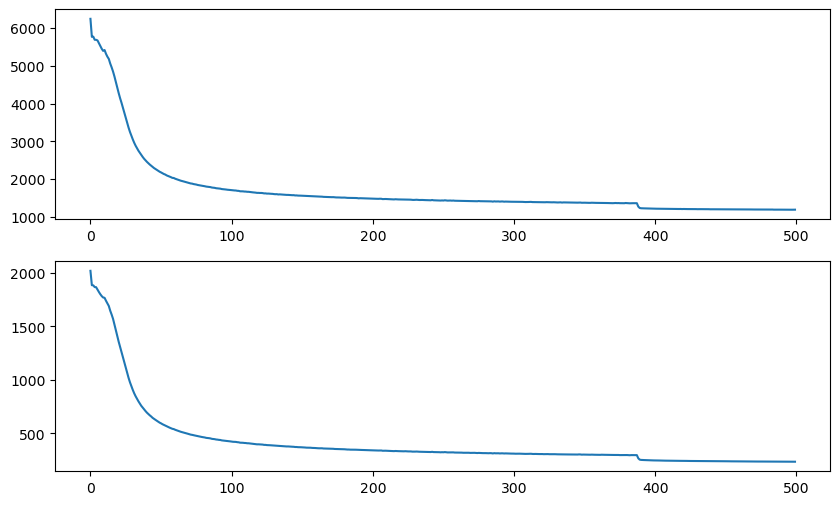

In [17]:
loss = pd.read_csv(f'../data/tuning/el_v_sky/lr0.001l50b4_hist.csv')
fig, ax = plt.subplots(2,1,figsize=(10,6))
ax[0].plot(loss['loss'])
ax[1].plot(loss['reconstruction_loss'])
plt.plot()

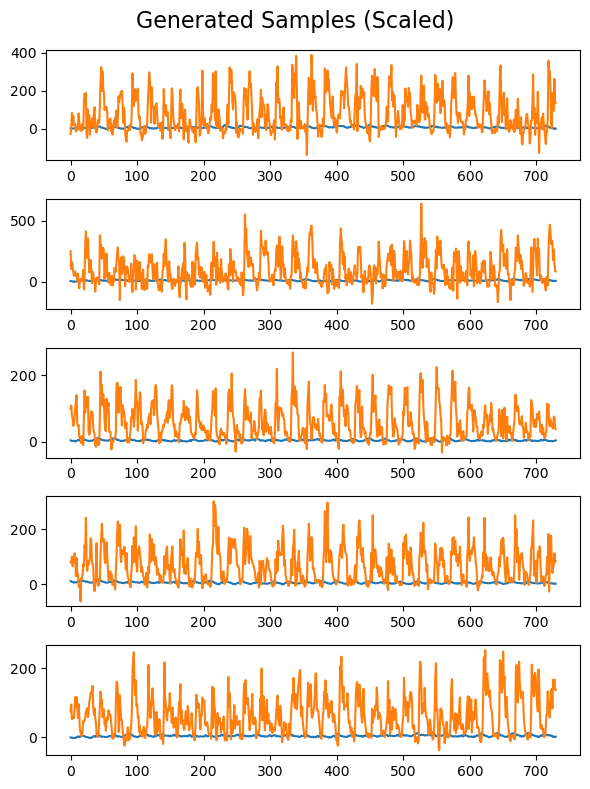

In [14]:
samples = np.load(f'../data/tuning/el_v_sky/lr0.001l20b4_scaled_samples.npy')
utils.plot_samples(samples, n=5)

In [ ]:
offset = 200
fig, ax = plt.subplots(5, 2, figsize=(20,16))
for i in range(5):
    ax[i,0].plot(samples[i+offset,:])
    ax[i,1].plot(base_data_train[i+offset,:])

In [ ]:
scaled_sample = samples.copy()
sub_zero_

In [98]:
latent_dims = [5, 10, 15, 20, 25, 30, 50]
batch_sizes = [4, 8, 16, 24, 32]
learning_rates = [0.001]


for lr in learning_rates:
    for l_dim in latent_dims:
        for b_size in batch_sizes:
            loss = pd.read_csv(f'../data/tuning/th_v_air2/lr{lr}l{l_dim}b{b_size}_hist.csv')
            print(f'{l_dim}, {b_size}:\t{loss["reconstruction_loss"].iloc[-1]}, {loss["kl_loss"].iloc[-1]}')
            
            #print(f'\t{loss["reconstruction_loss"].min()}, {loss["kl_loss"].min()}\n')

5, 4:	125.78038024902344, 82.37960052490234
5, 8:	134.357177734375, 195.43637084960935
5, 16:	318.814697265625, 391.4547119140625
5, 24:	549.0079956054688, 591.414306640625
5, 32:	627.294189453125, 784.8601684570312
10, 4:	124.54157257080078, 105.03862762451172
10, 8:	158.91241455078125, 285.734130859375
10, 16:	225.8592834472656, 603.4857788085938
10, 24:	381.1262512207031, 856.3172607421875
10, 32:	371.9774169921875, 1297.2952880859375
15, 4:	75.04124450683594, 169.9598388671875
15, 8:	143.60484313964844, 342.6283264160156
15, 16:	196.77081298828125, 697.9022216796875
15, 24:	253.65283203125, 1209.19091796875
15, 32:	415.66217041015625, 1412.33154296875
20, 4:	103.36032104492188, 156.20785522460938
20, 8:	113.41942596435548, 386.58447265625
20, 16:	255.116943359375, 701.1310424804688
20, 24:	390.177978515625, 808.5620727539062
20, 32:	461.1646423339844, 1335.7515869140625
25, 4:	78.7401123046875, 197.7386016845703
25, 8:	97.72098541259766, 470.3772888183594
25, 16:	213.0150451660156,

(1000, 1460, 2) (1000, 1460, 2)


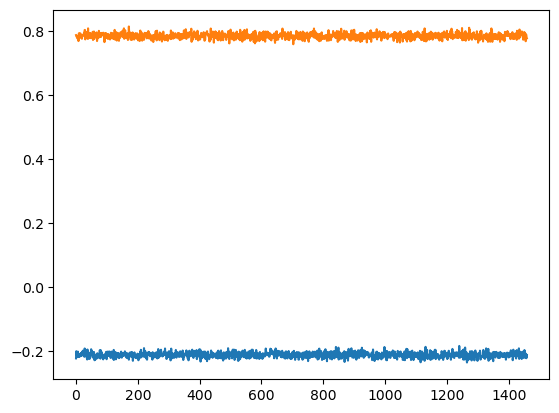

In [64]:
samples = np.load('../data/tuning/th_v_air2/lr0.001l25b4_samples.npy')
scaled_samples = np.load('../data/tuning/th_v_air2/lr0.001l25b4_scaled_samples.npy')
print(samples.shape, scaled_samples.shape)
plt.plot(samples[2,:])

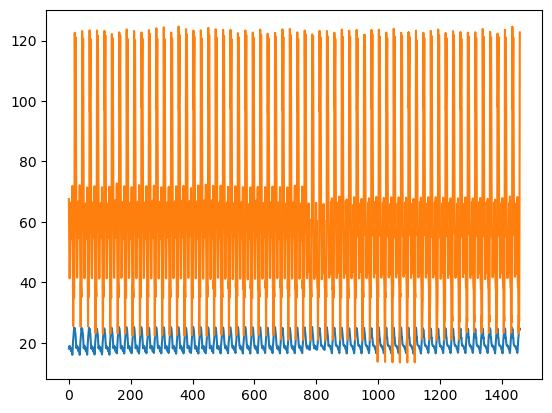

In [65]:
plt.plot(scaled_samples[2,:])

In [67]:
pd.DataFrame(scaled_samples[:,1020,0]).describe()

,0
count,1000.000000
mean,18.056948
std,1.065715
min,12.944165
25%,17.444351
50%,18.284541
75%,19.055280
max,19.155230
